# Act 3: Generate New Content from Data

In Acts 1 and 2, we built a system to store, organize, and search multimodal content. But what if you want to **generate entirely new content** from your existing data? Here we'll practice **generating from data** - using the scenes, frames, and transcripts you've already created as inputs to compose new content.

**The Challenge:** Creating highlight reels, trailers, and promotional content from source media typically requires complex multi-tool workflows. You'd need to:
- Manually identify similar content segments across your media
- Extract clips and stitch them together using separate tools
- Generate intro sequences using different AI services
- Combine everything in editing software with manual sync
- Add background music and finalize

This process is time-consuming, hard to iterate on, and doesn't scale to multiple variations or automated workflows. Without unified infrastructure, you're managing separate systems for search, extraction, generation, and assembly.

**The approach in this notebook:**
- **Semantic similarity search** - Find visually similar video clips using embedding indexes created for specifically selected frames
- **Content composition** - Extract clips and concatenate them into a single reel
- **AI-powered generation** - Use Gemini's Veo model to create intro sequences from images
- **revise** - Combine all components (intro, clips, audio) into one video

In [1]:
import pixeltable as pxt

**Set up Gemini API key**

We'll use Gemini's video generation model later in this notebook, so let's set up the API key now.

In [2]:
import os
import getpass

if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = getpass.getpass('Google AI Studio API Key:')

In [3]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['scene_reel',
 'final_reels',
 'reels',
 'sim_scenes_concat',
 'intro_scene',
 'chess_vids',
 'scene_view',
 'blob_storage_demo.media']

In [4]:
scenes = pxt.get_table('scene_view')

In [5]:
scenes

view 'scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                      video_segment.extract_audio()
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
              video            Video                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Find similar scenes and create clips

To find visually similar scenes, we'll first add a computed column that extracts the middle frame from each scene, then create an embedding index on those frames for semantic search.

**Step 1: Add middle_frame computed column**

Extract the middle frame from each scene's video segment:

In [6]:
# Extract the middle frame from each scene
scenes.add_computed_column(
    middle_frame=scenes.video_segment.extract_frame(
        timestamp=scenes.video_segment.get_duration() / 2.0
    ),
    if_exists='replace'
)

Added 10 column values with 0 errors.


10 rows updated, 10 values computed.

In [7]:
scenes

view 'scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                      video_segment.extract_audio()
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
       middle_frame            Image  video_segment.extract_frame(timestamp=video_se...
              video            Video                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

pos                                      video_segment  \
0    0  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
1    1  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
2    2  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
3    3  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
4    4  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
5    5  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
6    6  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
7    7  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
8    8  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   
9    9  /Users/alison-pxt/.pixeltable/media/4d56b426a8...   

                                        middle_frame  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
6  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
7  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
8  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
9  <PIL.JpegImagePlugin.JpegImageFile image mode=...
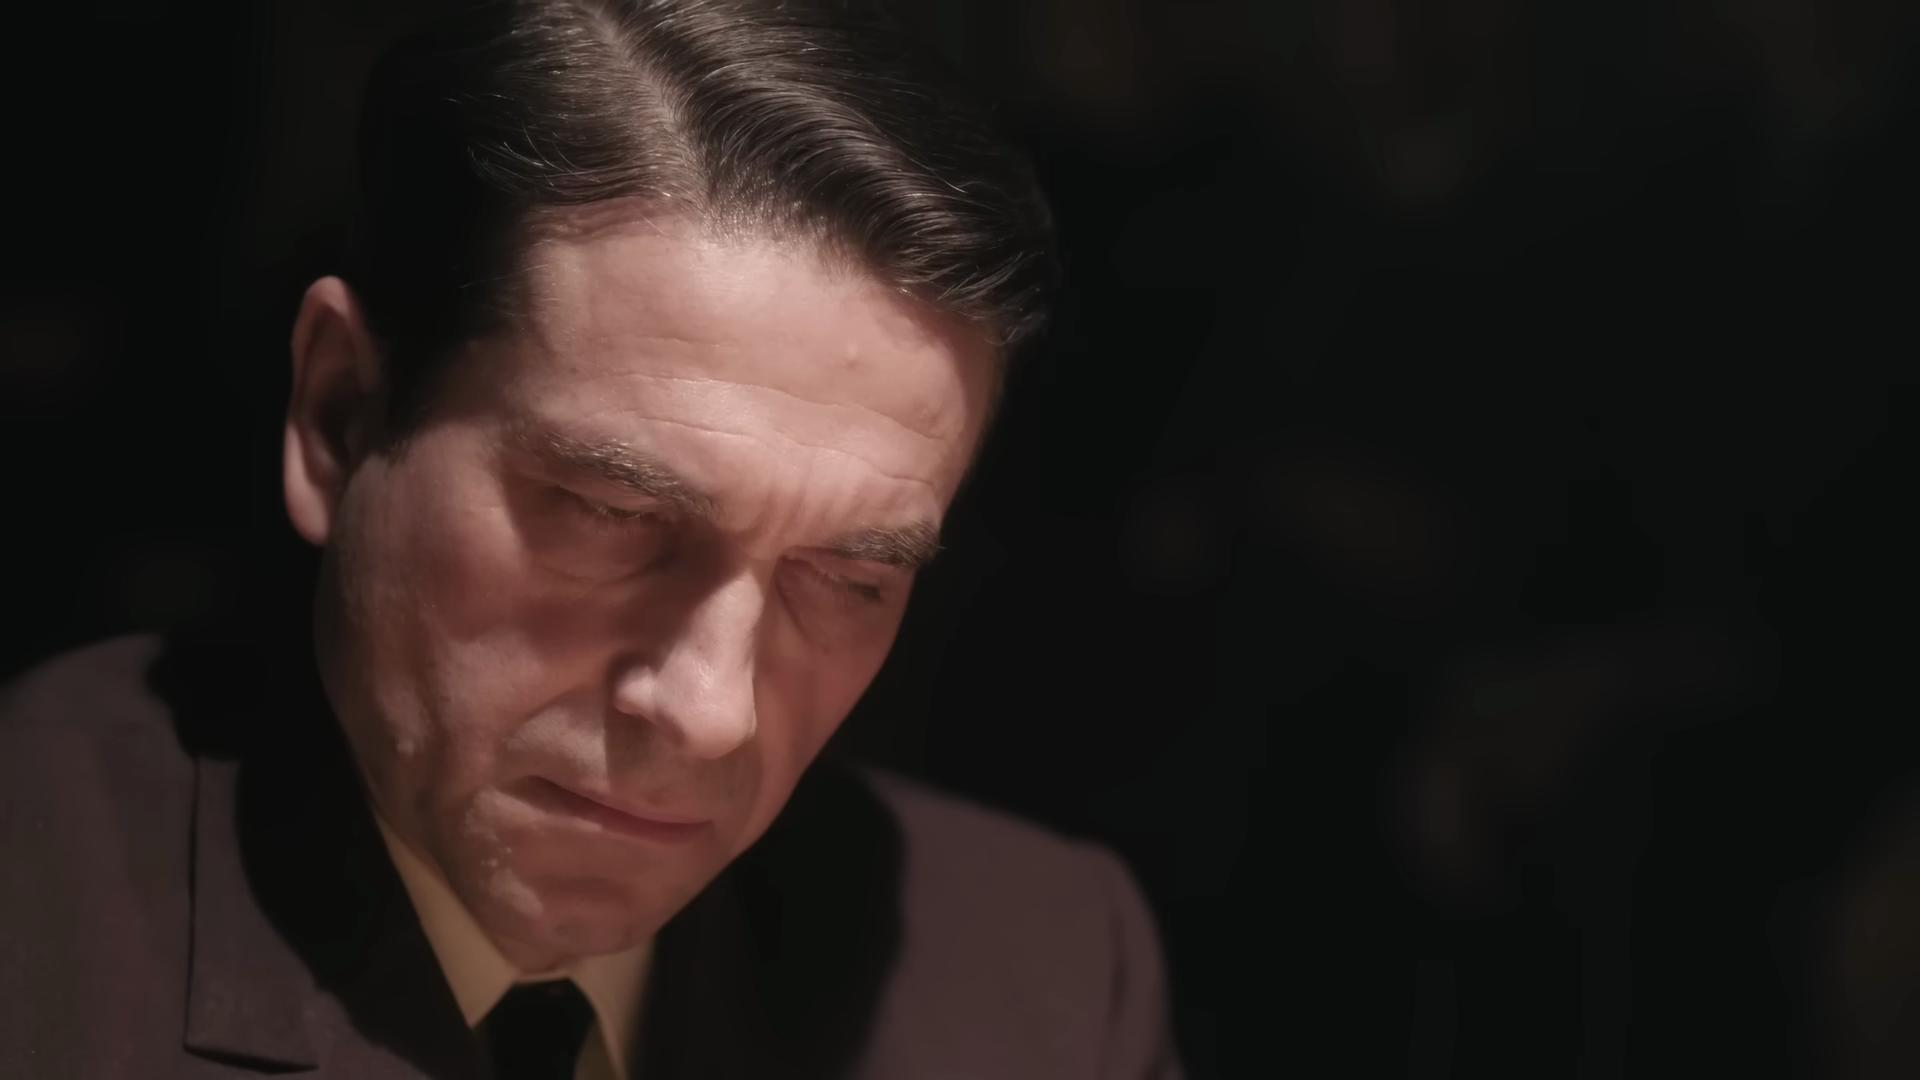
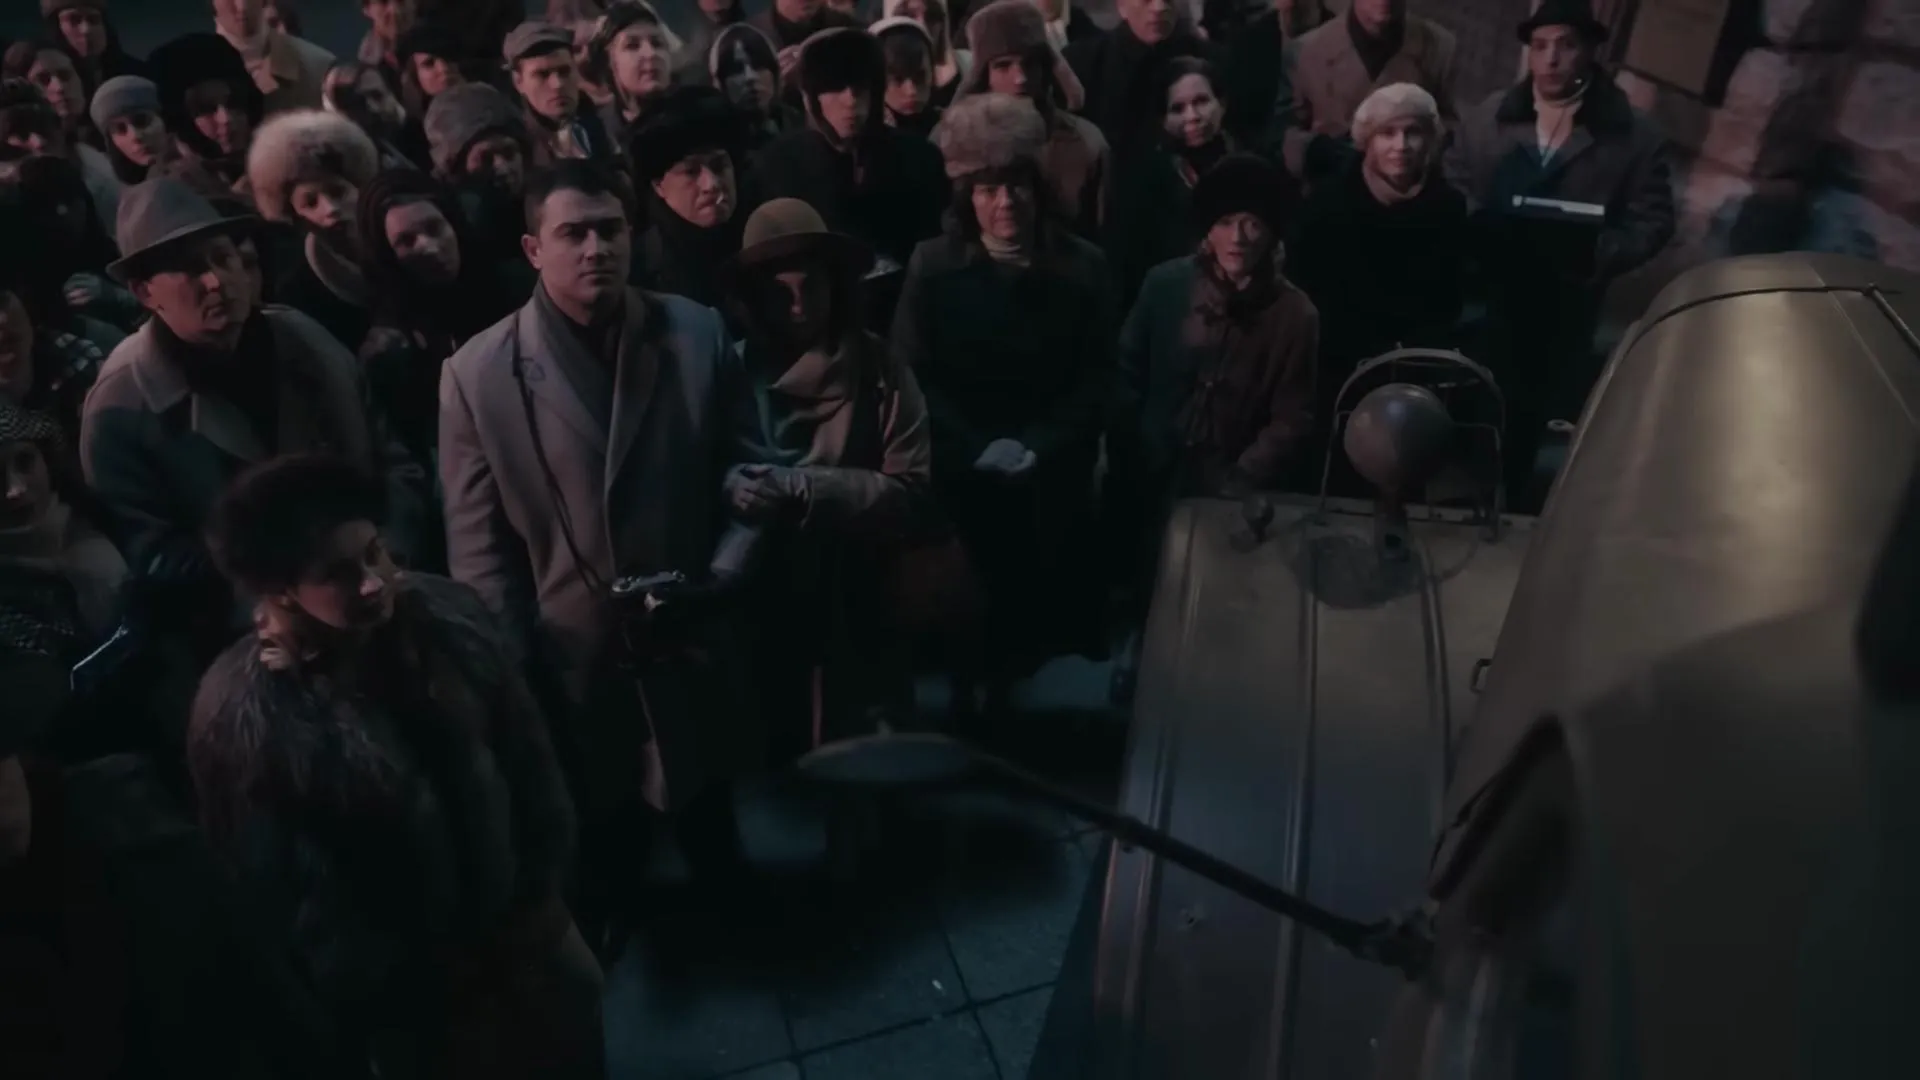
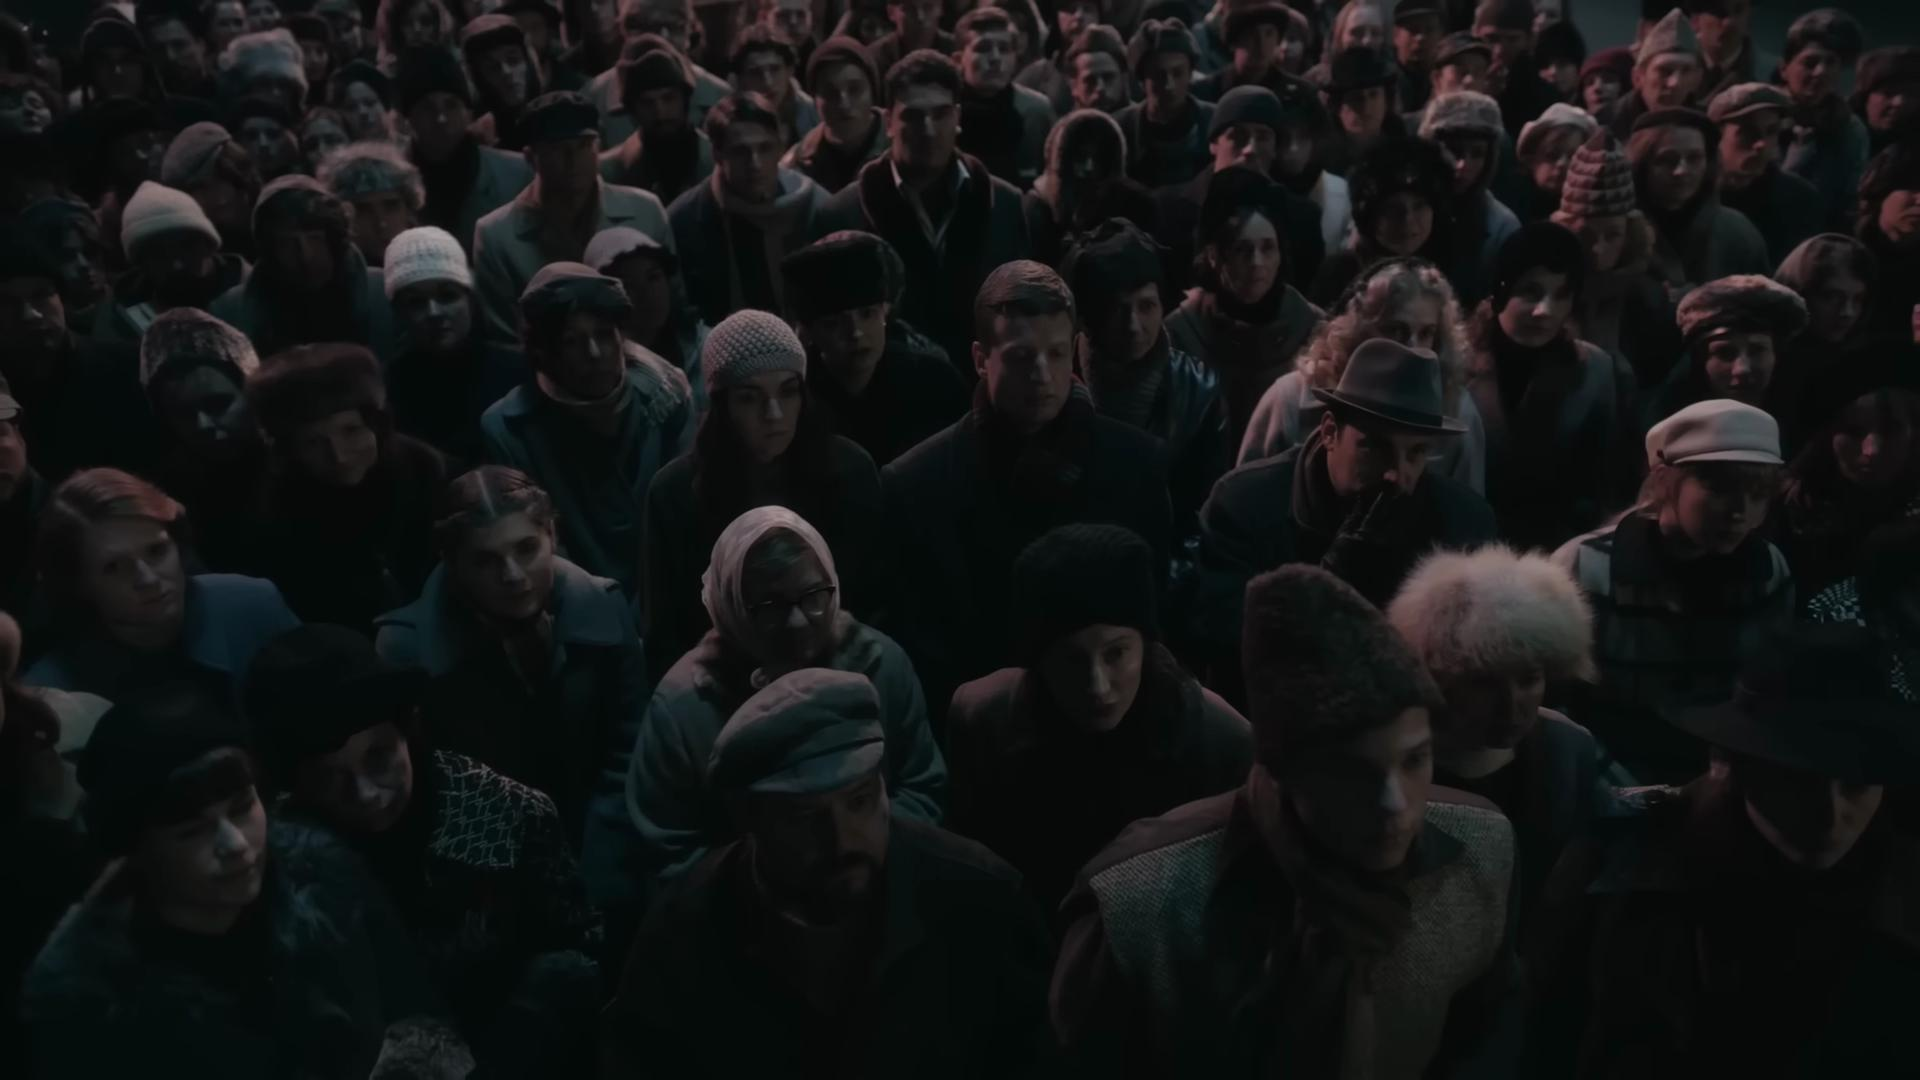
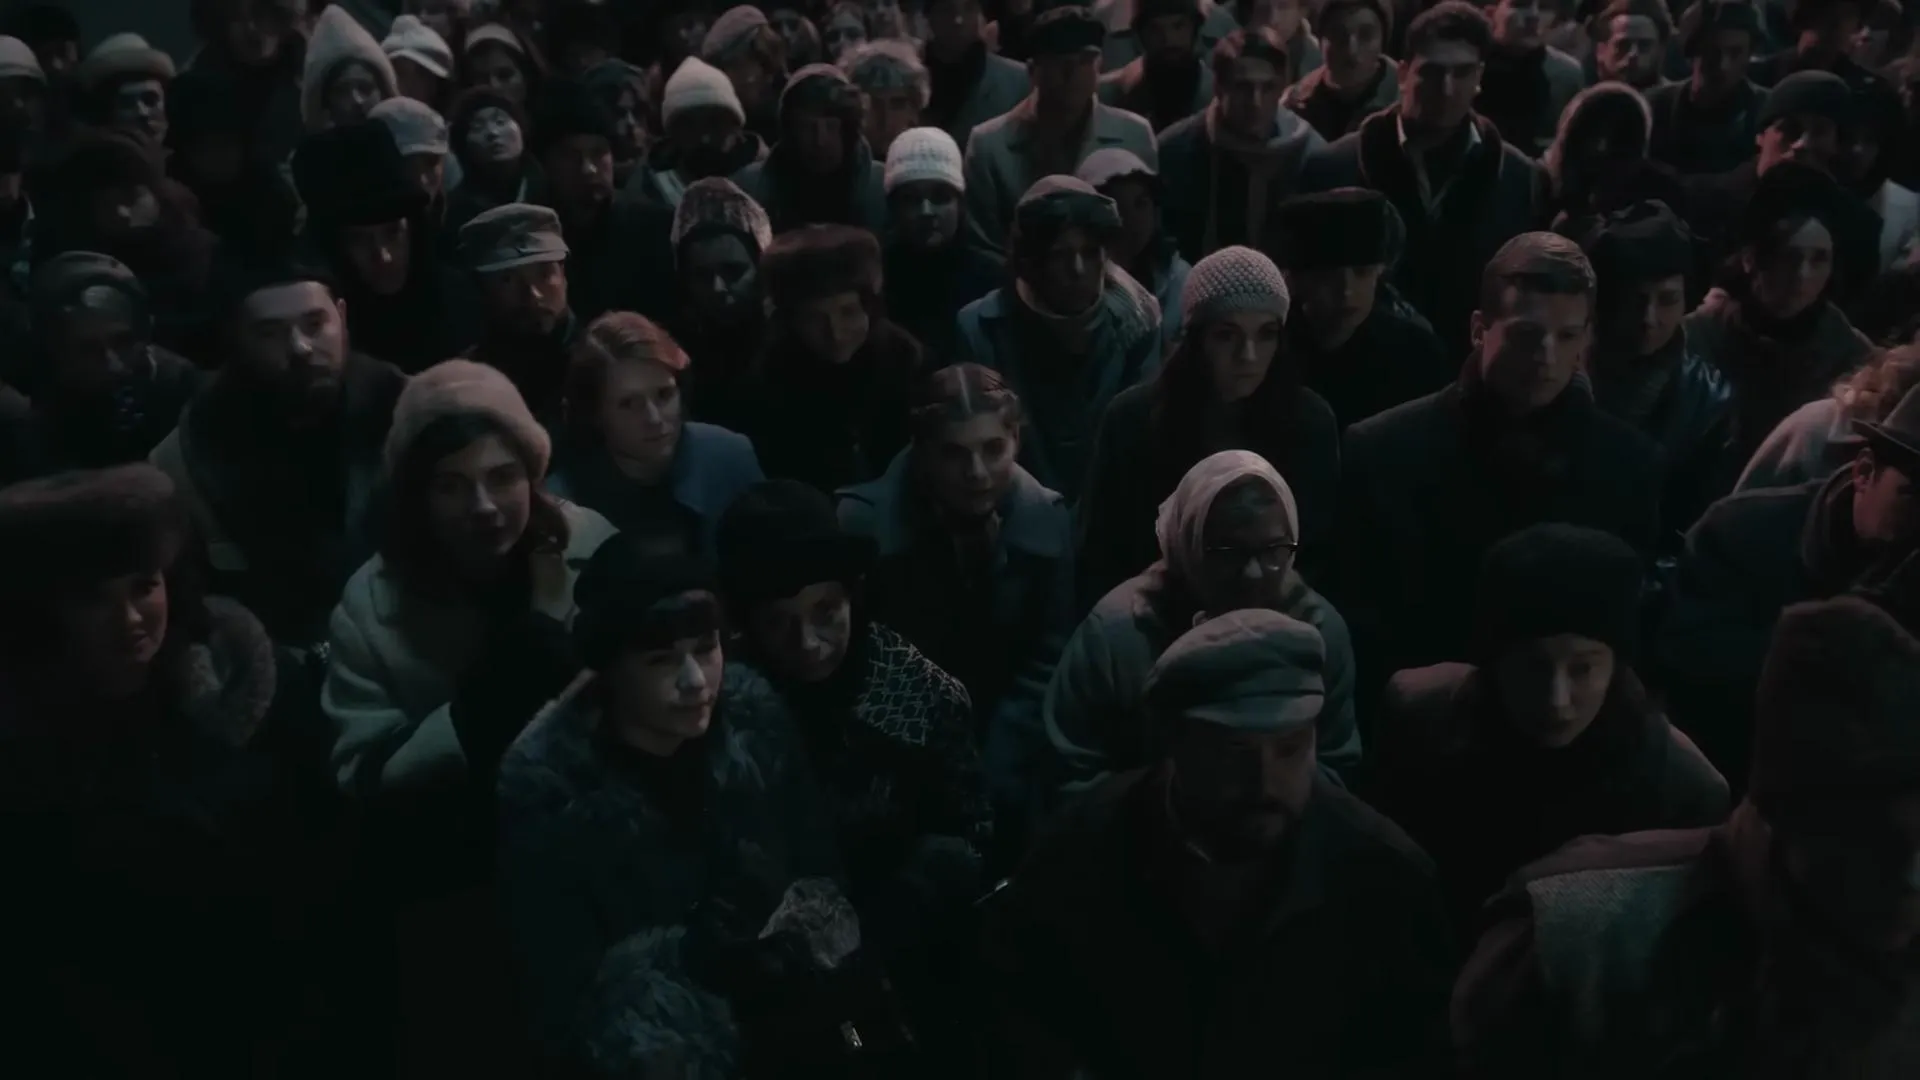
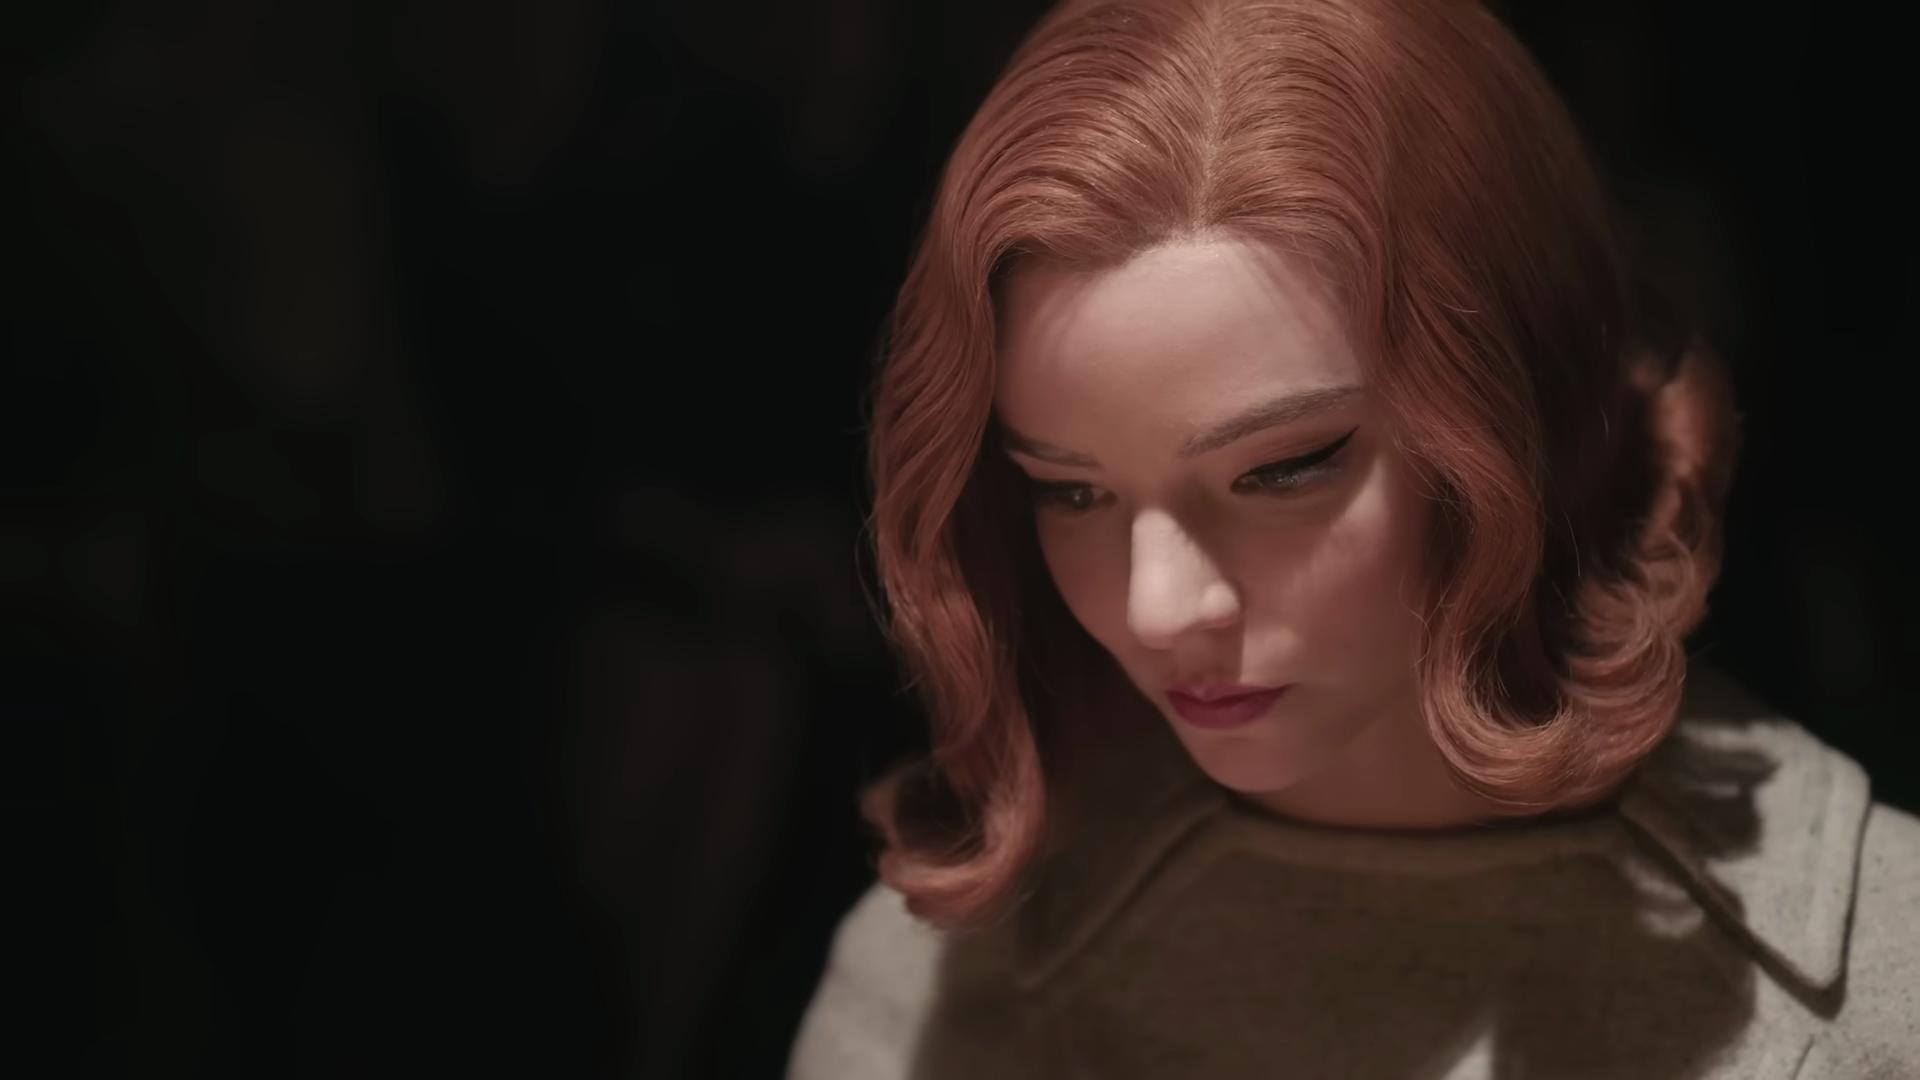
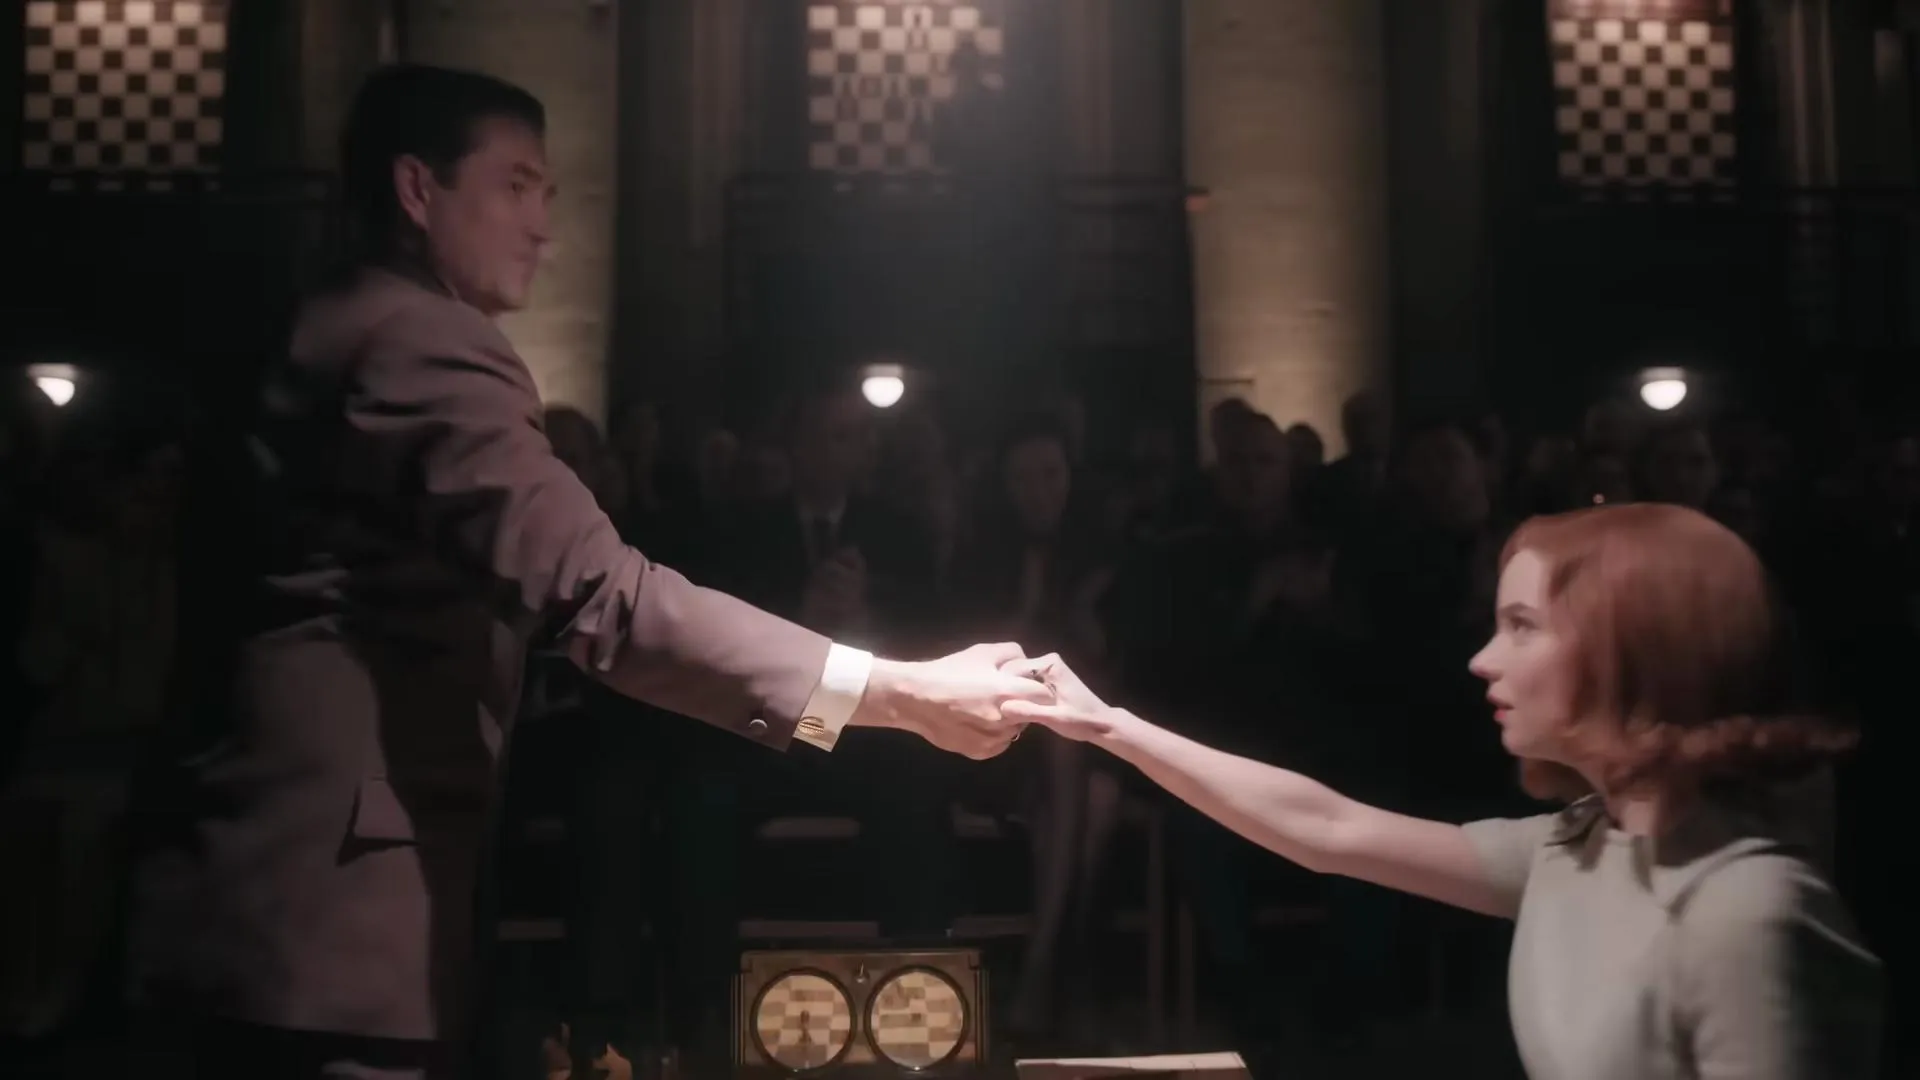
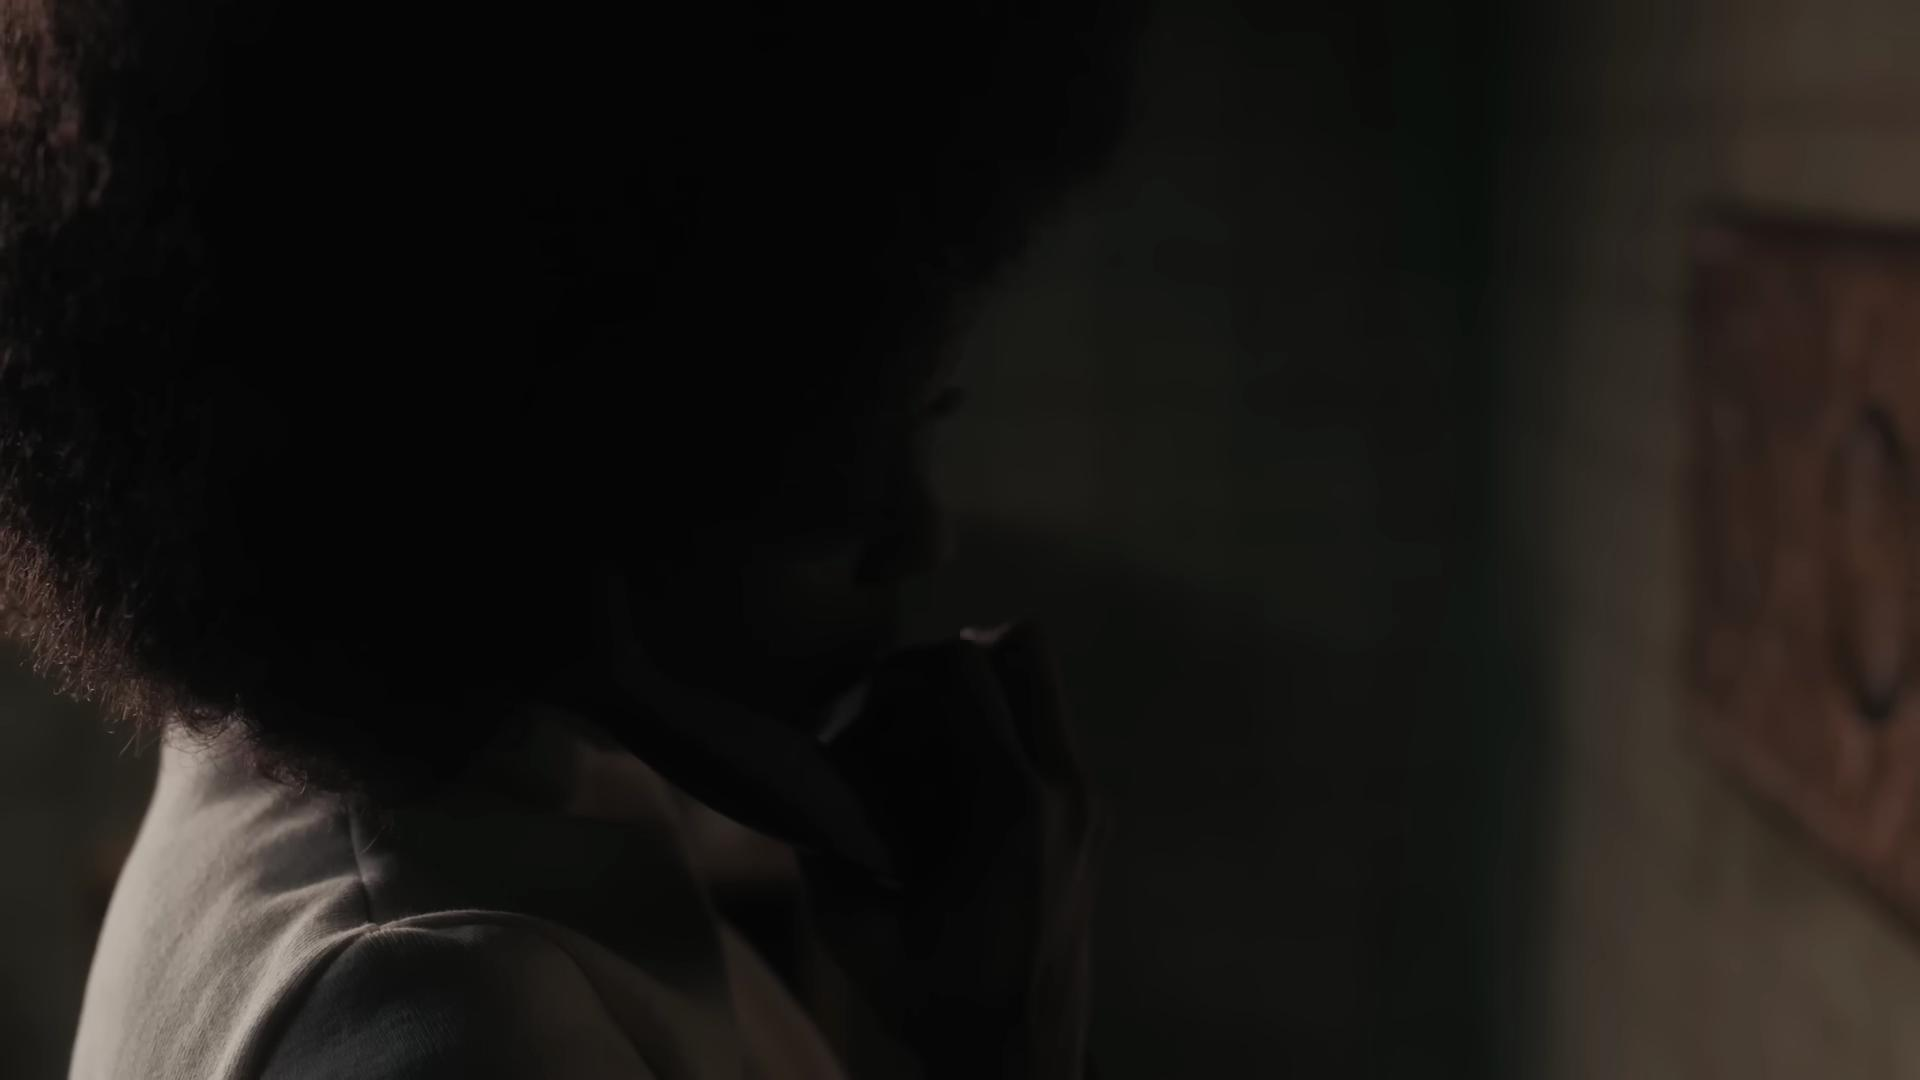
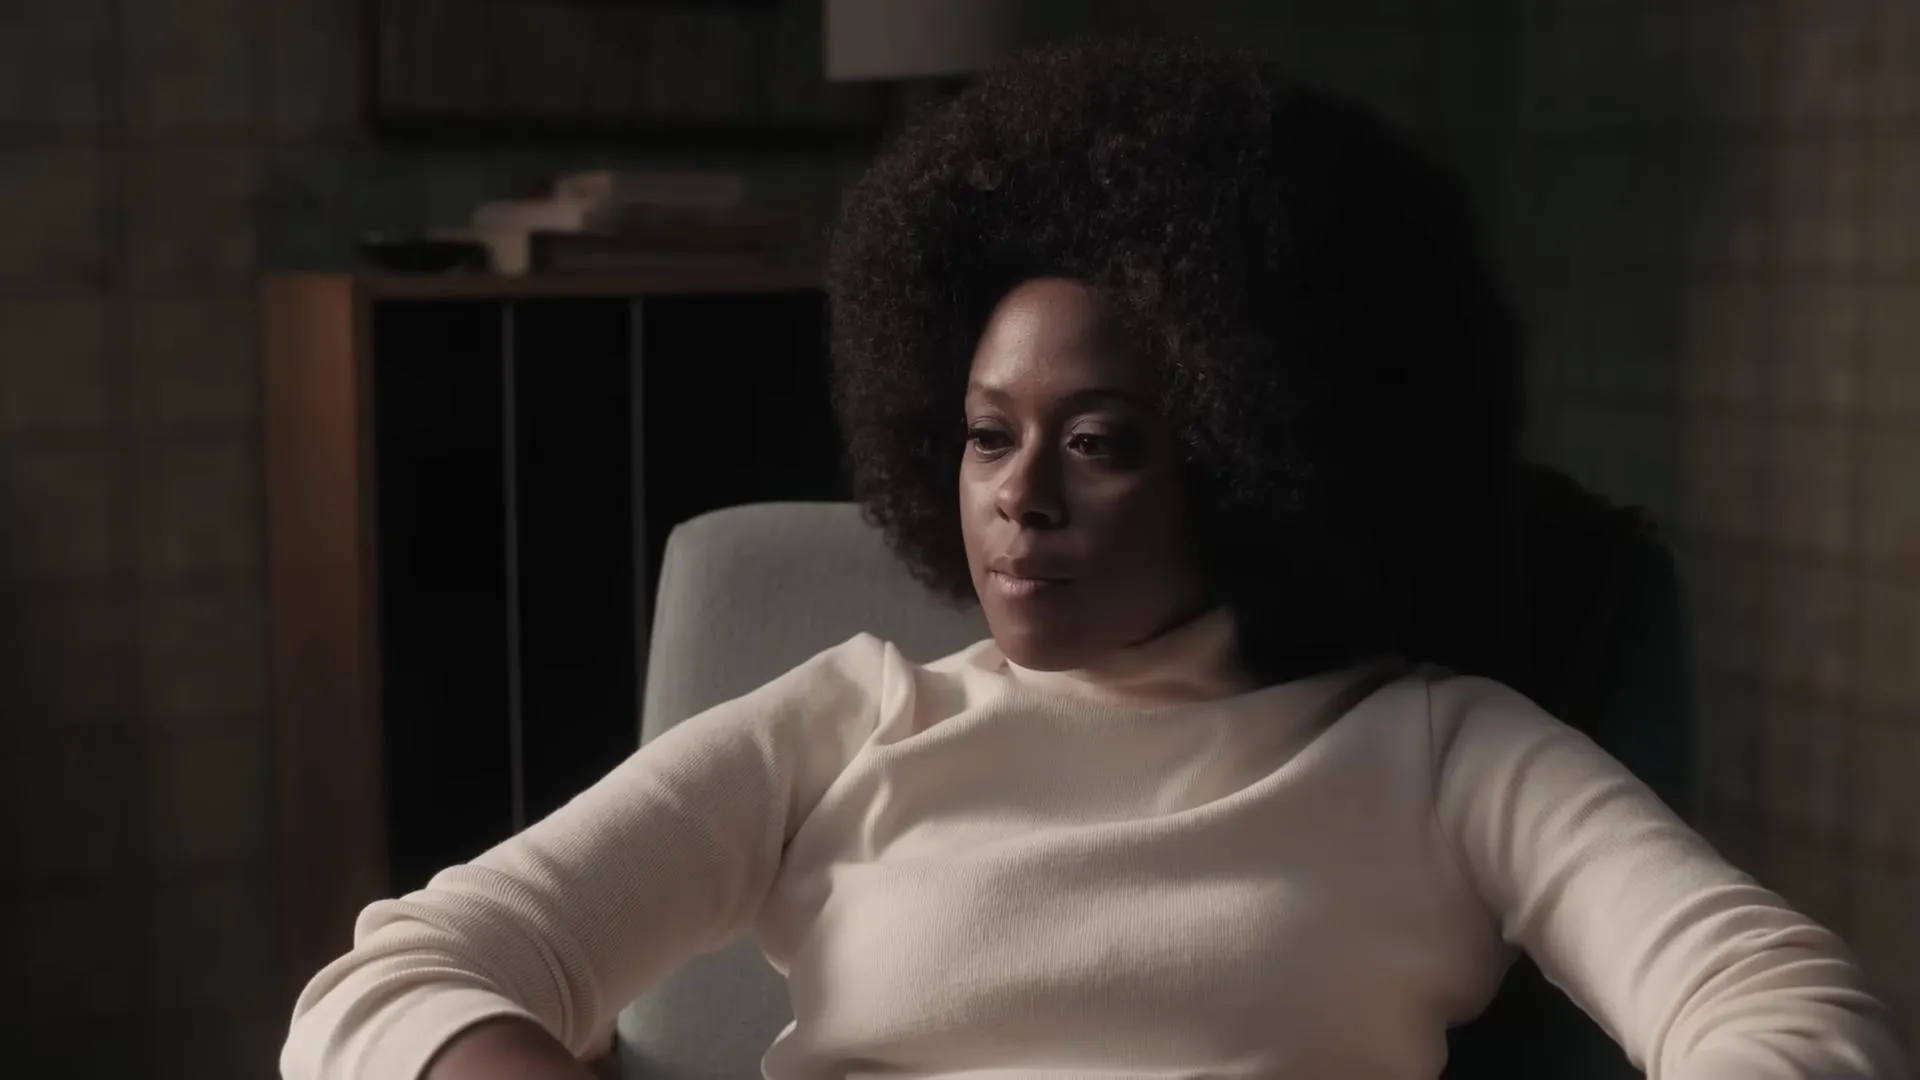
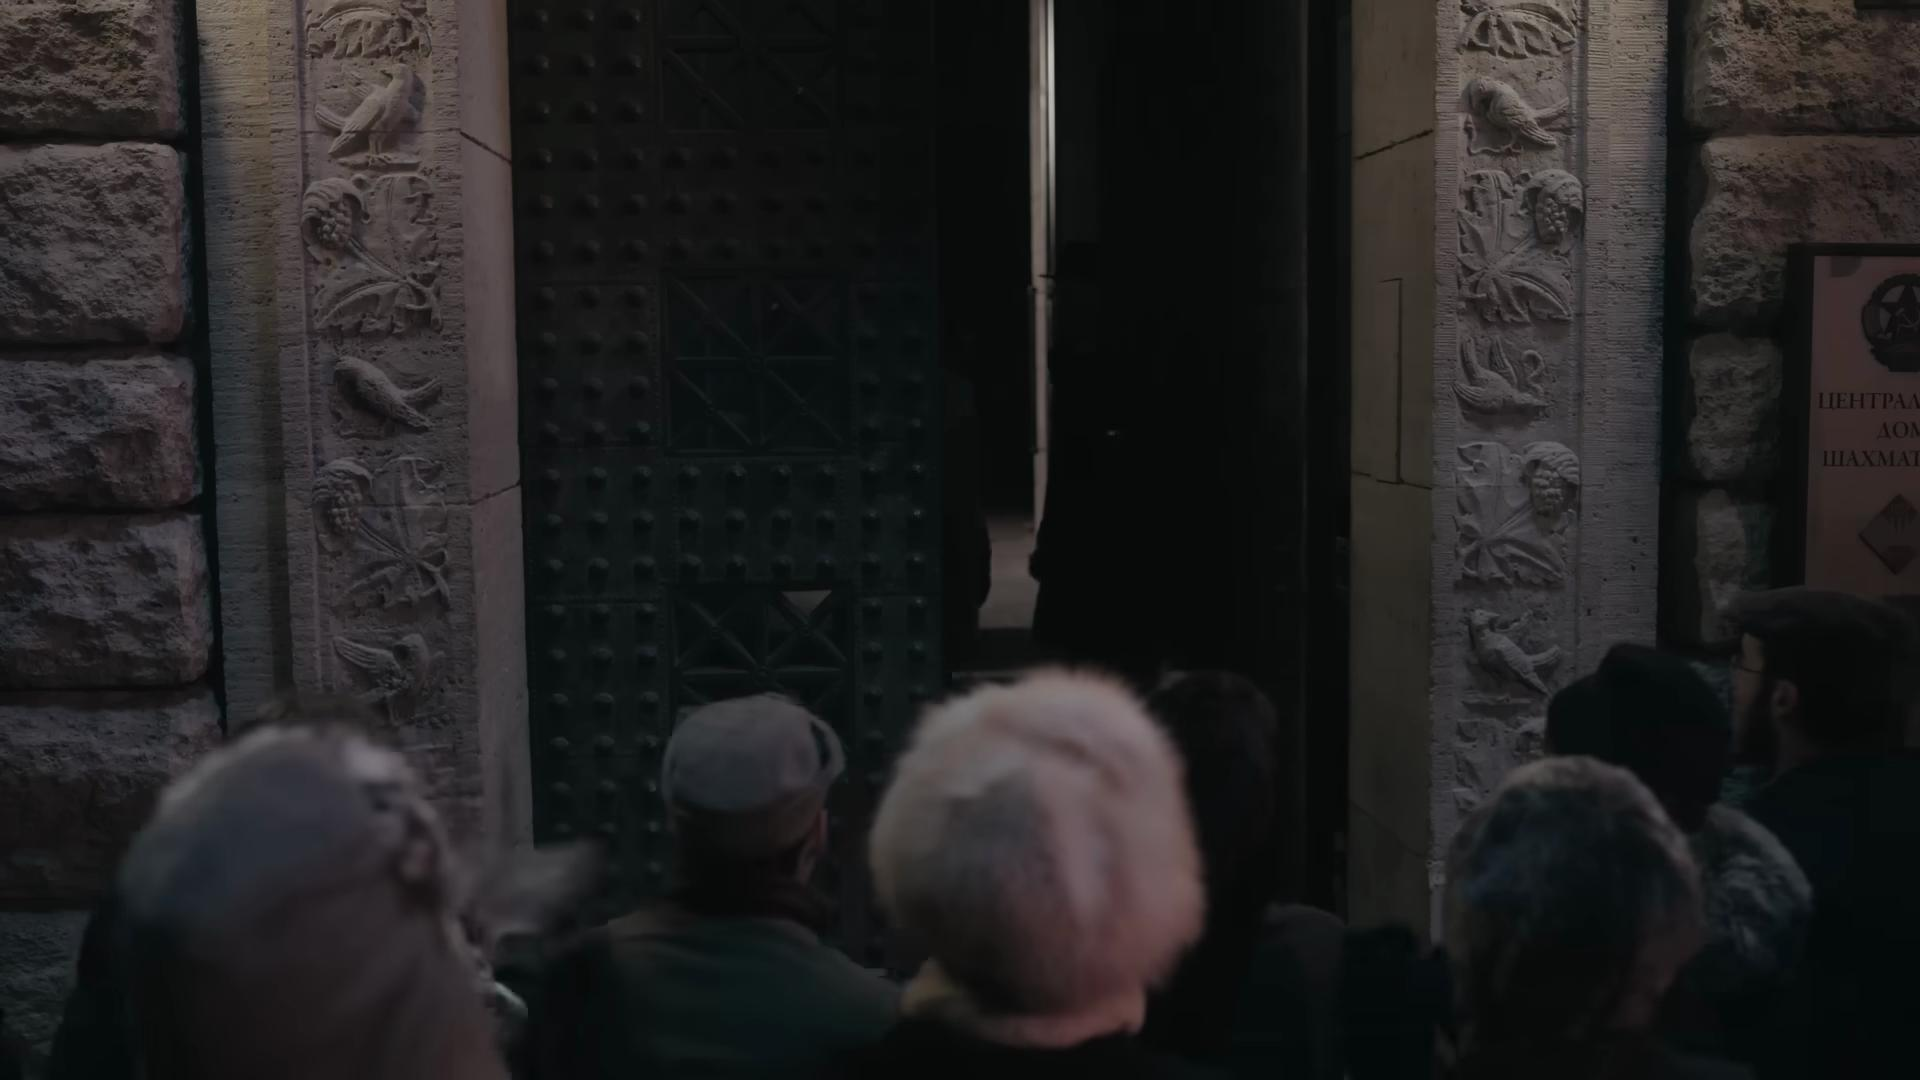
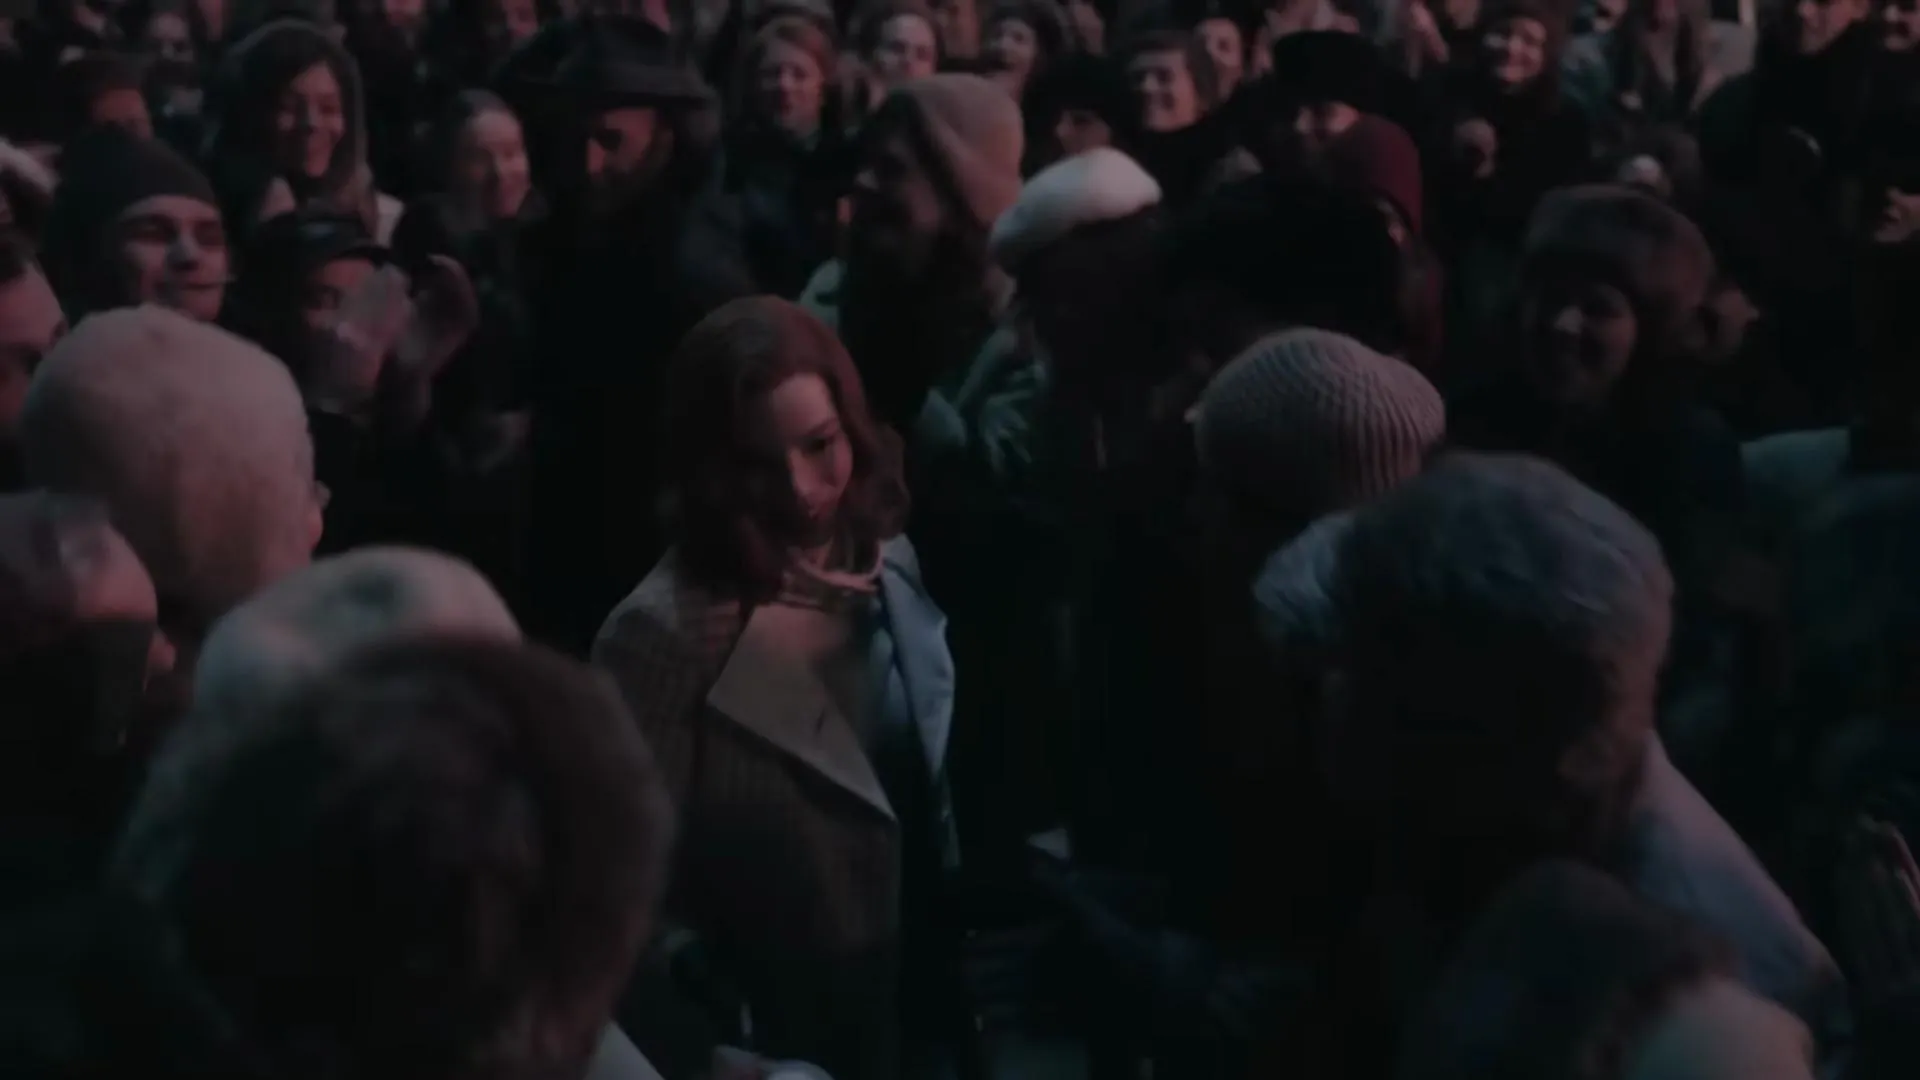
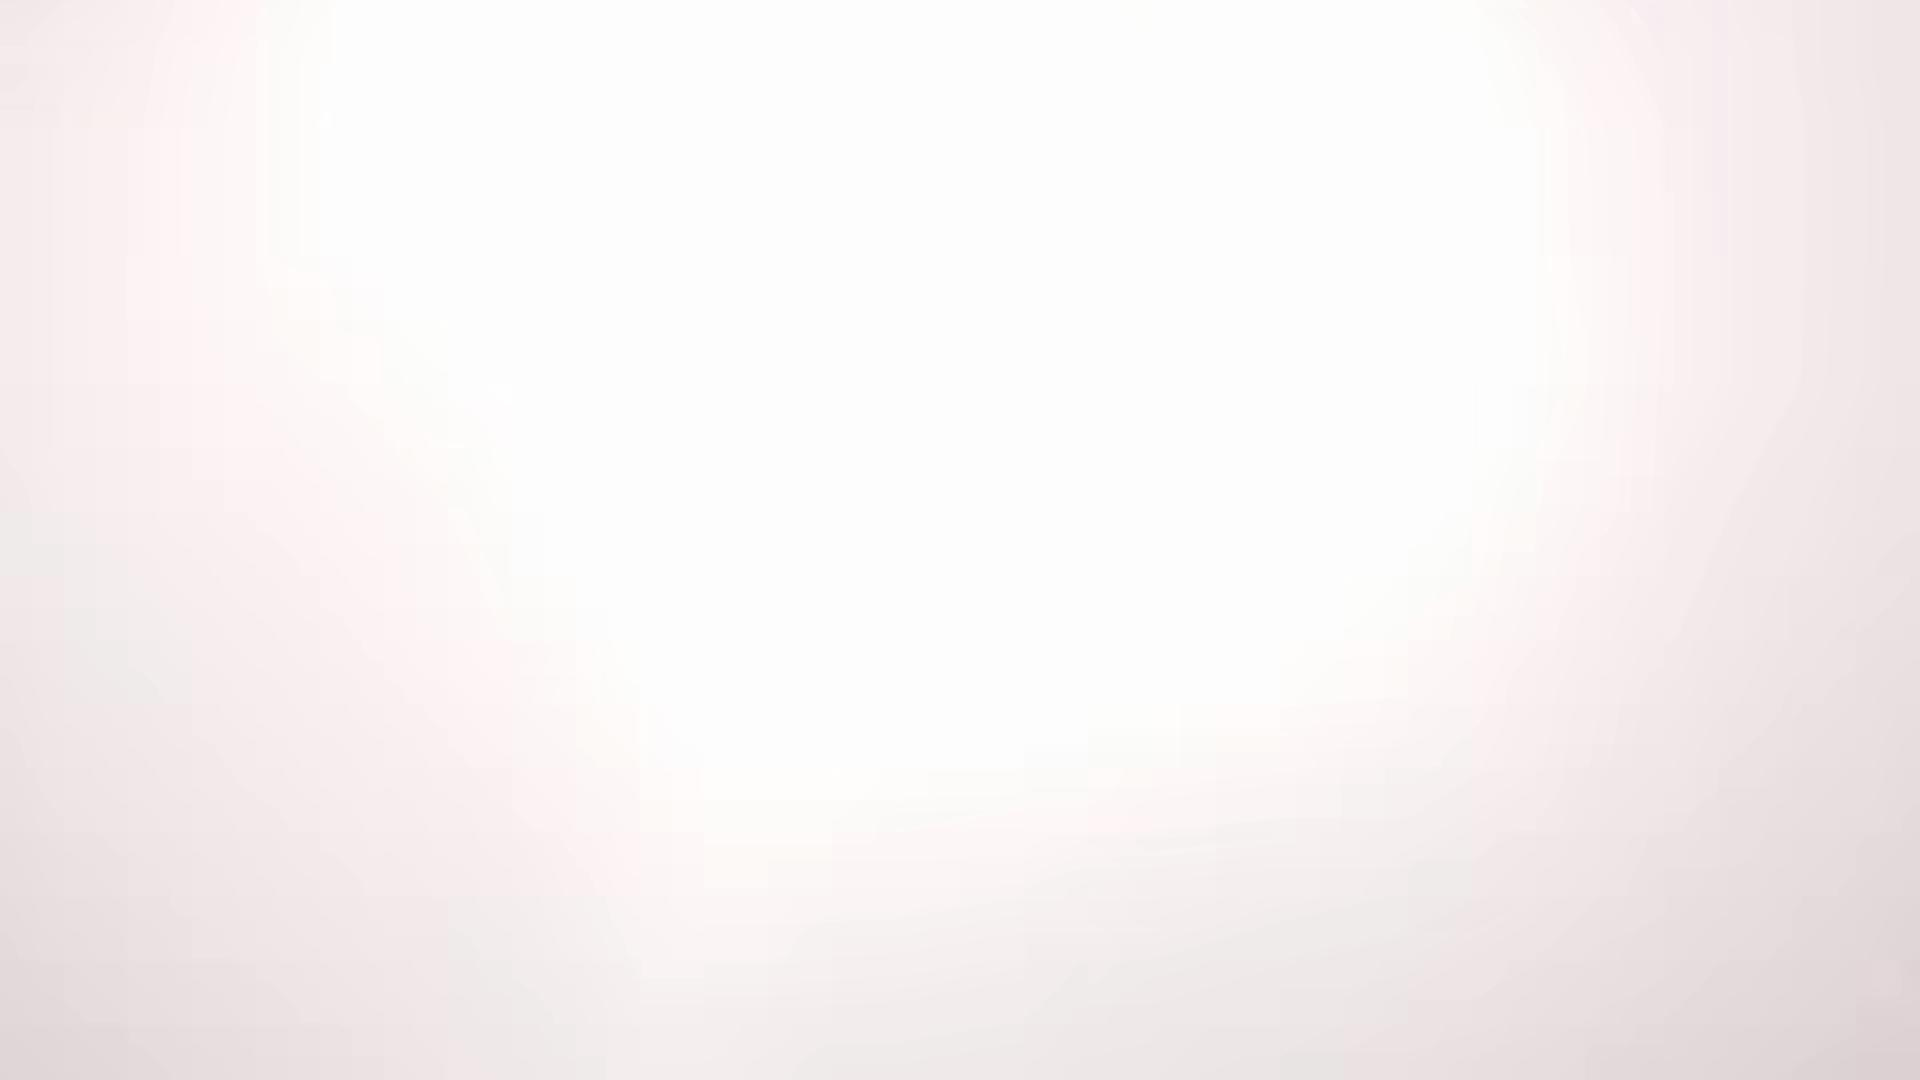
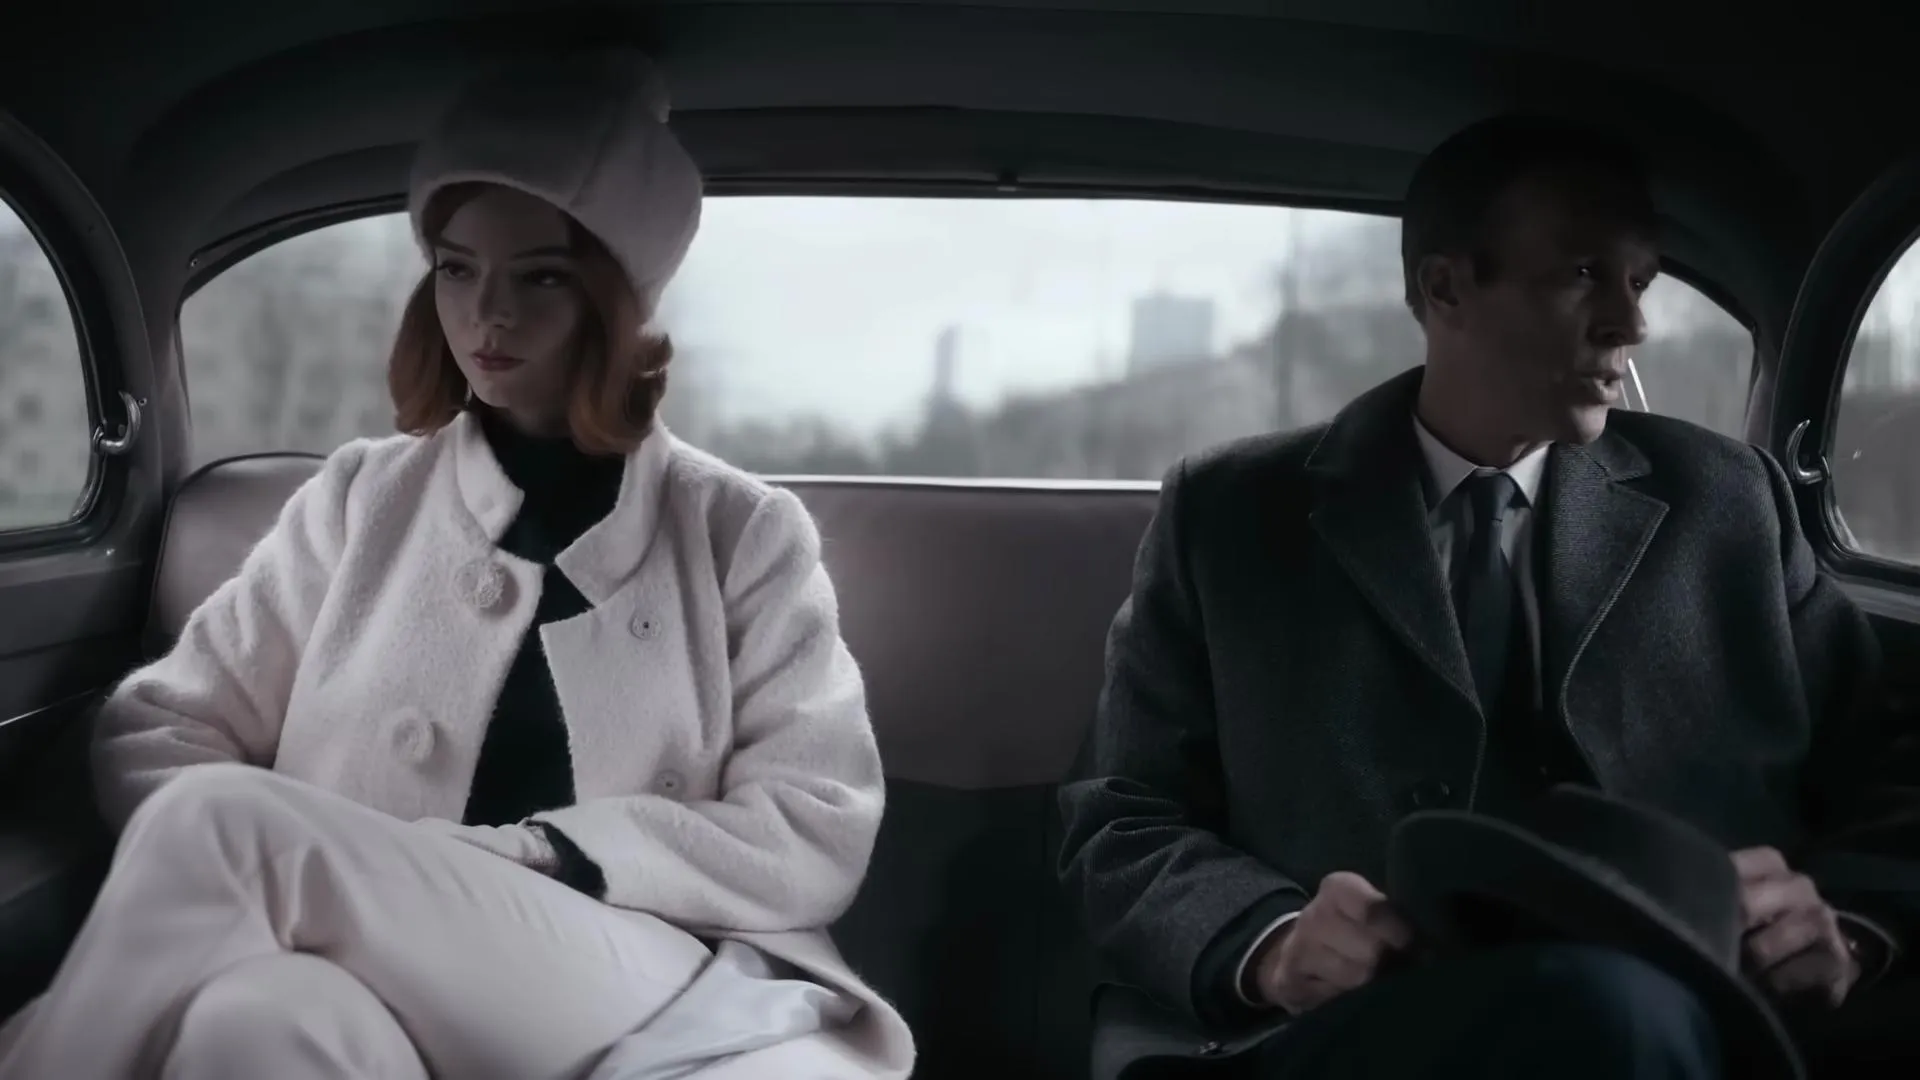
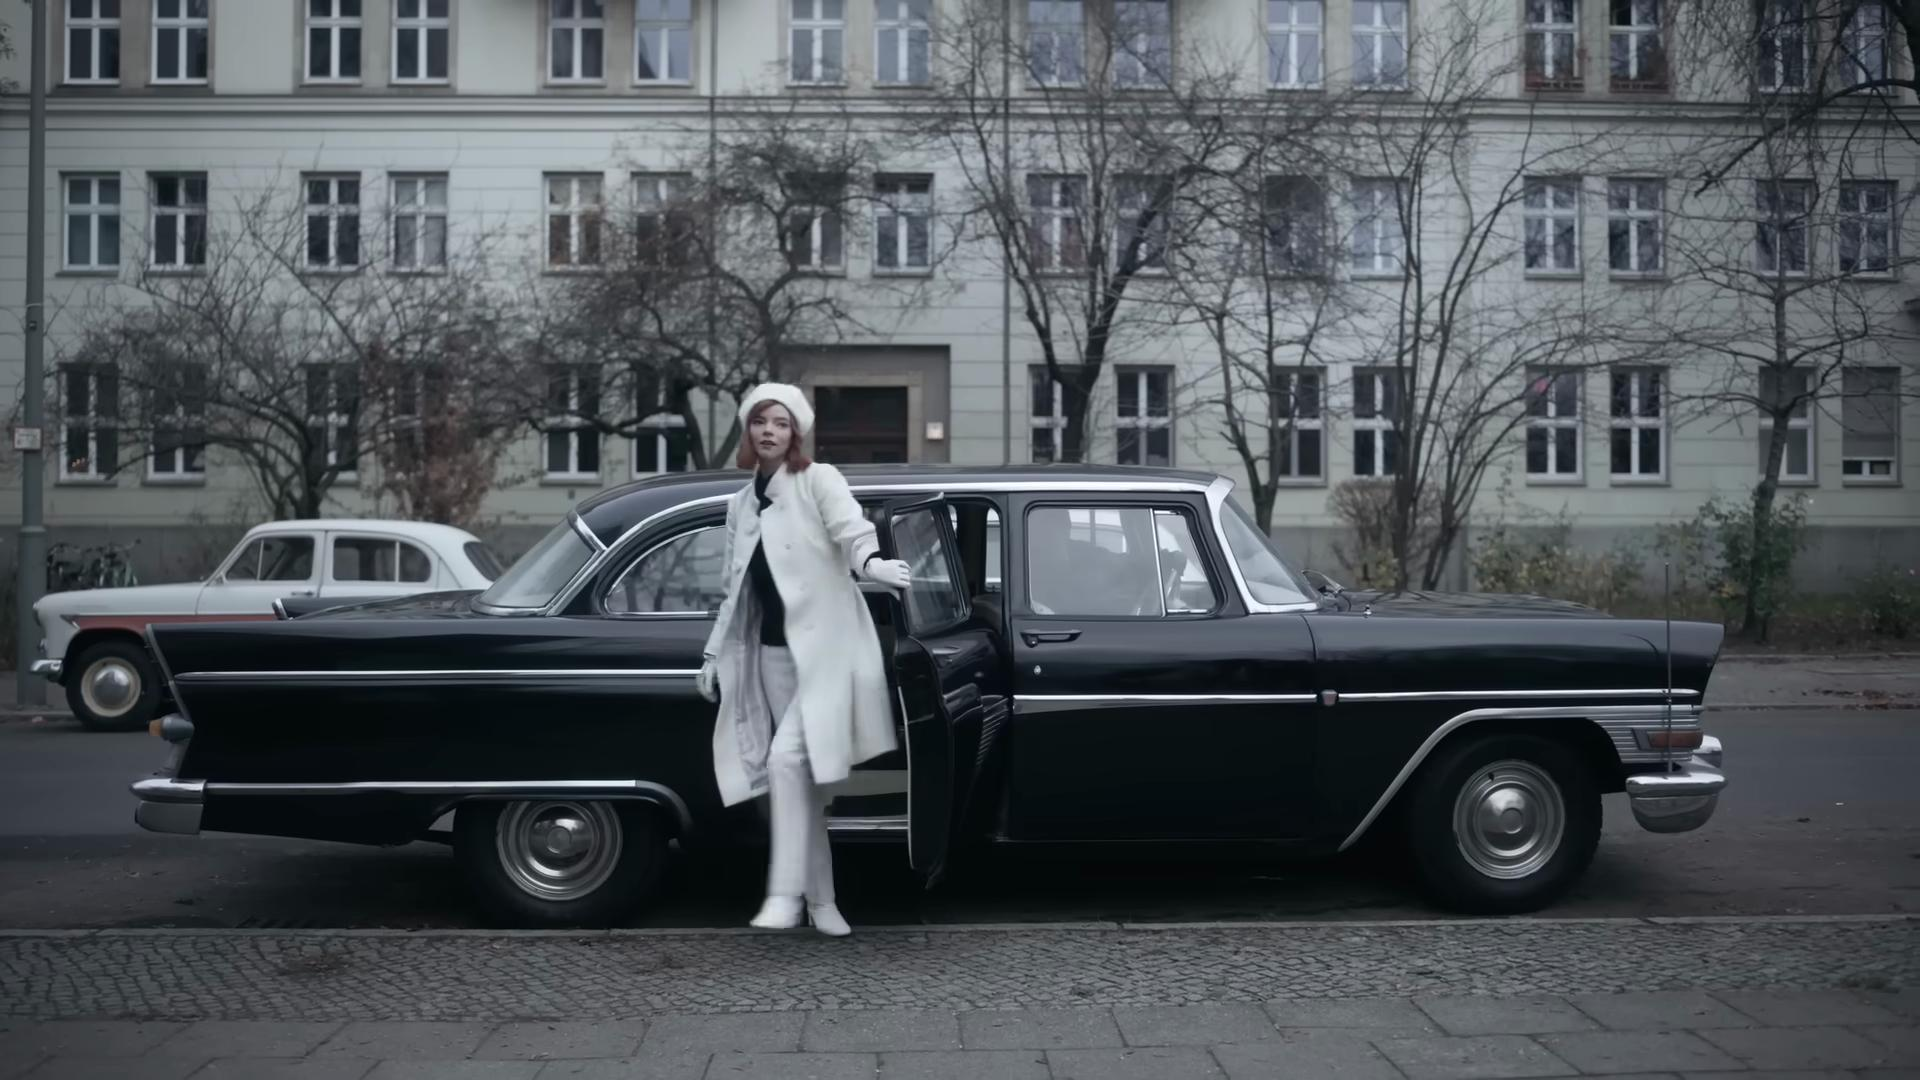
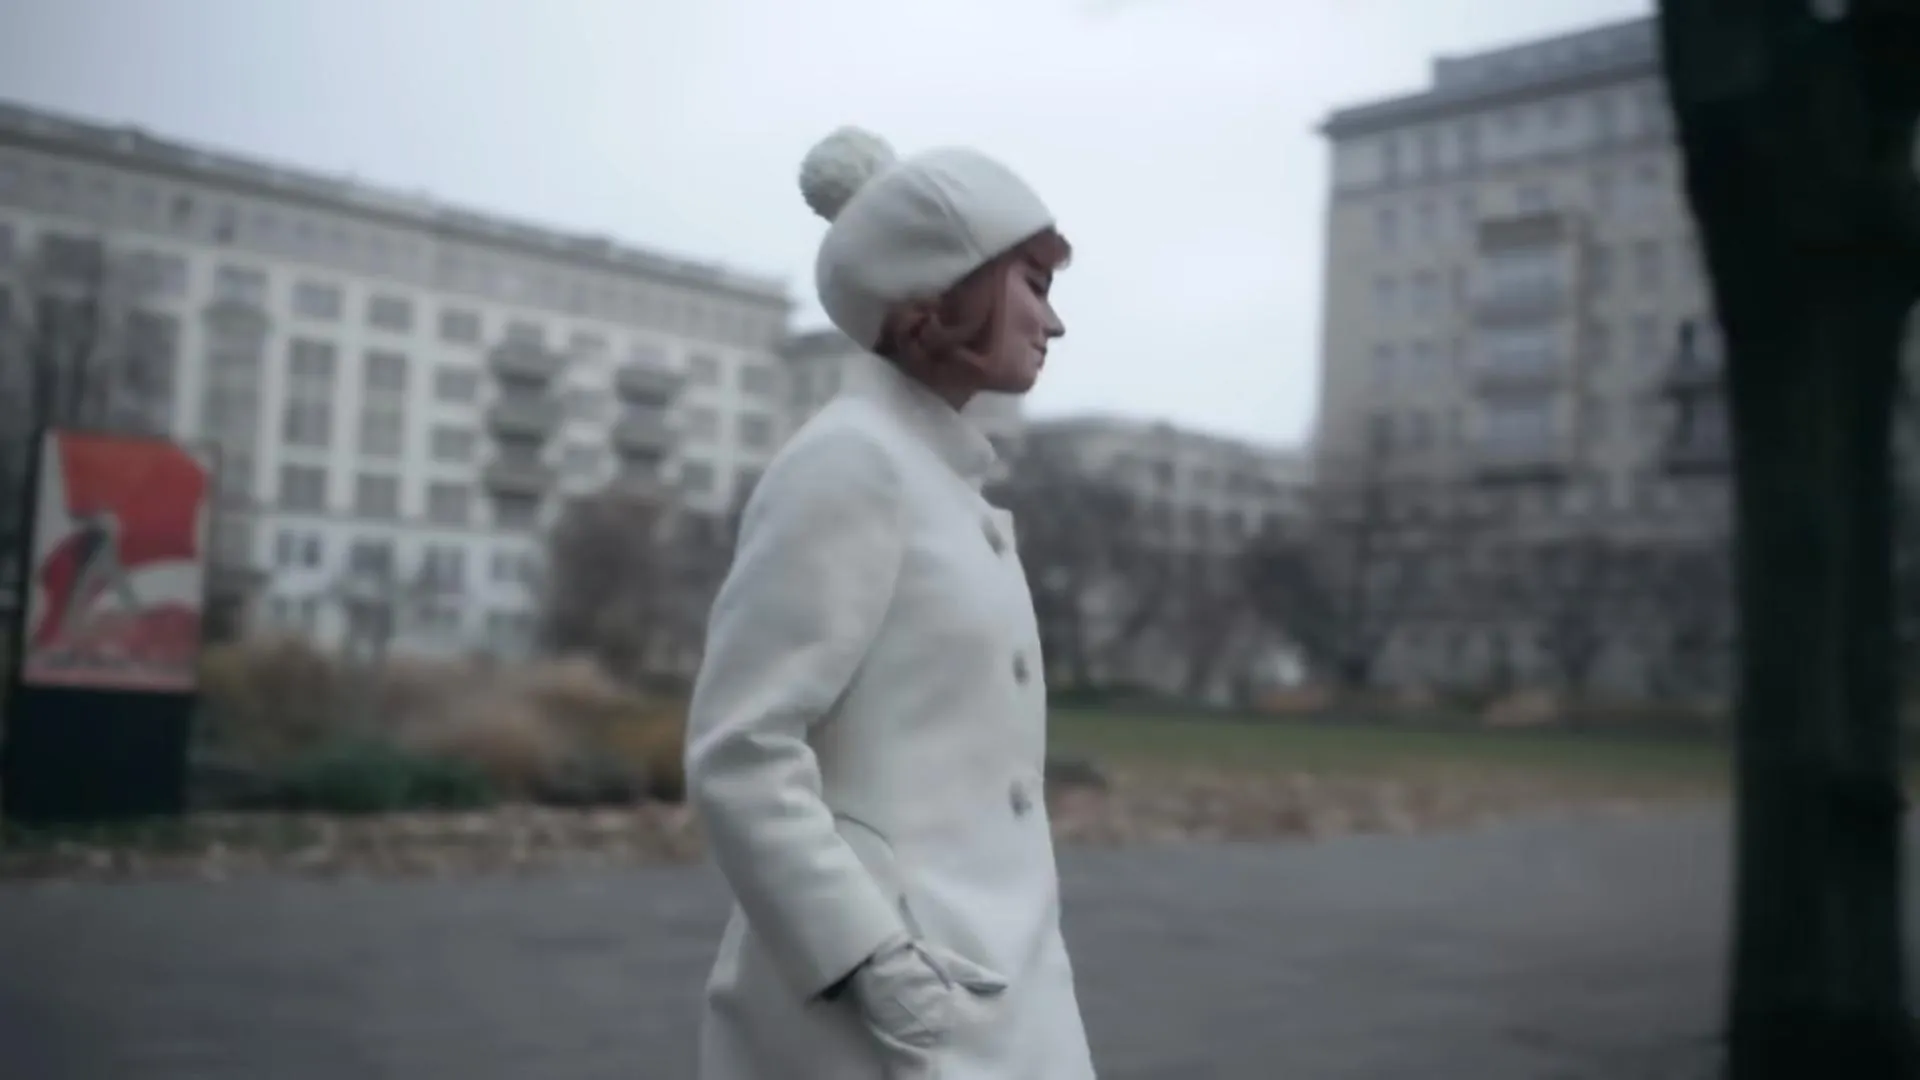
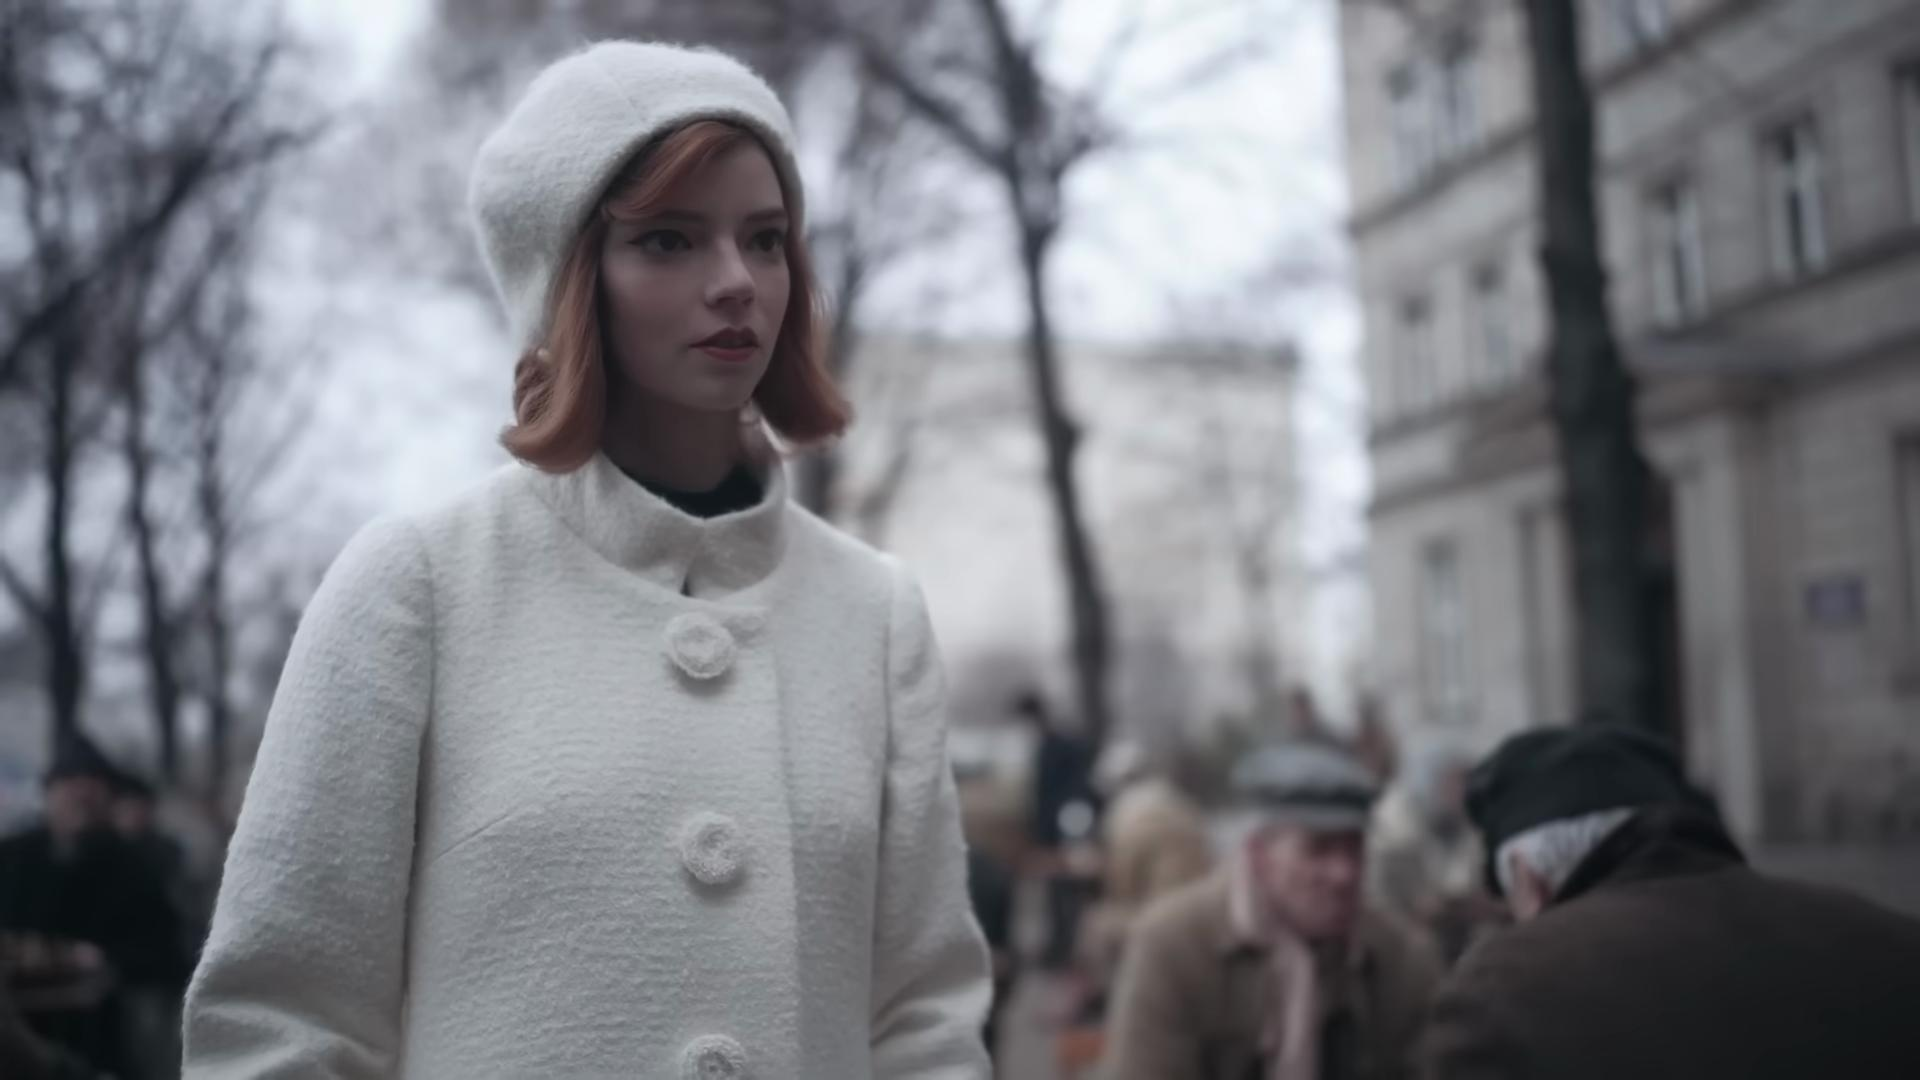
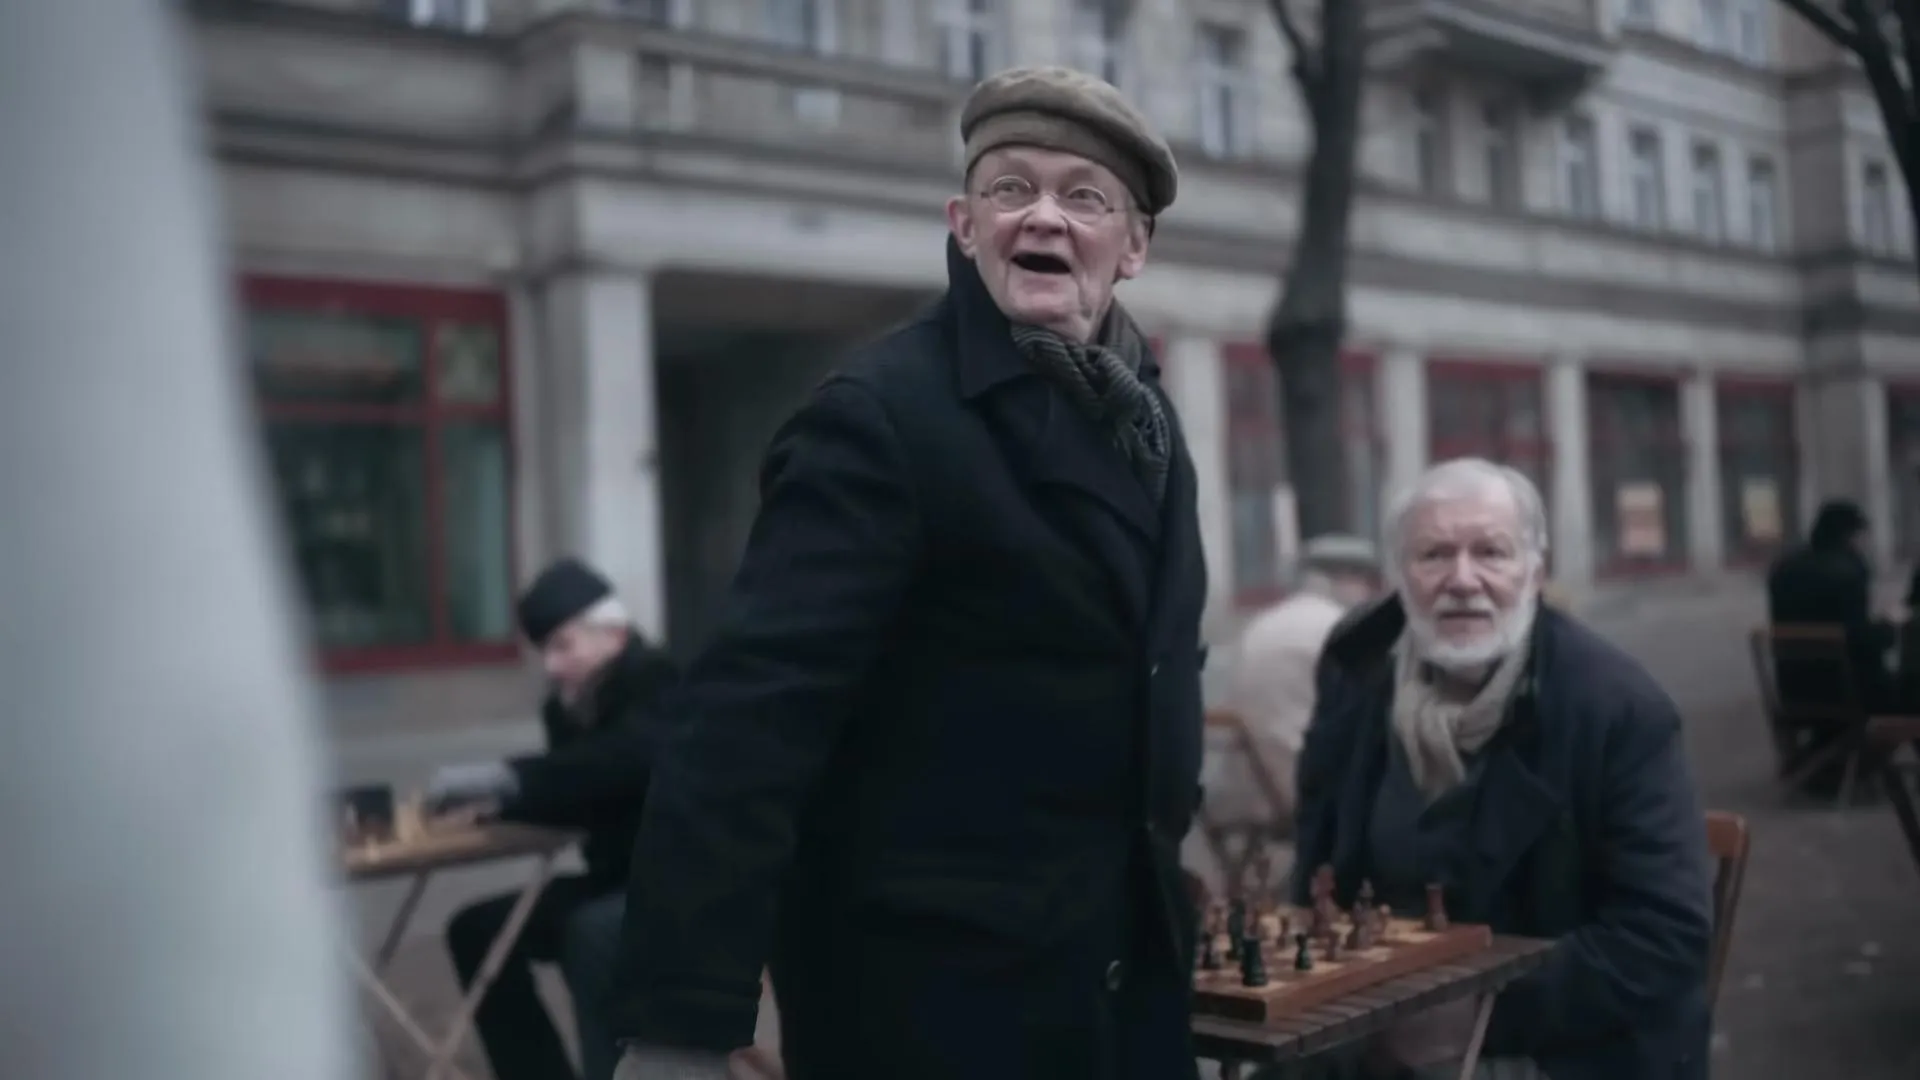
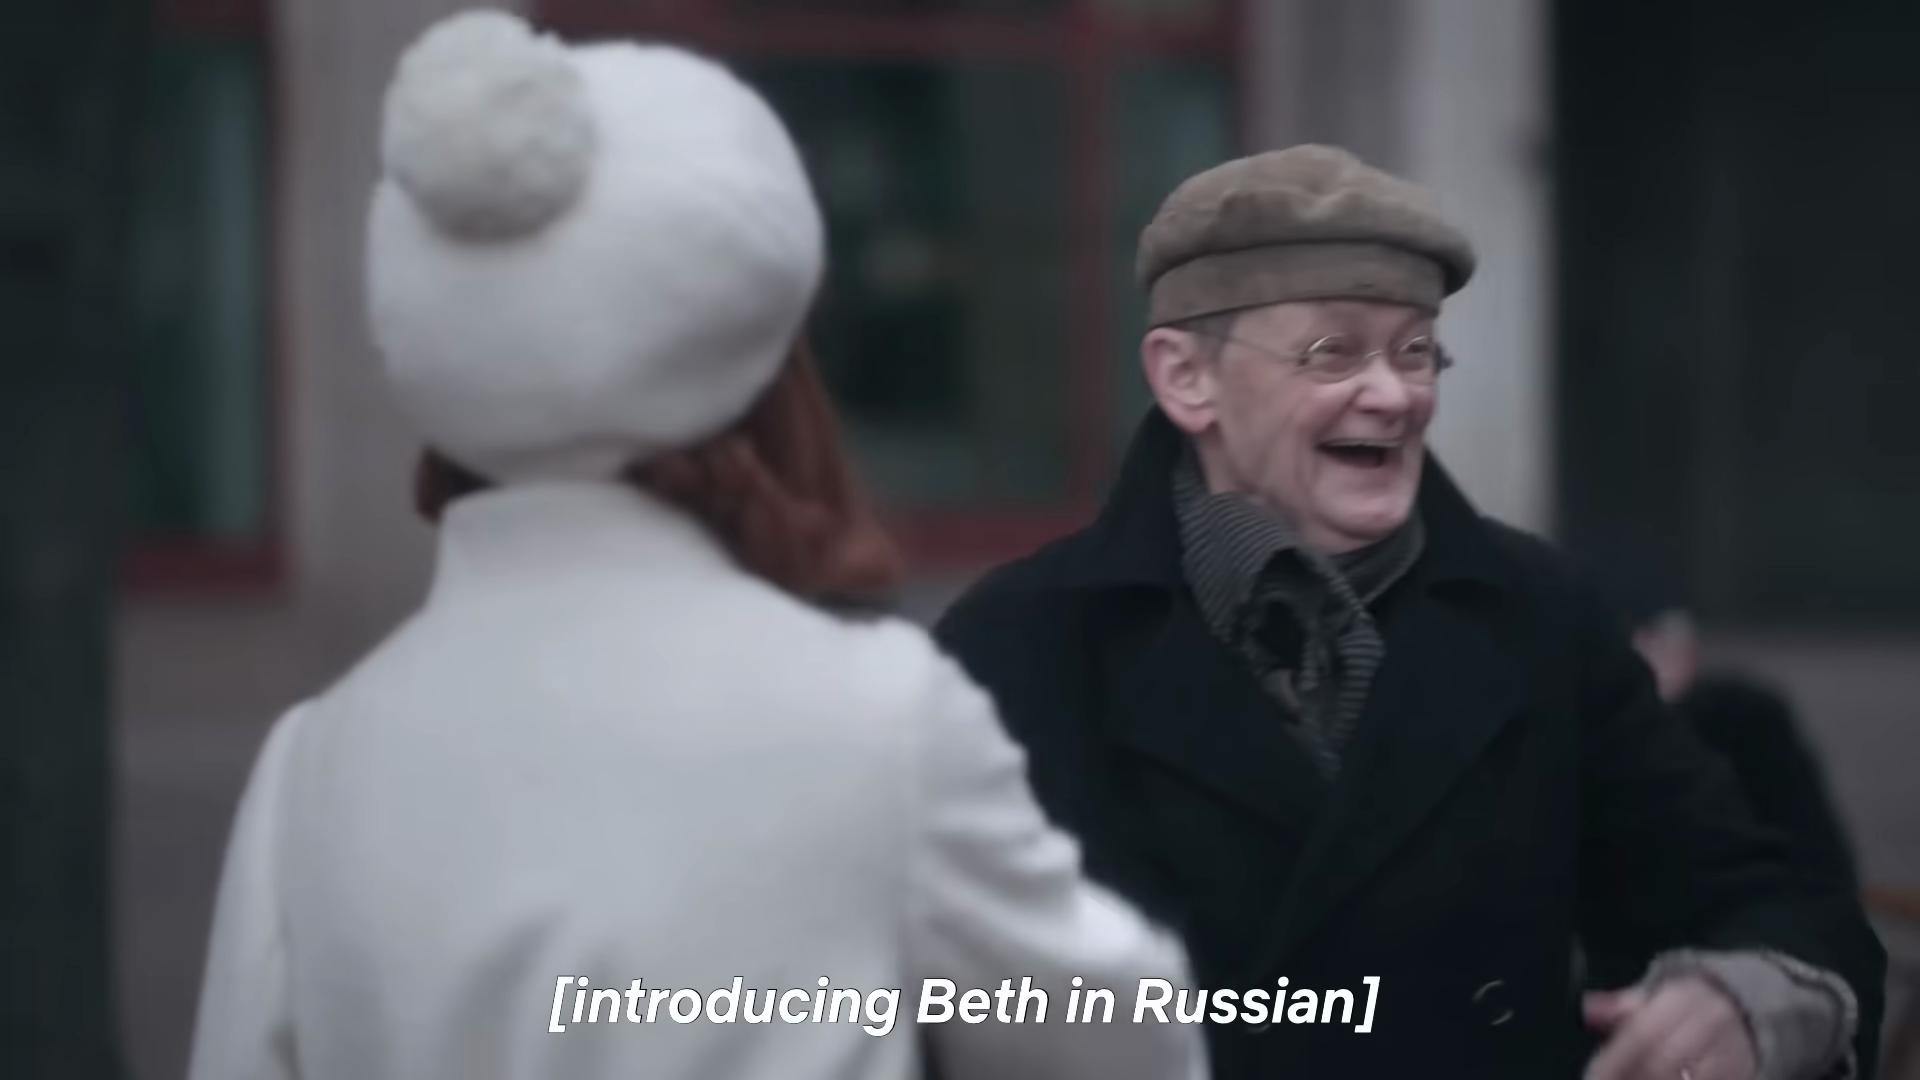
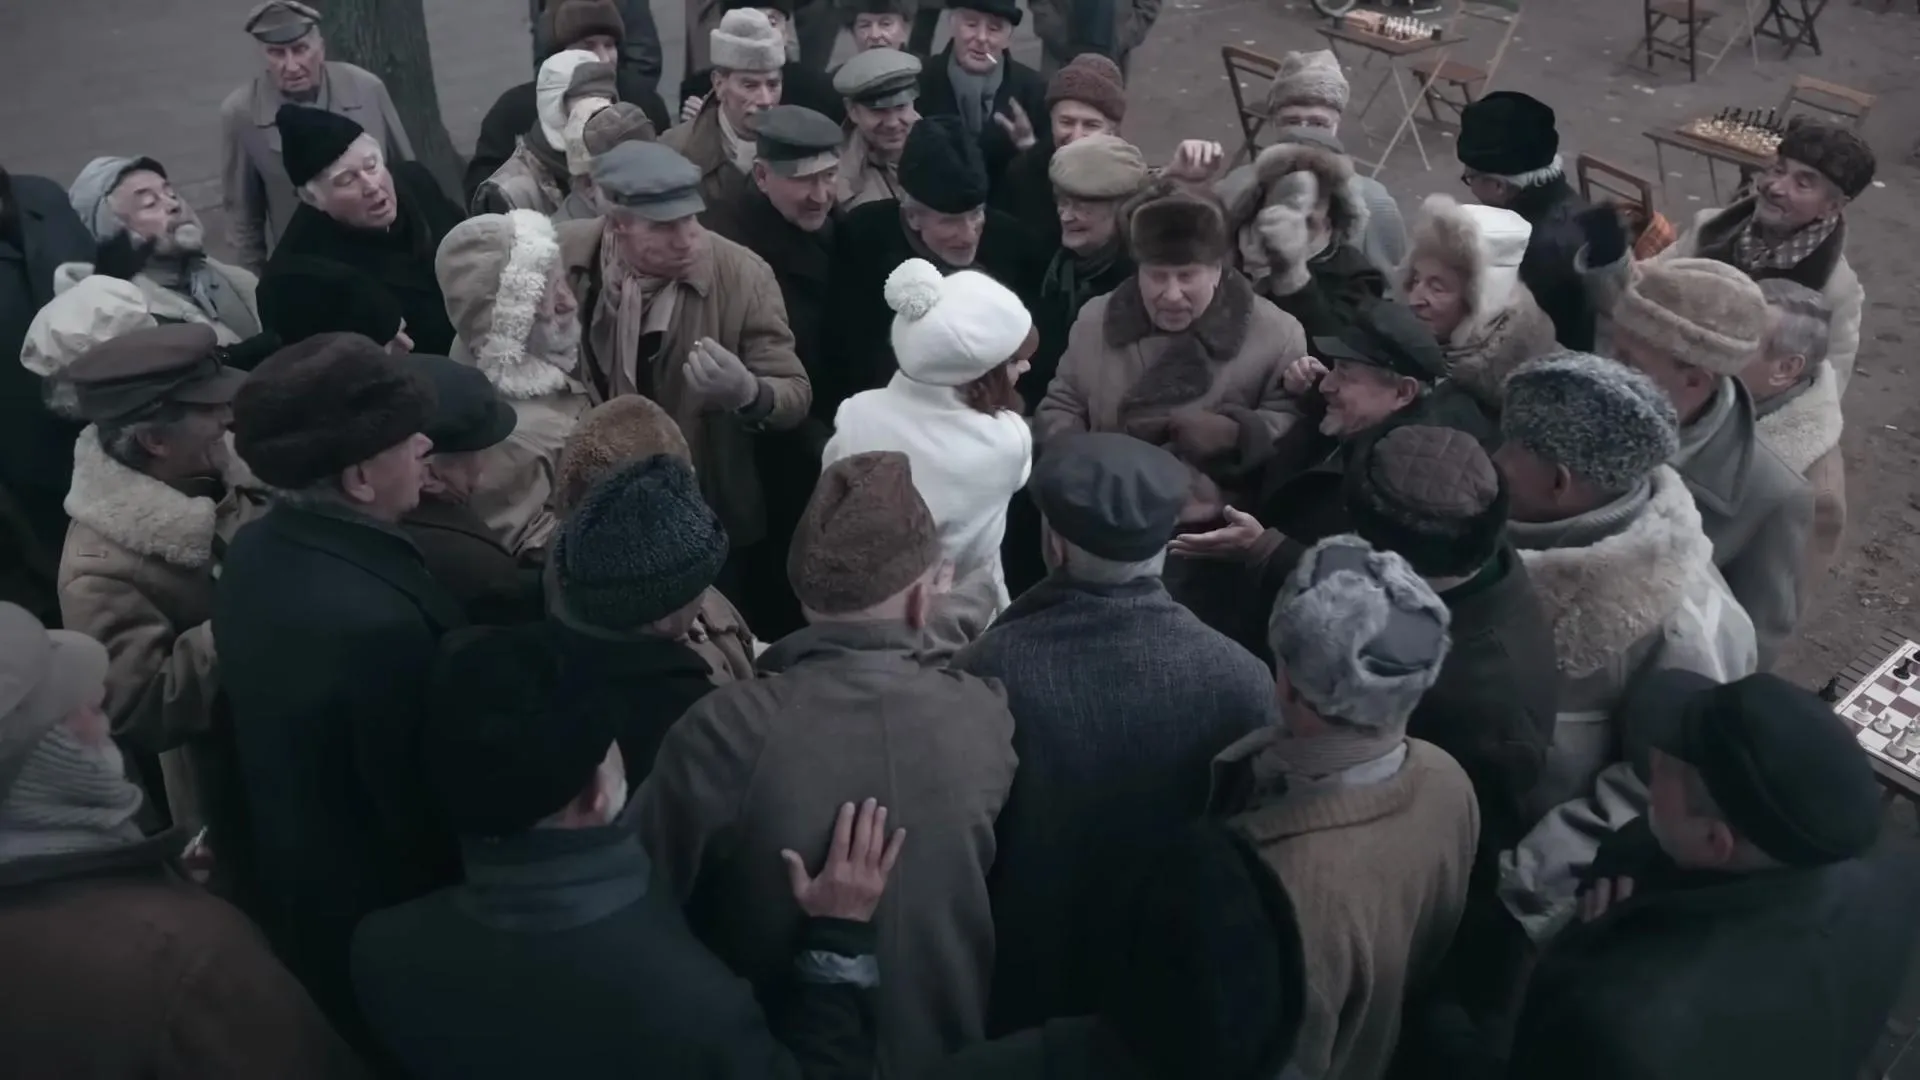
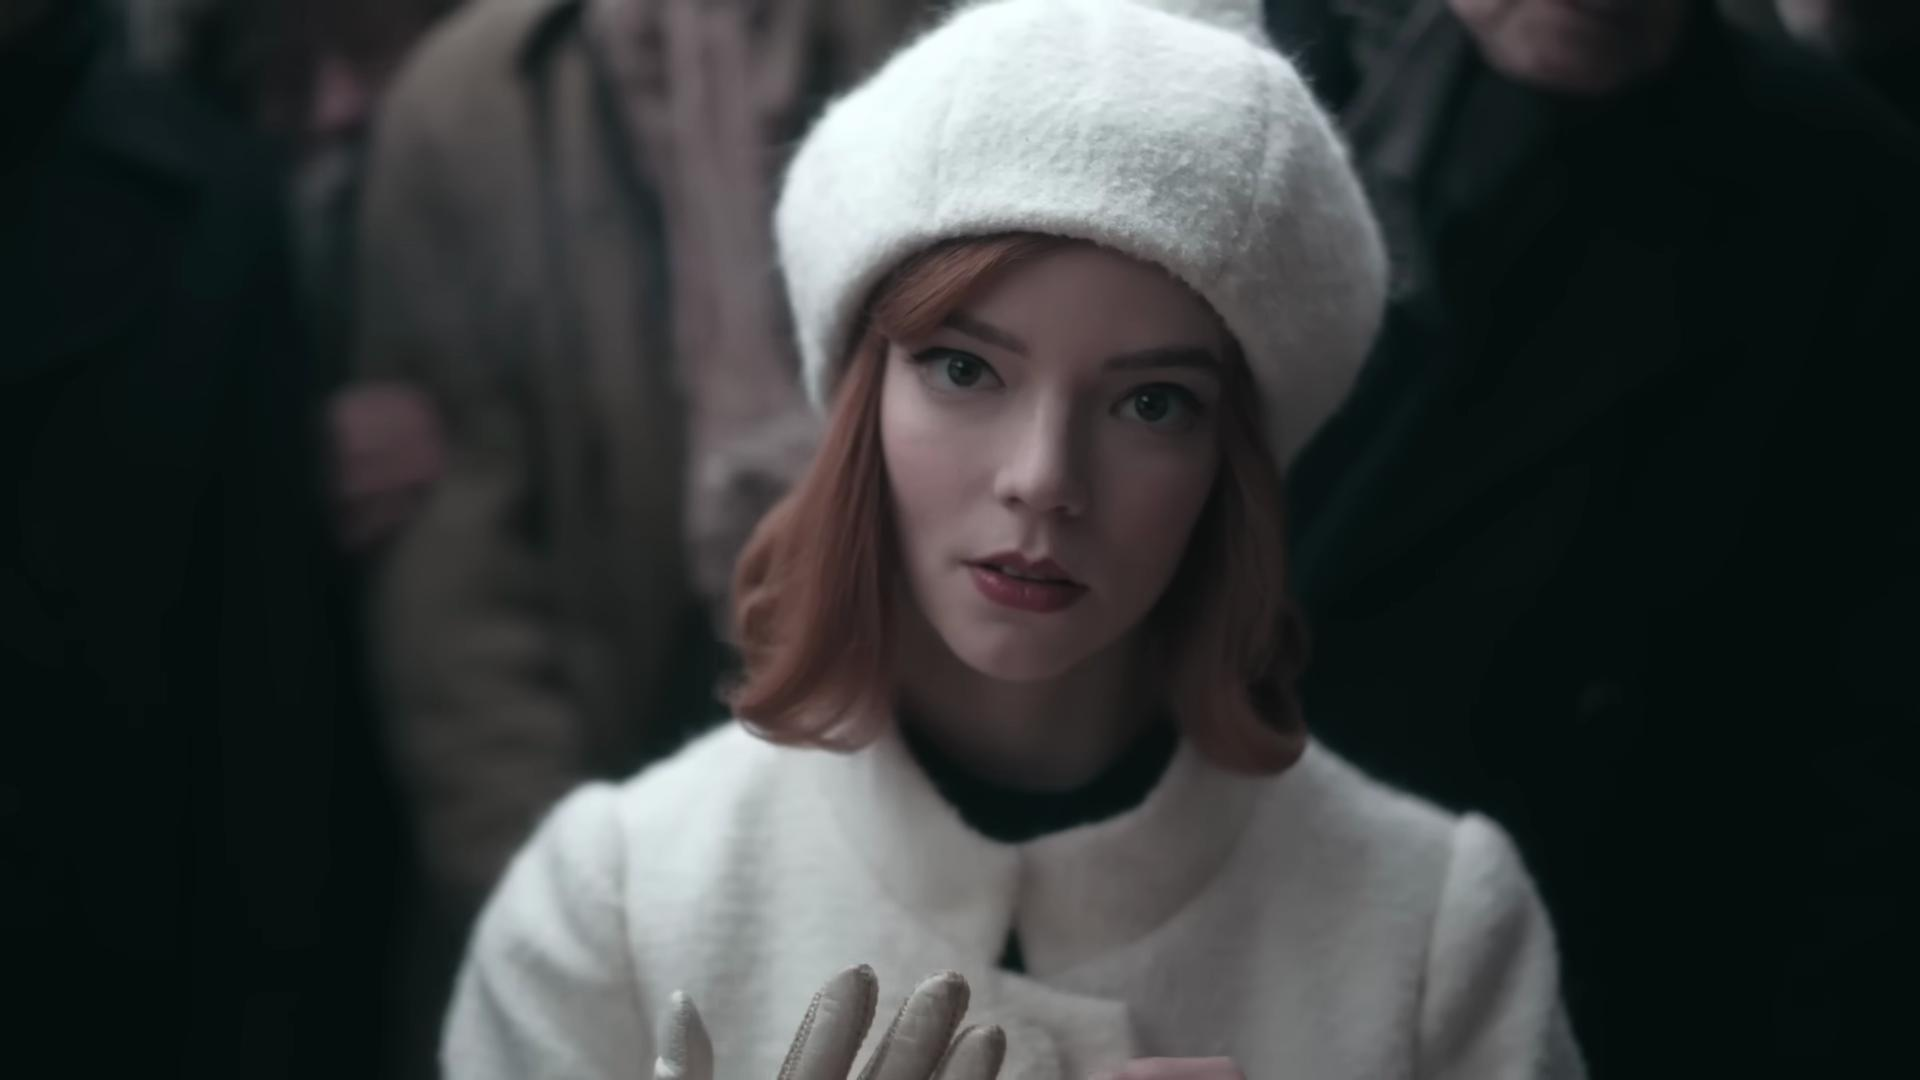
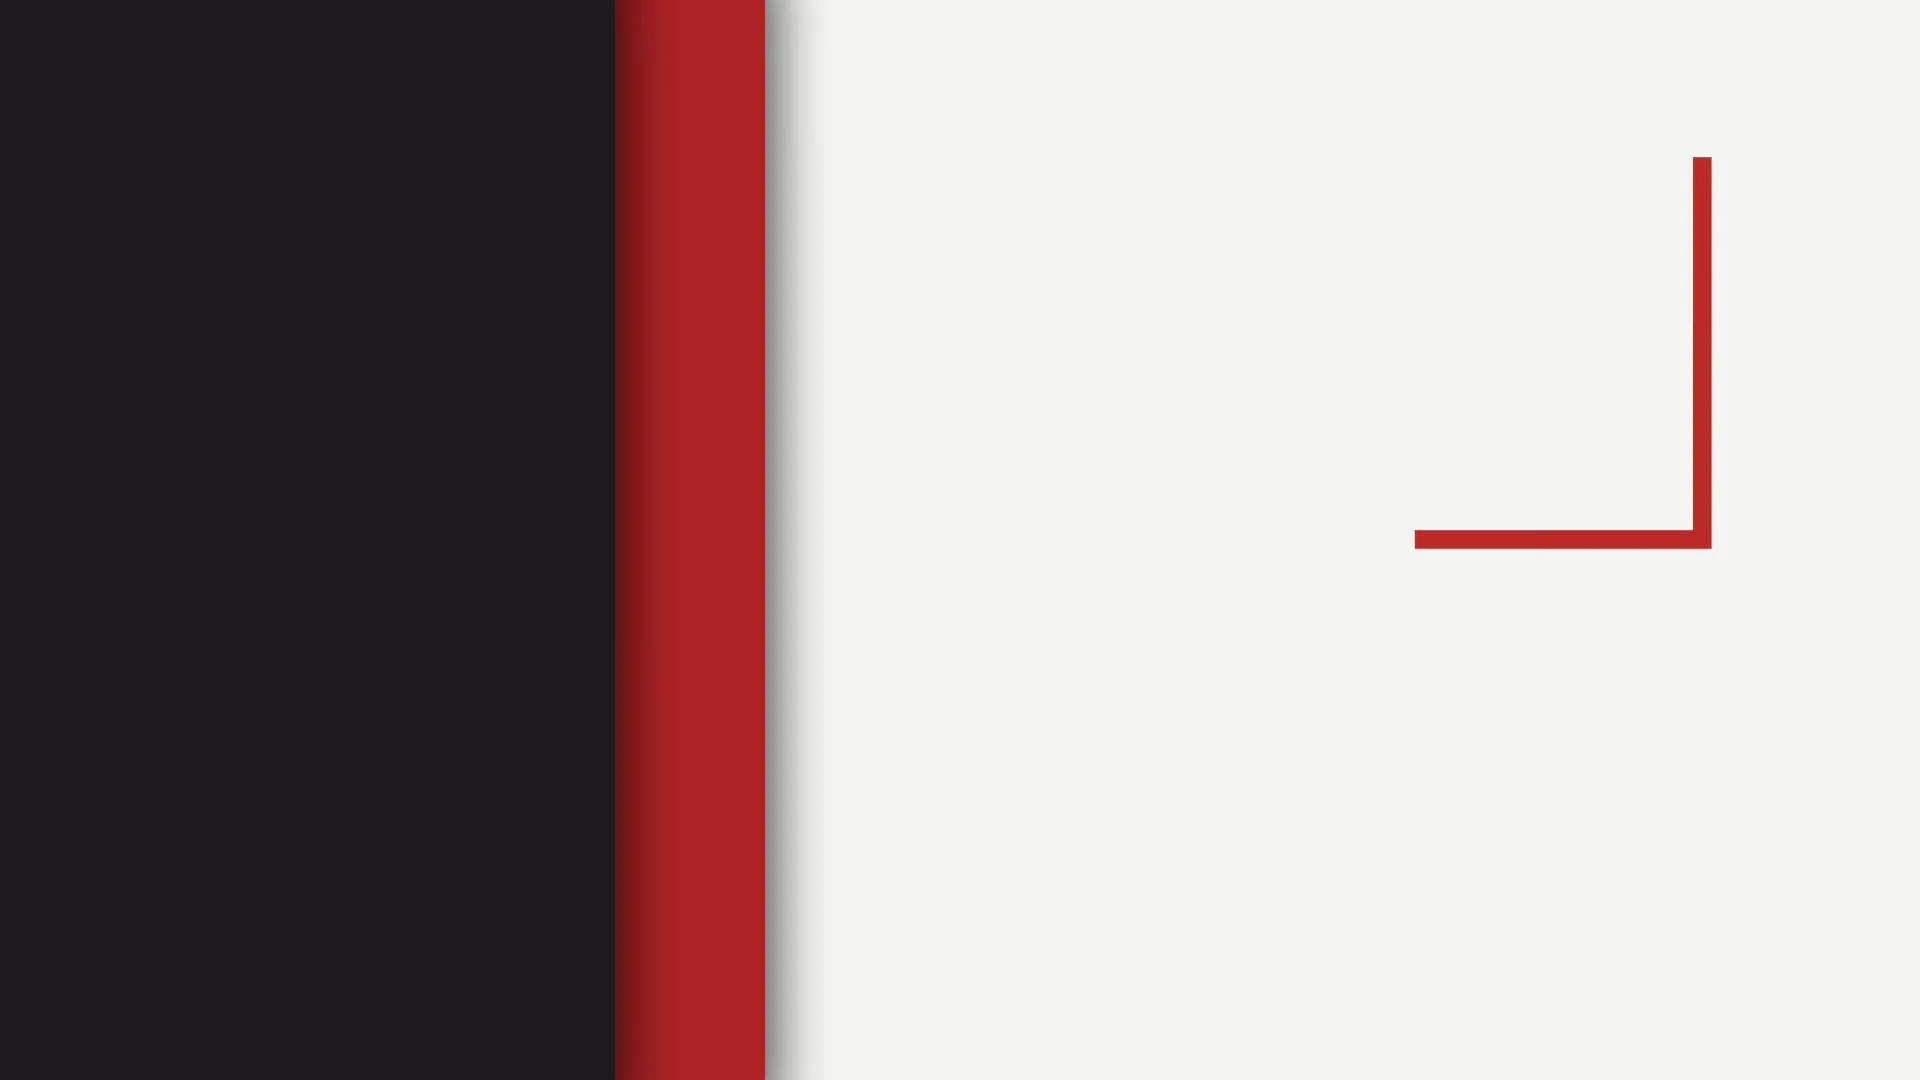

In [8]:
scenes.select(scenes.pos, scenes.video_segment, scenes.middle_frame).order_by(scenes.pos).collect()

**Step 2: Create embedding index on middle frames**

Now we'll create a searchable embedding index using CLIP to enable visual similarity search:

In [9]:
# Add CLIP embedding index on middle frames for similarity search
from pixeltable.functions.huggingface import clip

scenes.add_embedding_index(
    scenes.middle_frame,
    embedding=clip.using(model_id='openai/clip-vit-base-patch32'),
    if_exists='replace'
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
scenes

view 'scene_view' (of 'chess_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                      video_segment.extract_audio()
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang             Json                             transcription.language
       middle_frame            Image  video_segment.extract_frame(timestamp=video_se...
              video            Video                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

 Index Name        Column  Metric                                          Embedding
       idx3  middle_frame  cosine  clip(middle_frame, model_id='openai/clip-vit-b...

**Step 3: Extract a query frame and find similar scenes**

Now we can use the embedding index to find visually similar scenes. You can use any image as a query - it doesn't have to be a middle frame. Here we'll use a middle frame for convenience, but you could extract any frame from any scene or video segment.


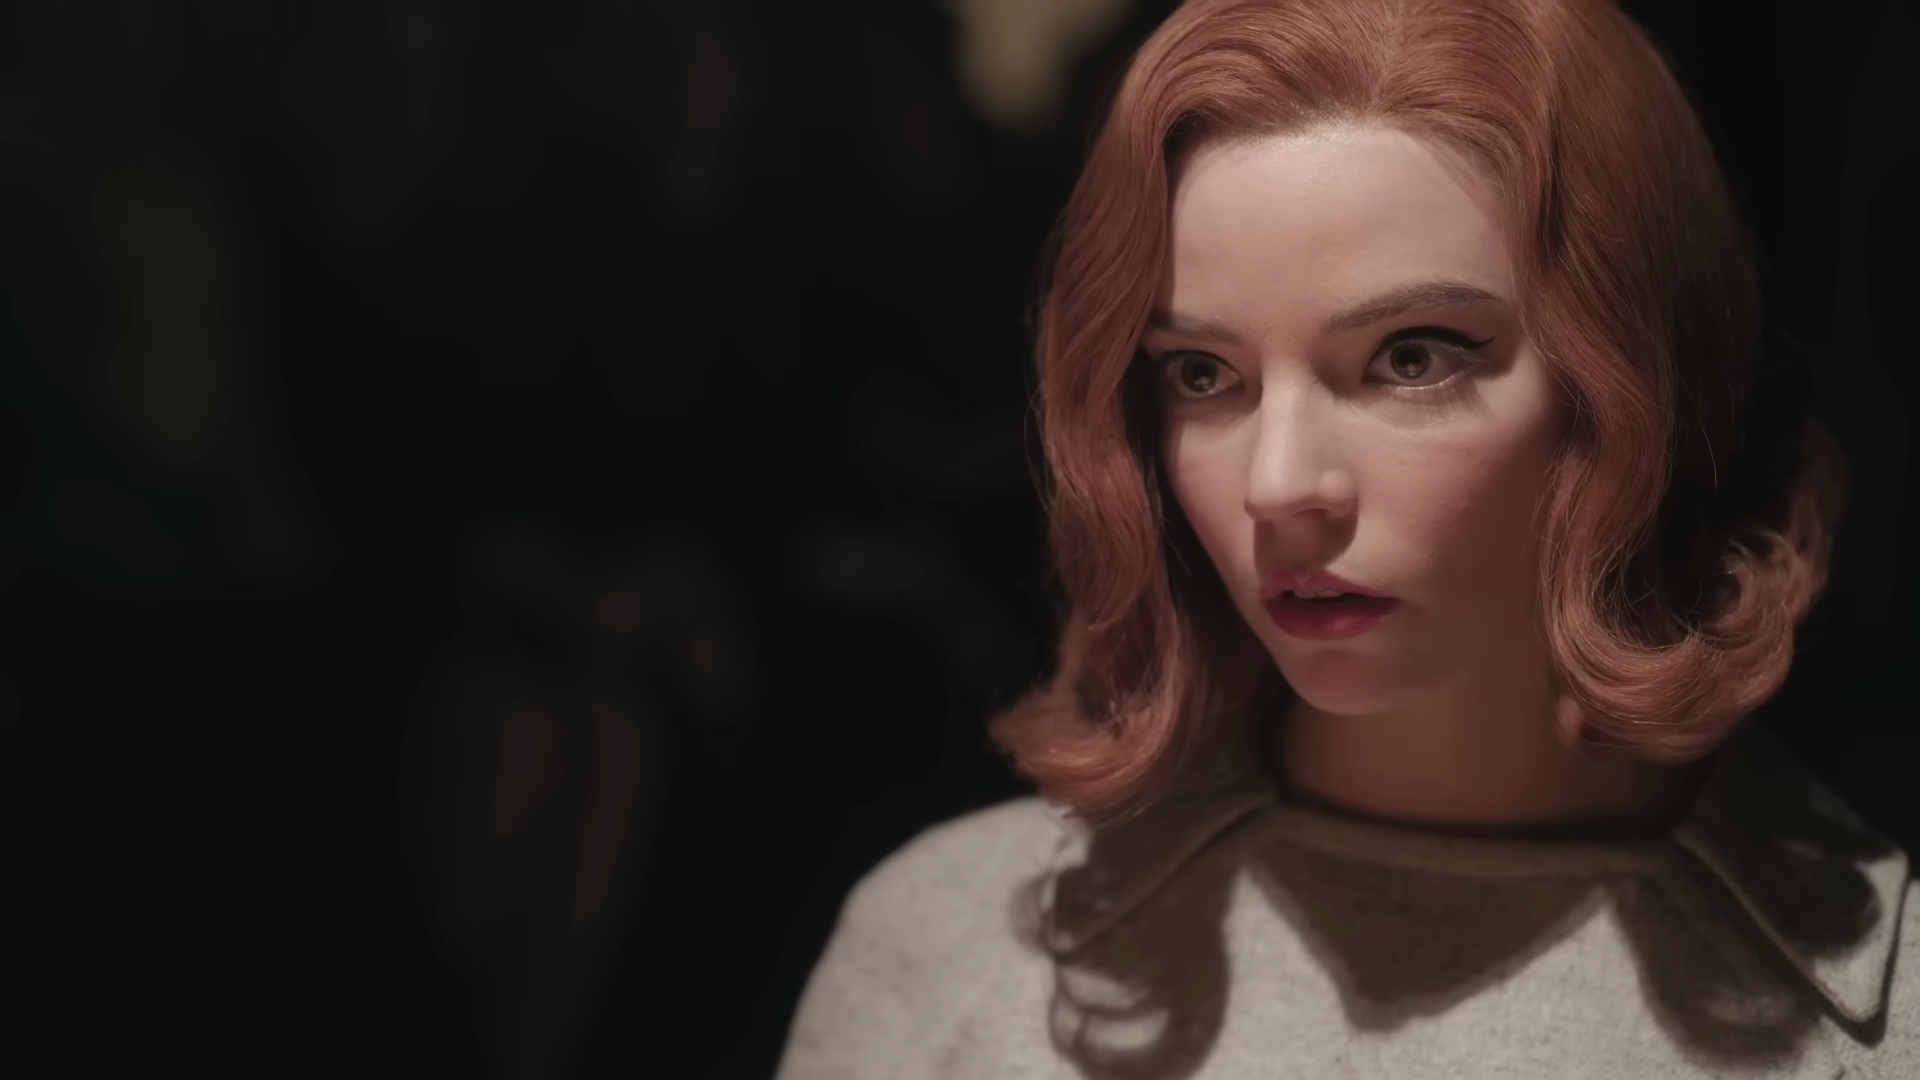

In [ ]:
# Extract a query frame
scene_index = 0  # 0 = first scene, 1 = second scene, 2 = third scene, etc.
# fix this, use a where clause 
query_frame = scenes.select(scenes.video_segment.extract_frame(timestamp=16)).head()[scene_index, 0]

query_frame

**Step 4: Find similar scenes using the embedding index**

Now we'll use the embedding index to find the top 5 scenes with middle frames most similar to our query frame:


pos                                       middle_frame  \
0    5  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1    3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2    2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3    4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4    6  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                       video_segment  similarity  
0  /Users/alison-pxt/.pixeltable/media/4d56b426a8...    0.765724  
1  /Users/alison-pxt/.pixeltable/media/4d56b426a8...    0.717418  
2  /Users/alison-pxt/.pixeltable/media/4d56b426a8...    0.709815  
3  /Users/alison-pxt/.pixeltable/media/4d56b426a8...    0.708916  
4  /Users/alison-pxt/.pixeltable/media/4d56b426a8...    0.673435
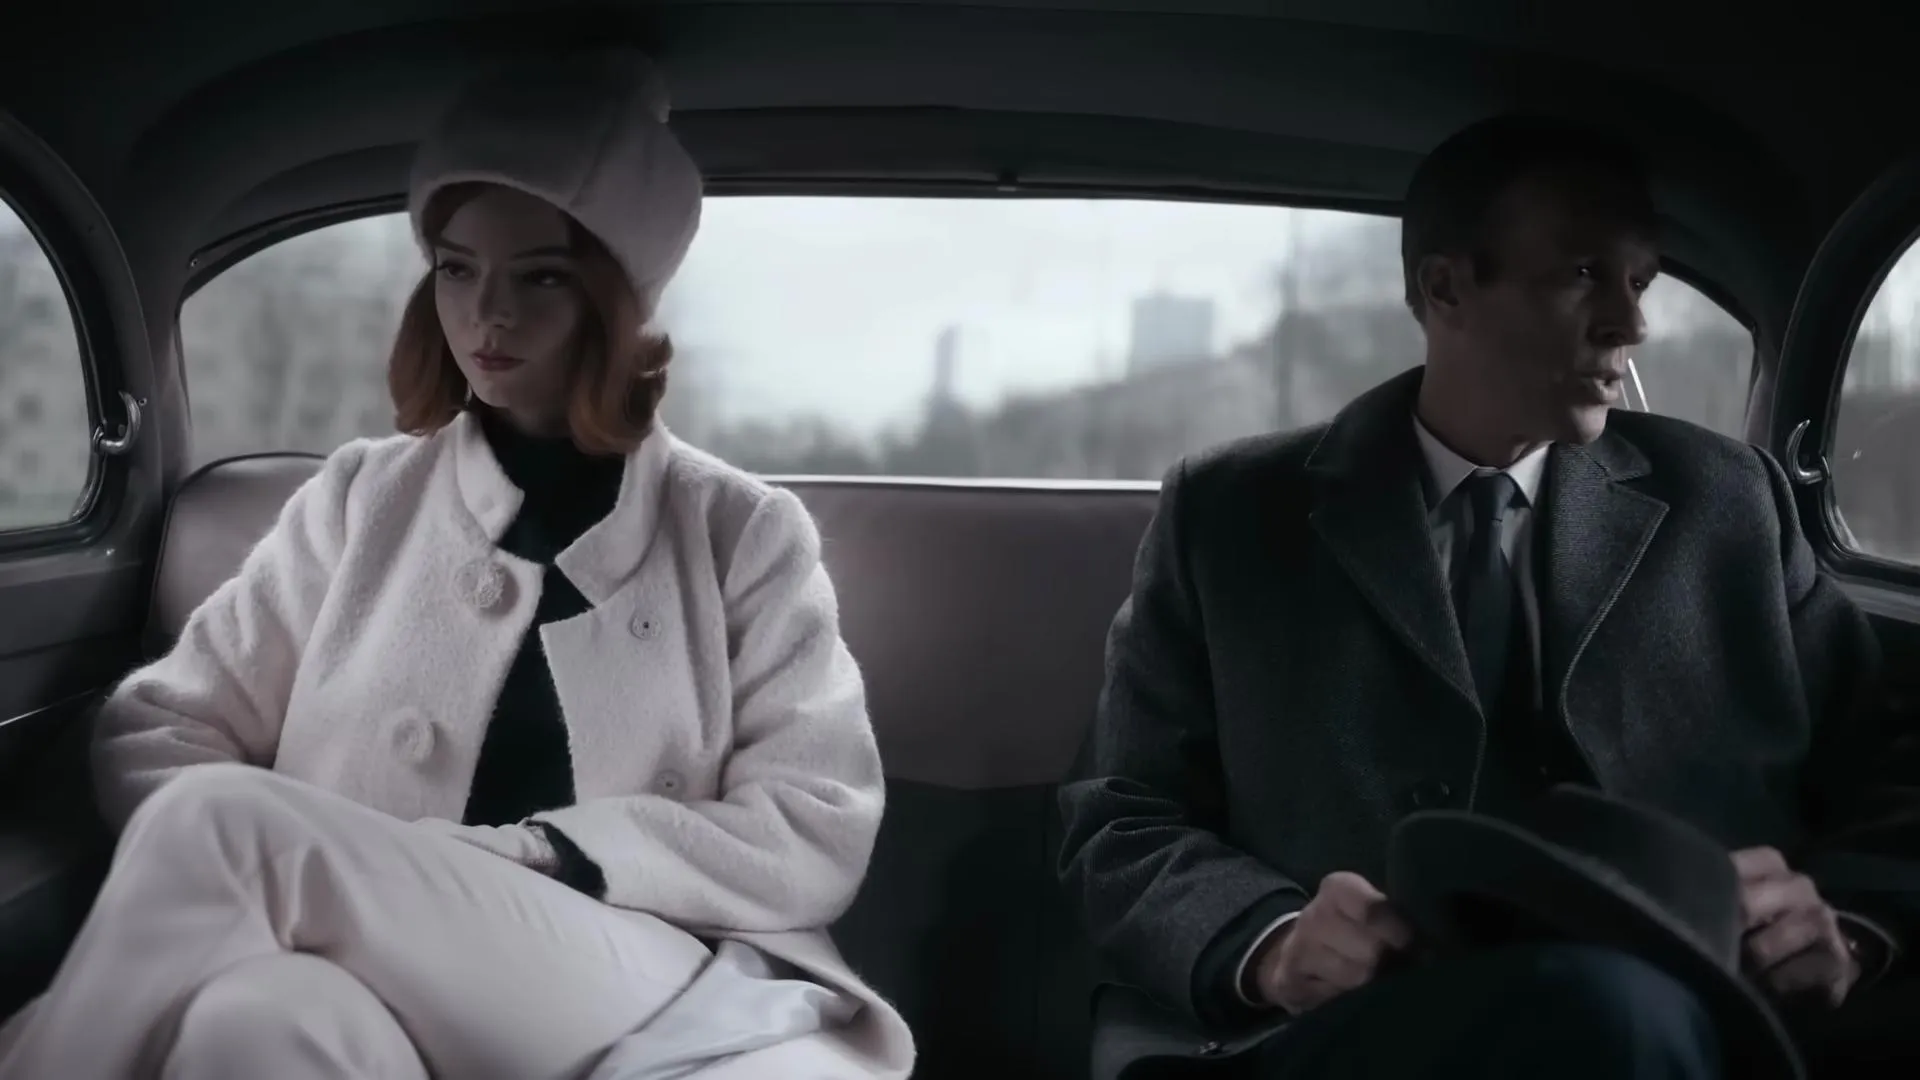
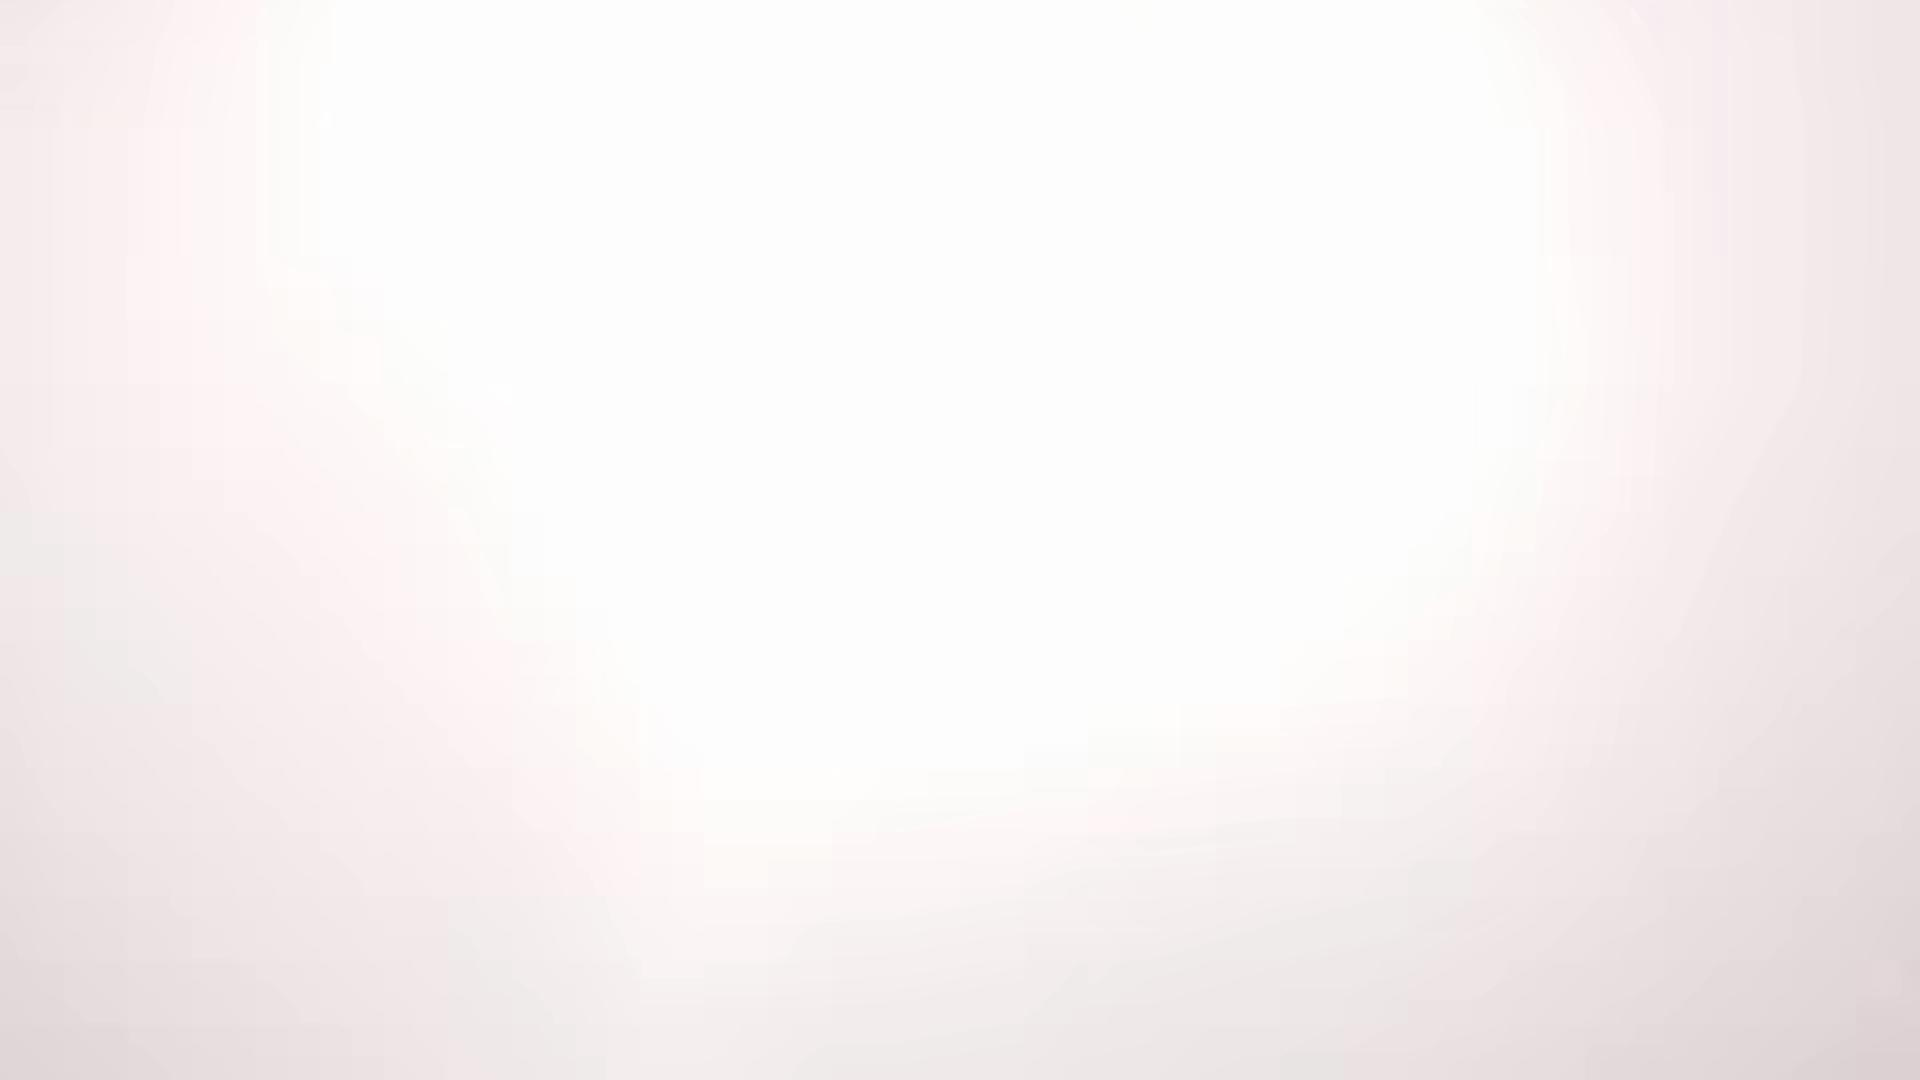
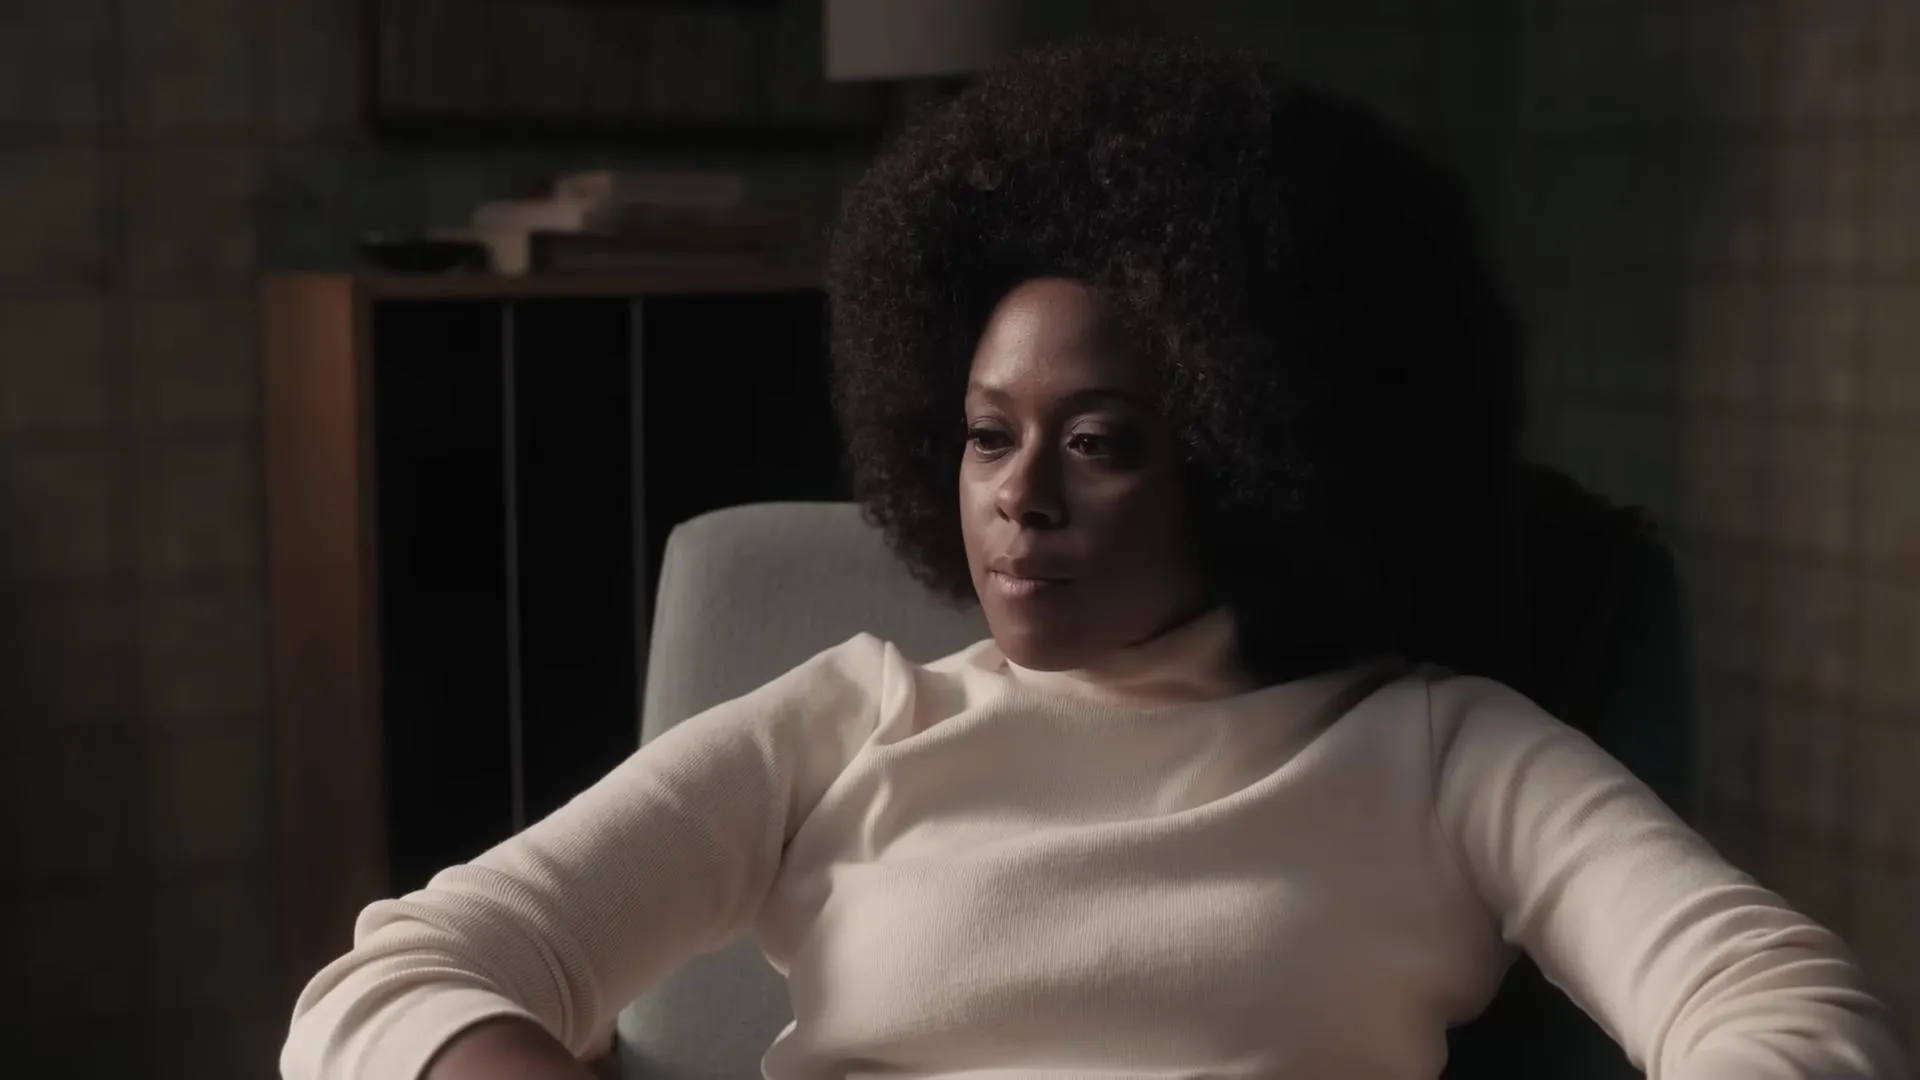
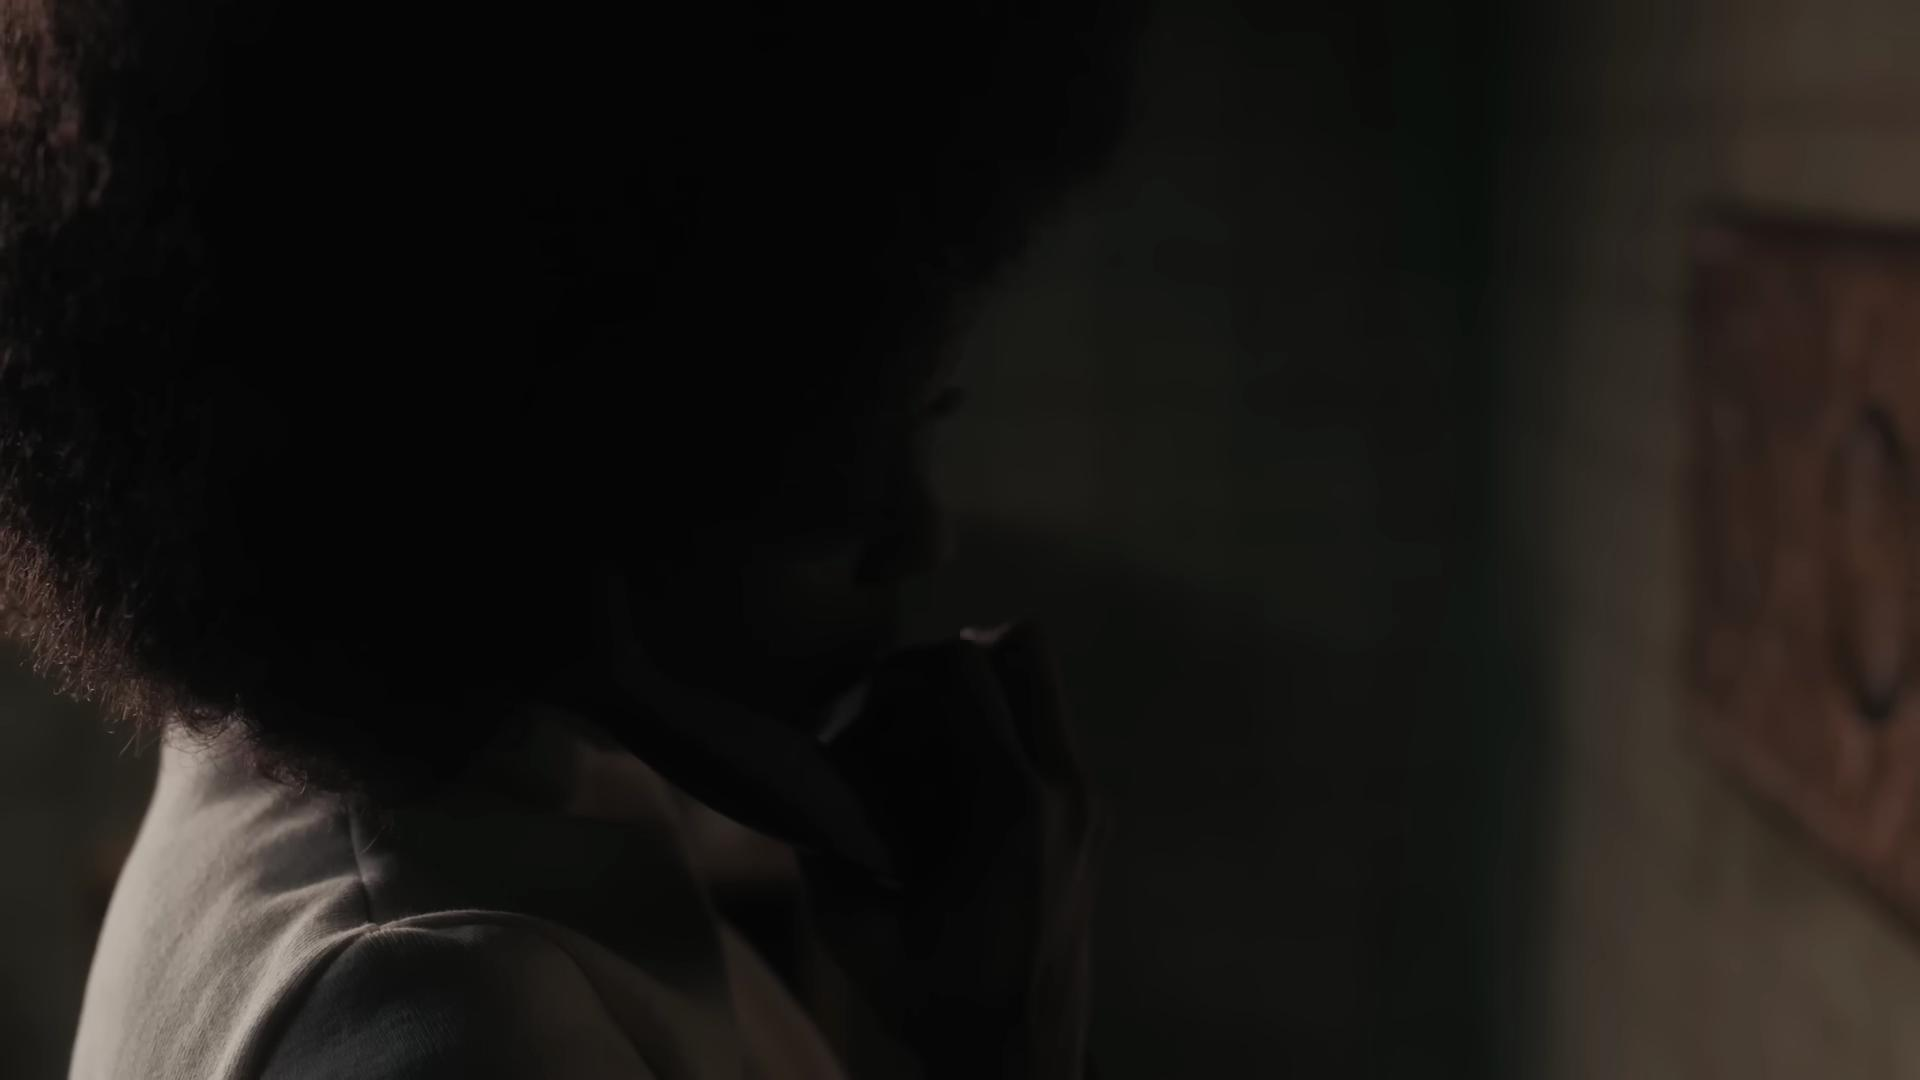
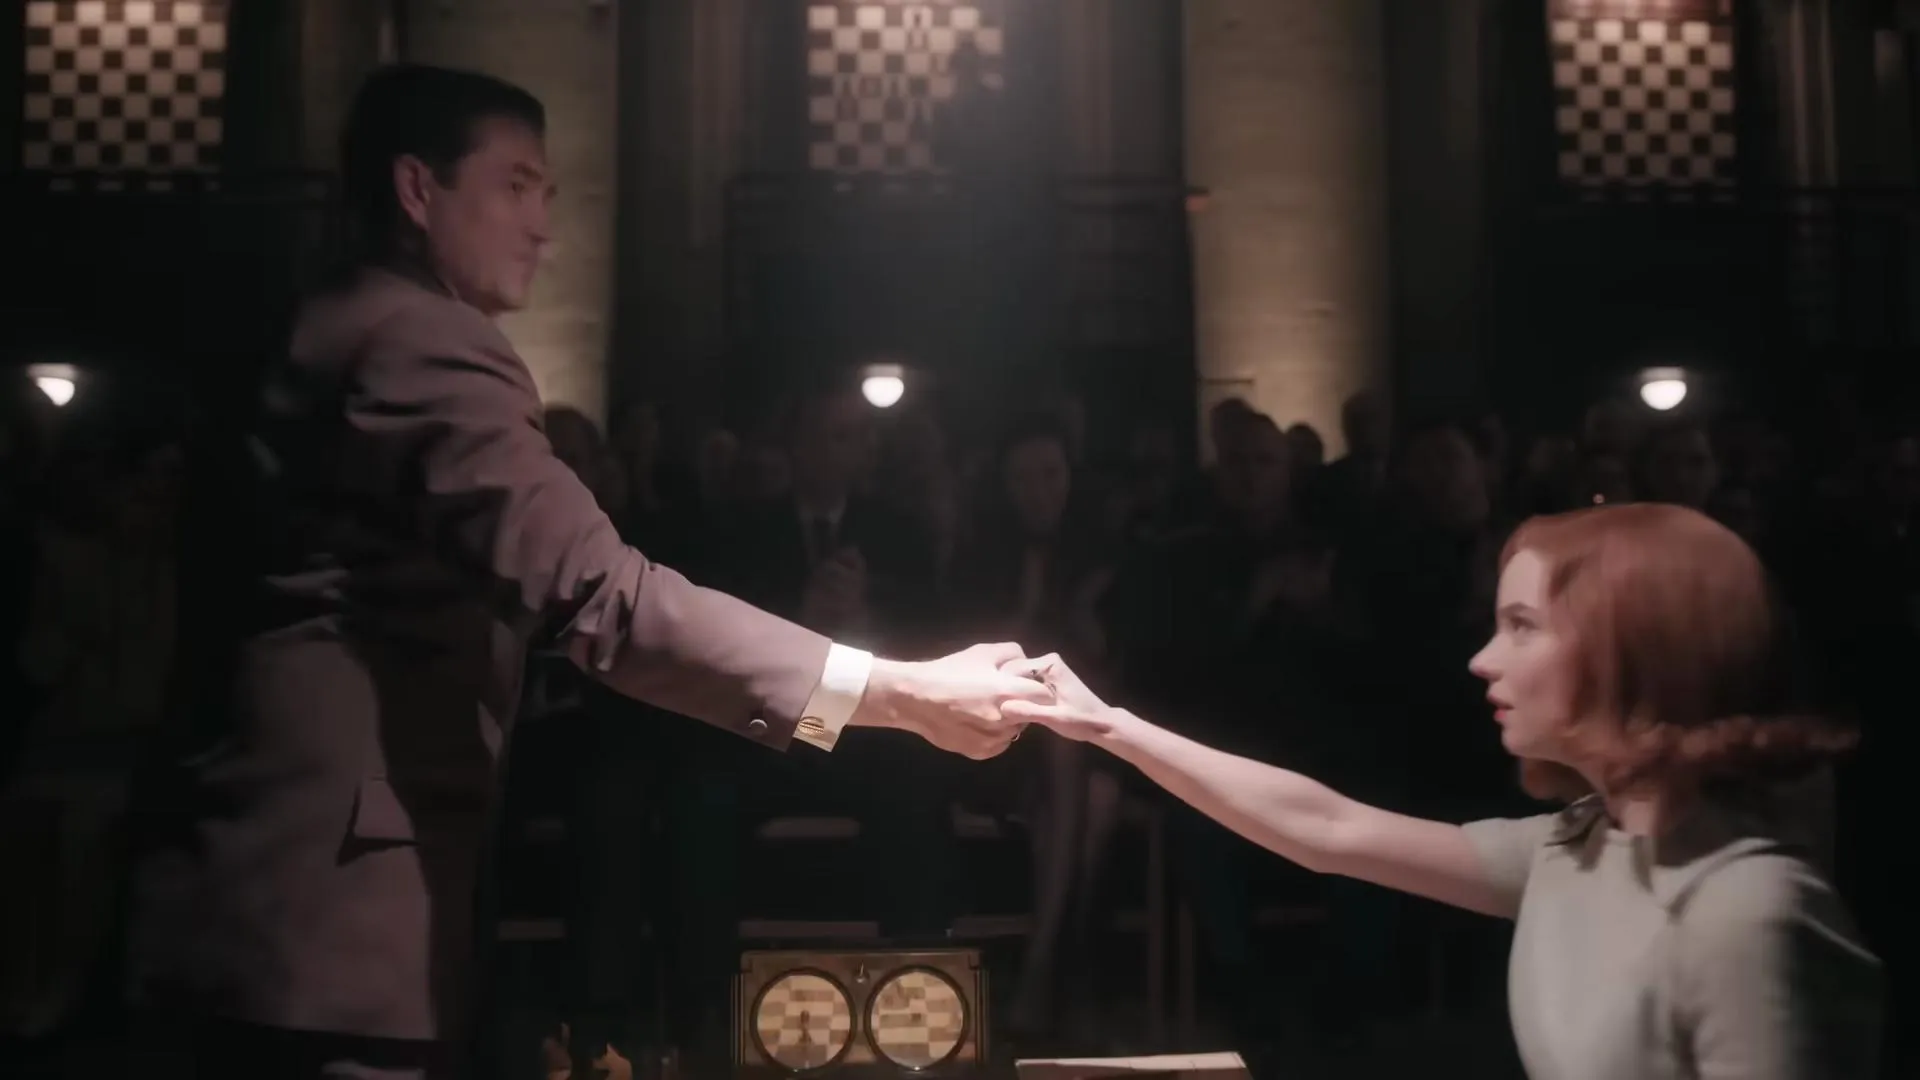
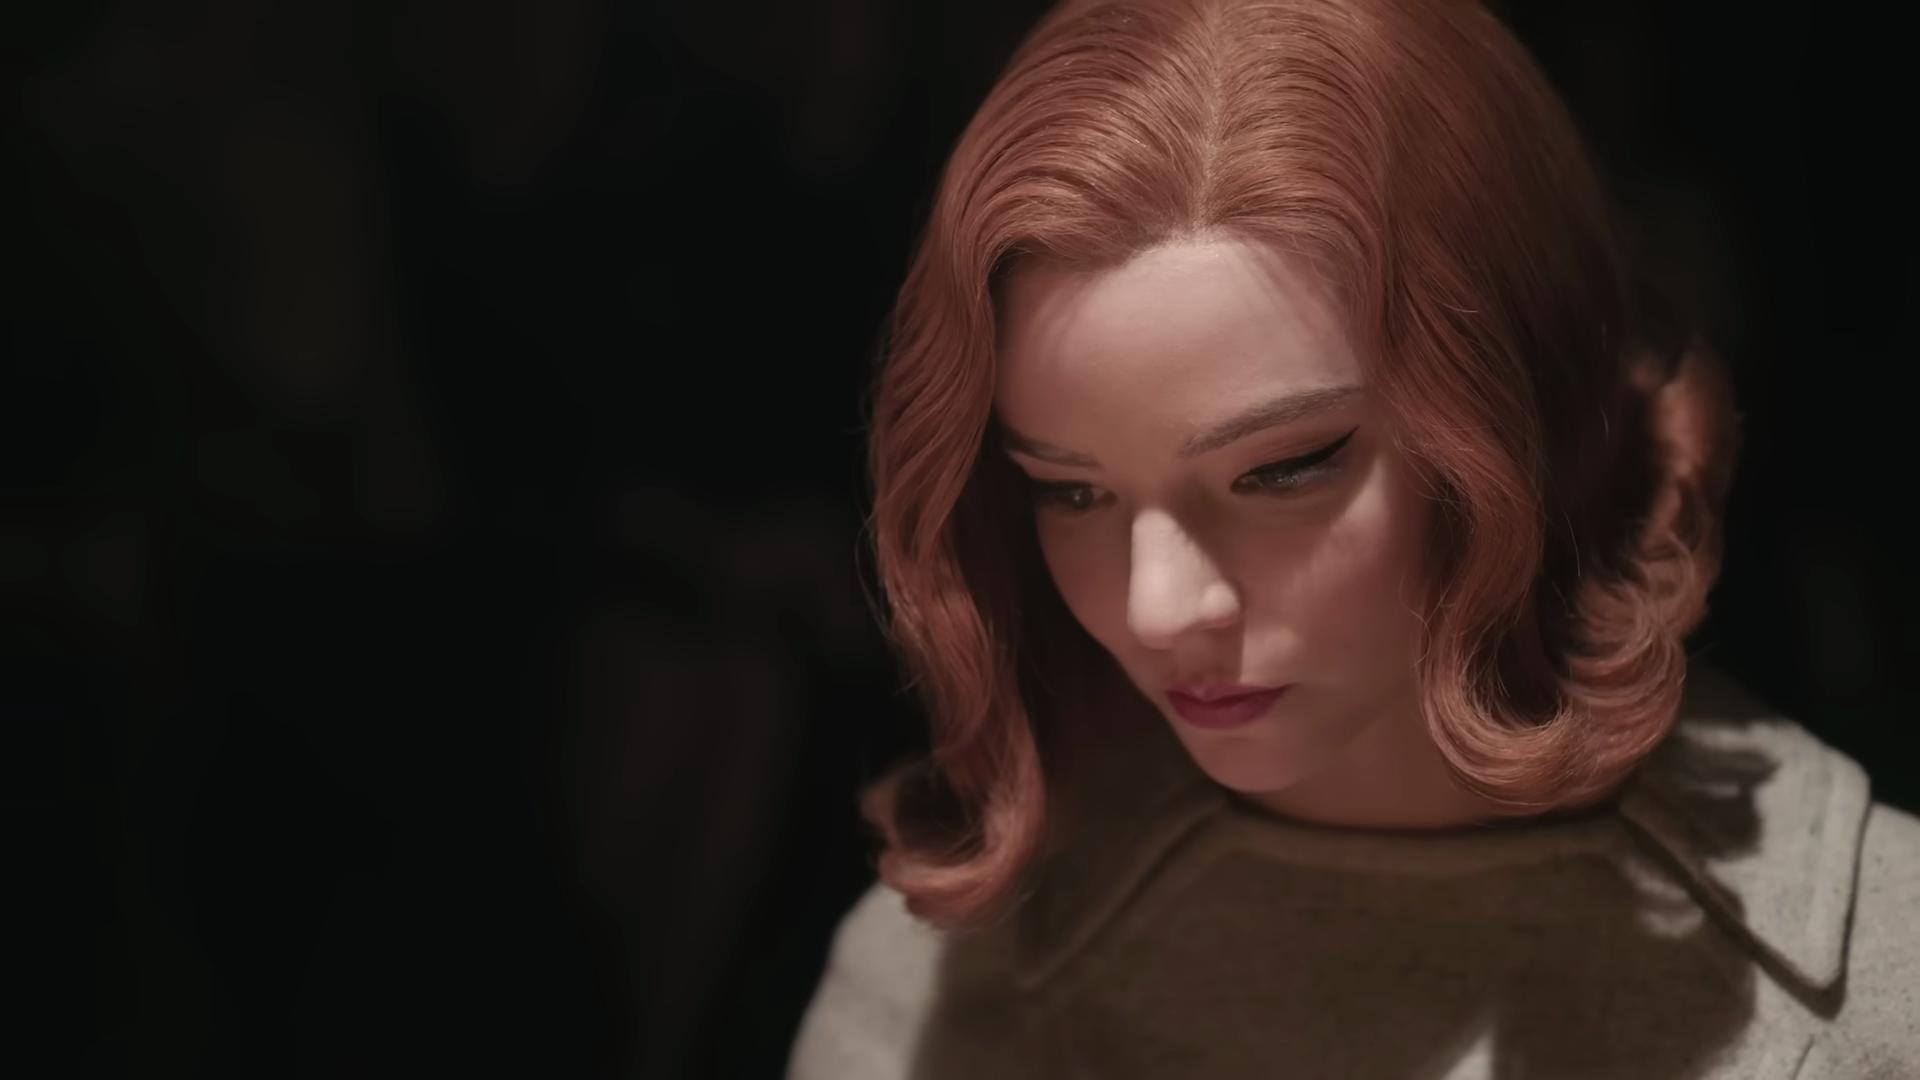
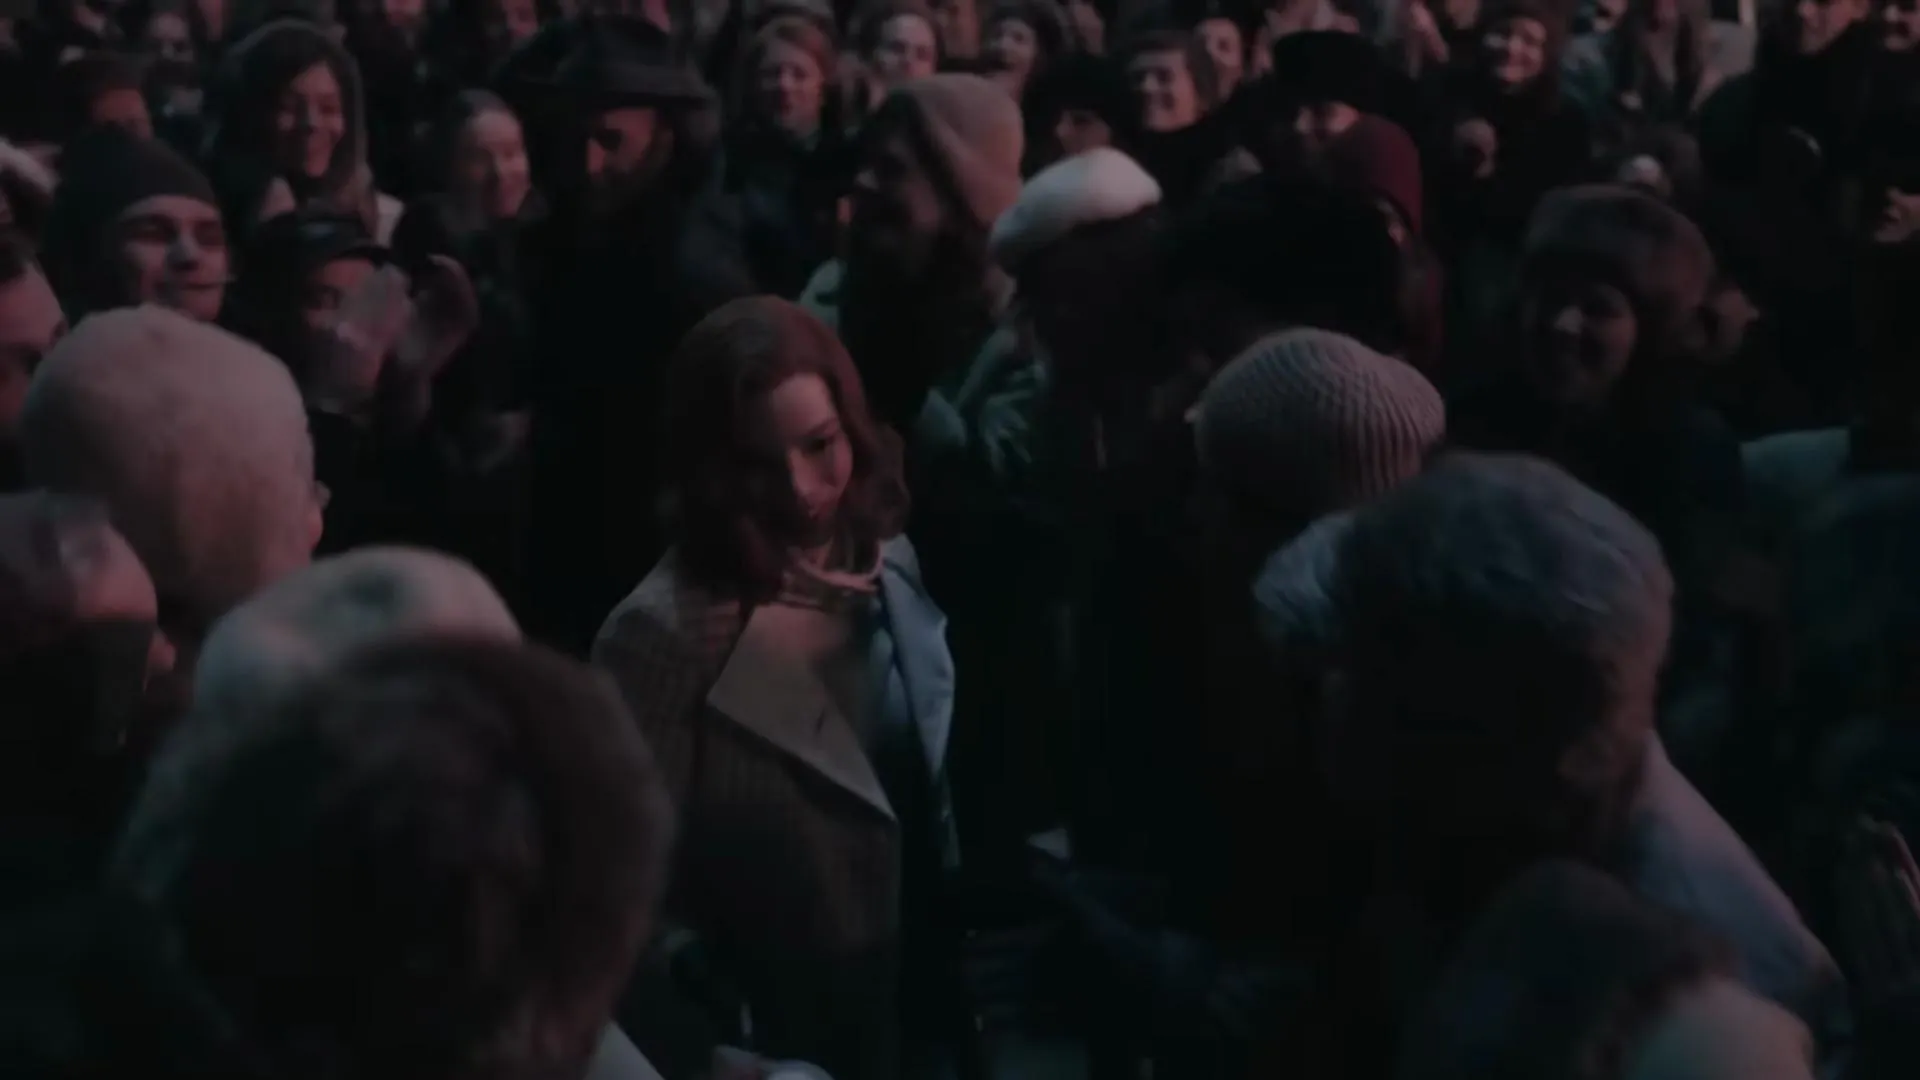
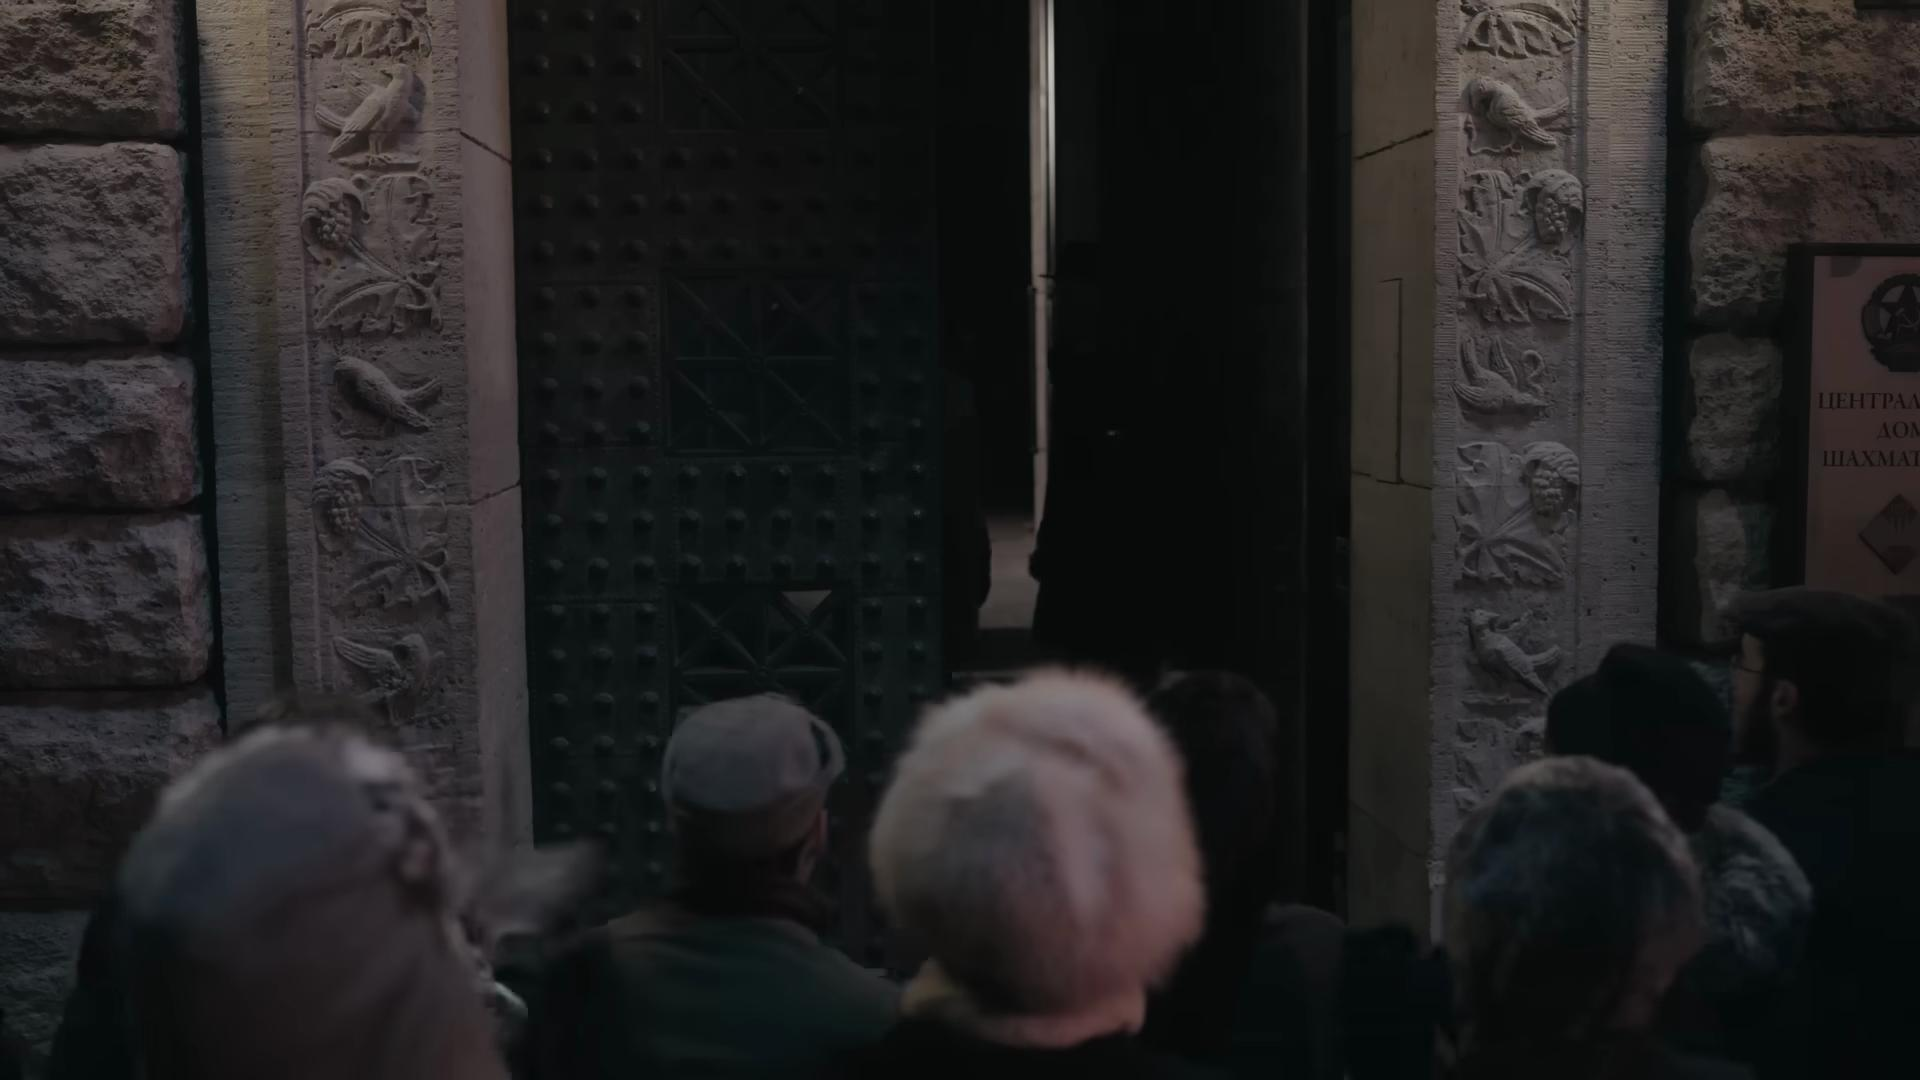
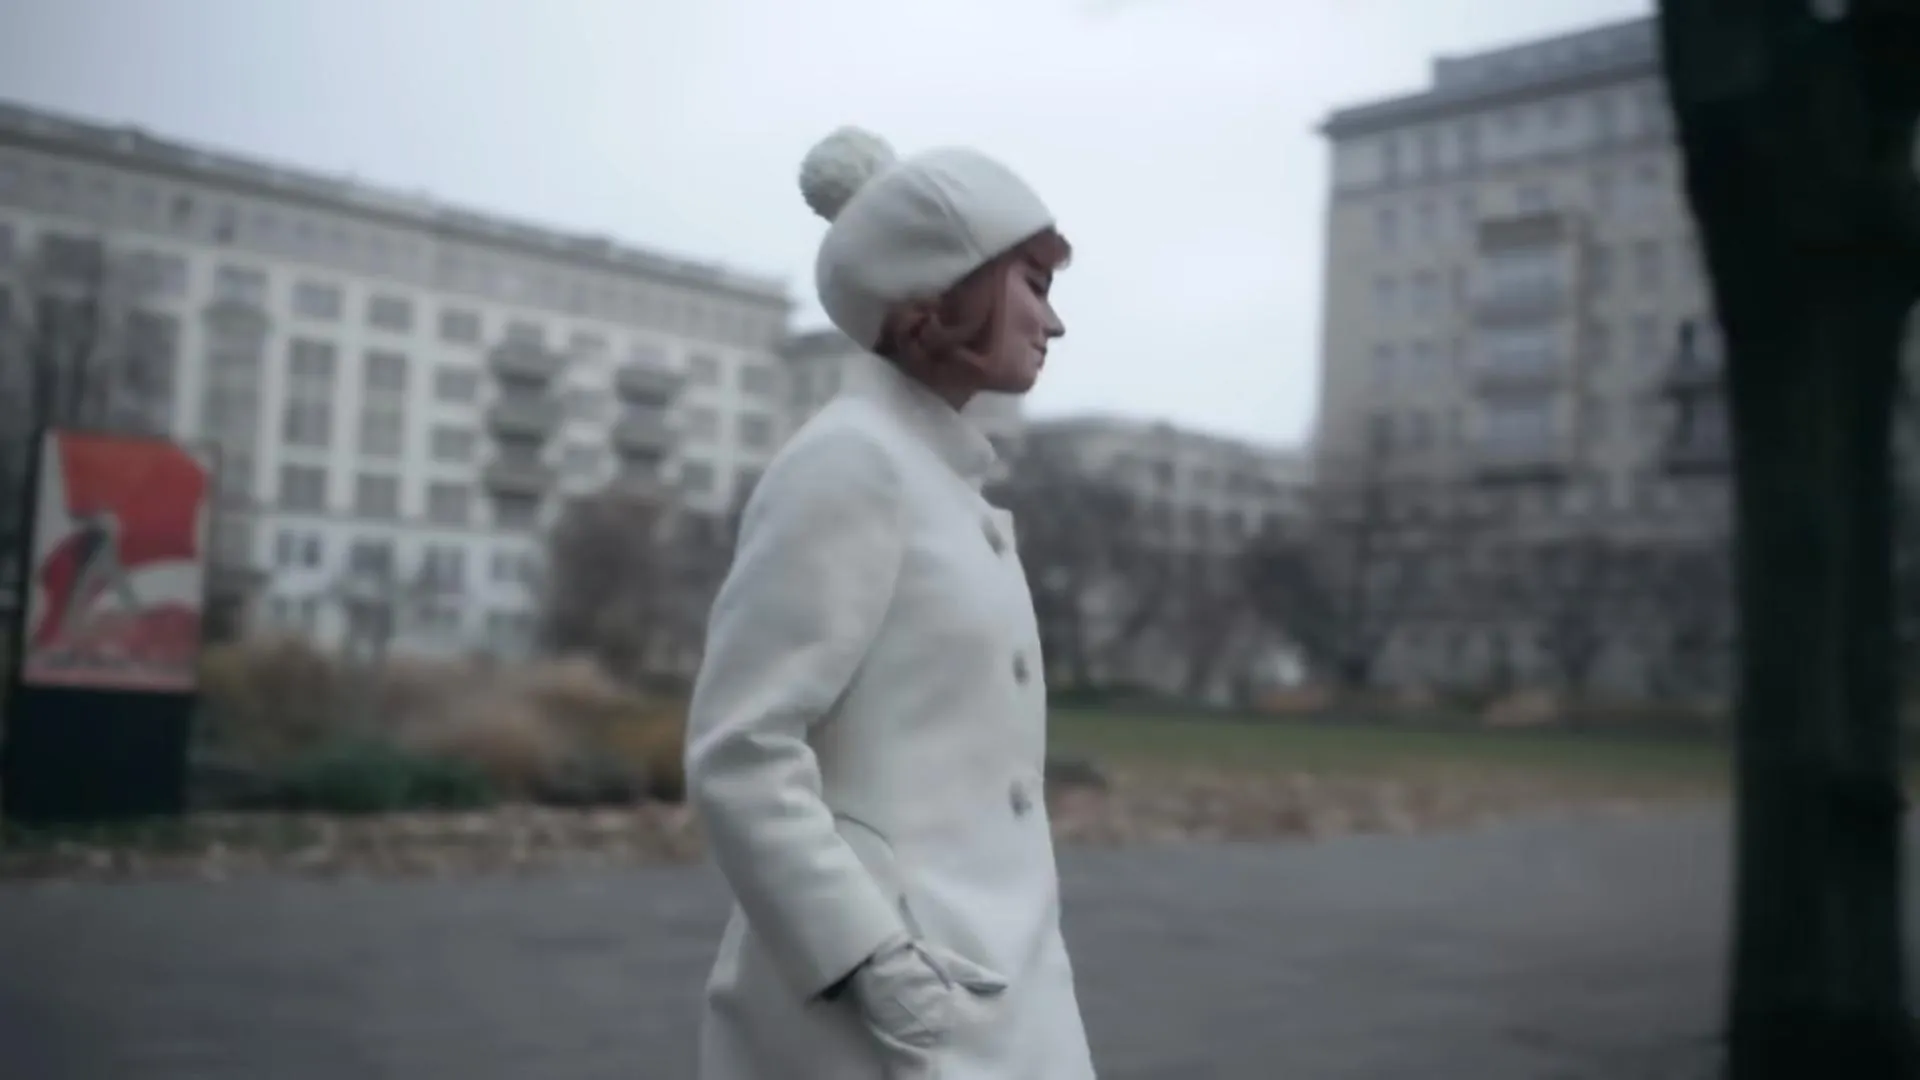
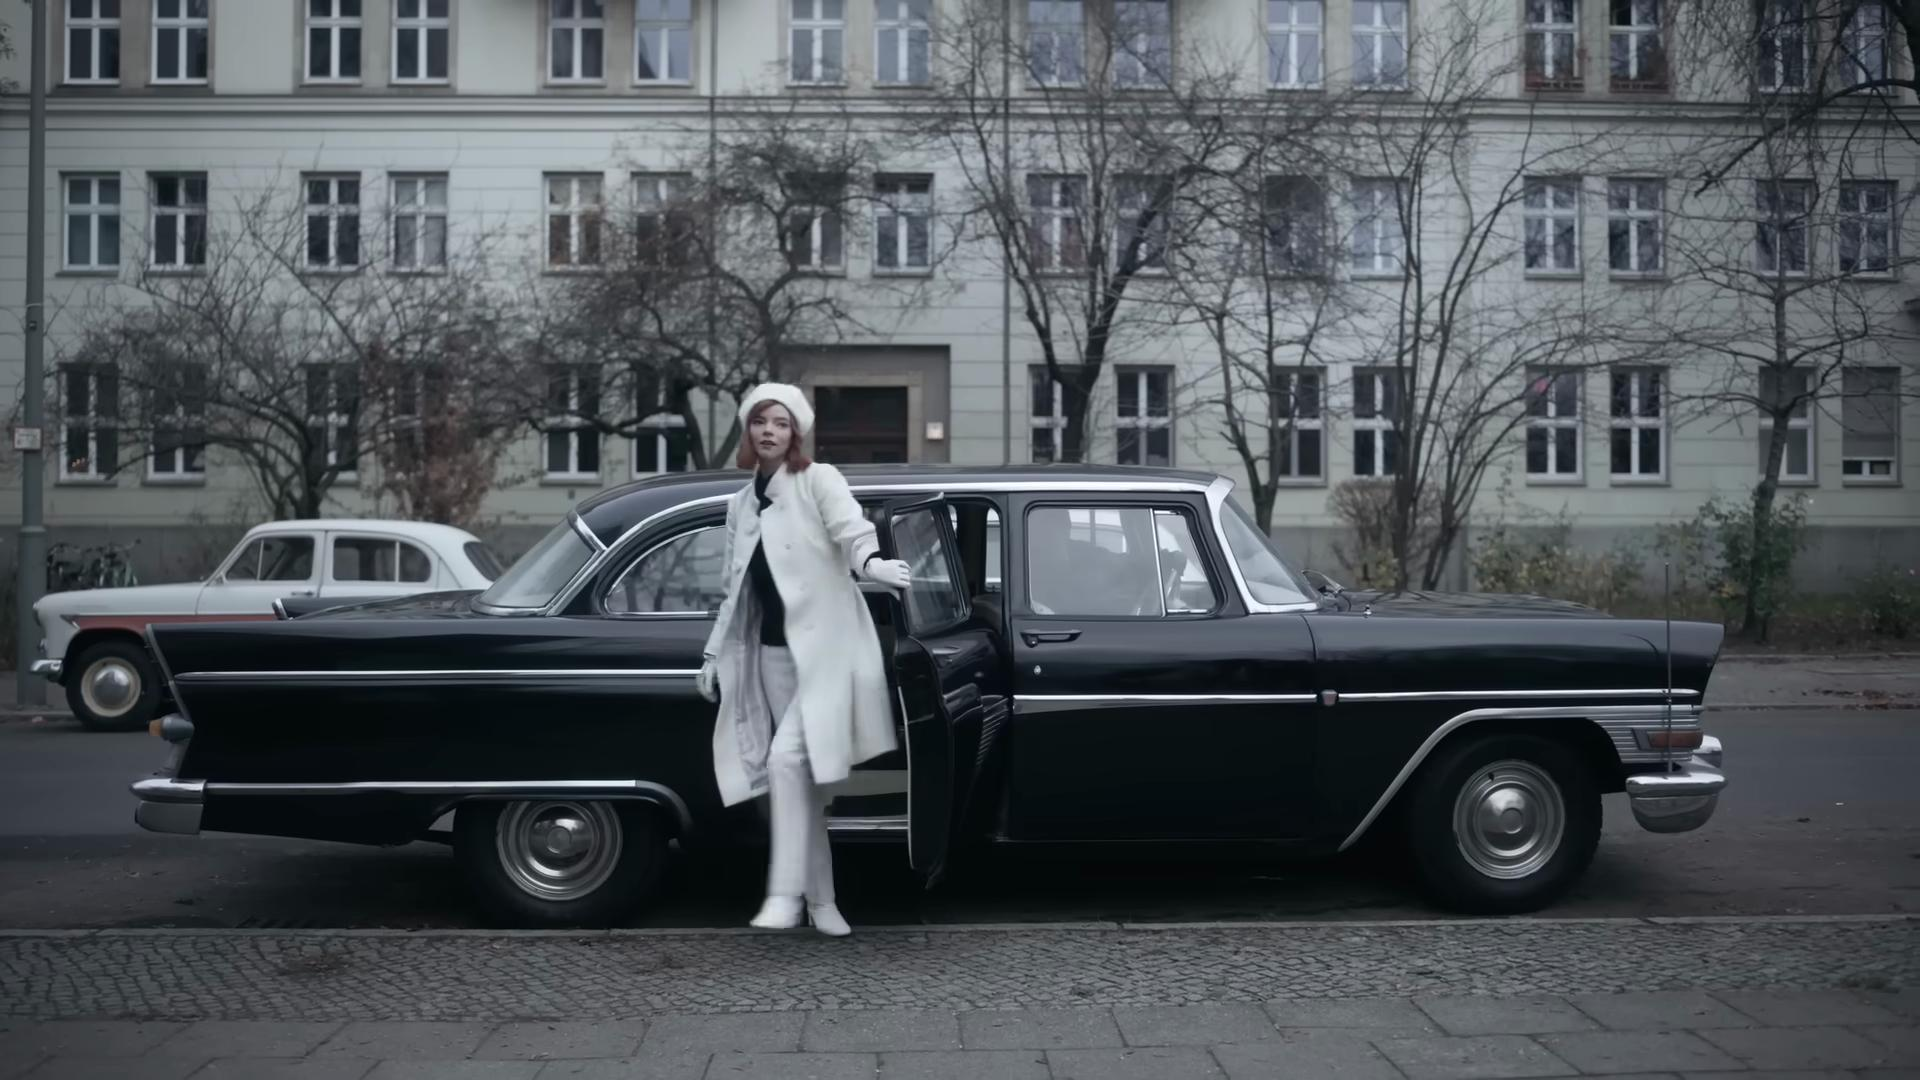

In [ ]:
# Find top 5 similar frames using the embedding index
# pull out the similarity expression and assign it to a variable
# add the extracting middle clip in the select
sim_frames = scenes.select(
    scenes.pos,
    scenes.middle_frame,
    scenes.video_segment,
    similarity=scenes.middle_frame.similarity(query_frame)
).order_by(
    scenes.middle_frame.similarity(query_frame), 
    asc=False
).limit(5).collect()

sim_frames

**Step 5: Create a table to store the selected scenes**

We'll create a new table with three columns: the scene position, the middle frame image, and the full video segment.


In [13]:
# Create a table to store scene middle frames and scene clips
sim_scenes = pxt.create_table(
    'similar-scenes',
    schema={
        'scene_pos': pxt.Int,
        'middle_frame': pxt.Image,
        'video_segment': pxt.Video,
    },
    if_exists='replace'
)

Created table 'similar-scenes'.


In [14]:
sim_scenes

table 'similar-scenes'

    Column Name   Type Computed With
      scene_pos    Int              
   middle_frame  Image              
  video_segment  Video

**Step 6: Insert the similar scenes into the table**

Now we'll populate the table with the similar scenes we found earlier:

In [15]:
# Insert the selected scenes with their middle frames and video segments
sim_scenes.insert([{
    'scene_pos': row['pos'],
    'middle_frame': row['middle_frame'],
    'video_segment': row['video_segment']
} for row in sim_frames])

Inserting rows into `similar-scenes`: 5 rows [00:00, 555.99 rows/s]
Inserted 5 rows with 0 errors.


5 rows inserted, 20 values computed.

scene_pos                                       middle_frame  \
0          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1          3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2          2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4          6  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                       video_segment  
0  /Users/alison-pxt/.pixeltable/media/4d56b426a8...  
1  /Users/alison-pxt/.pixeltable/media/4d56b426a8...  
2  /Users/alison-pxt/.pixeltable/media/4d56b426a8...  
3  /Users/alison-pxt/.pixeltable/media/4d56b426a8...  
4  /Users/alison-pxt/.pixeltable/media/4d56b426a8...
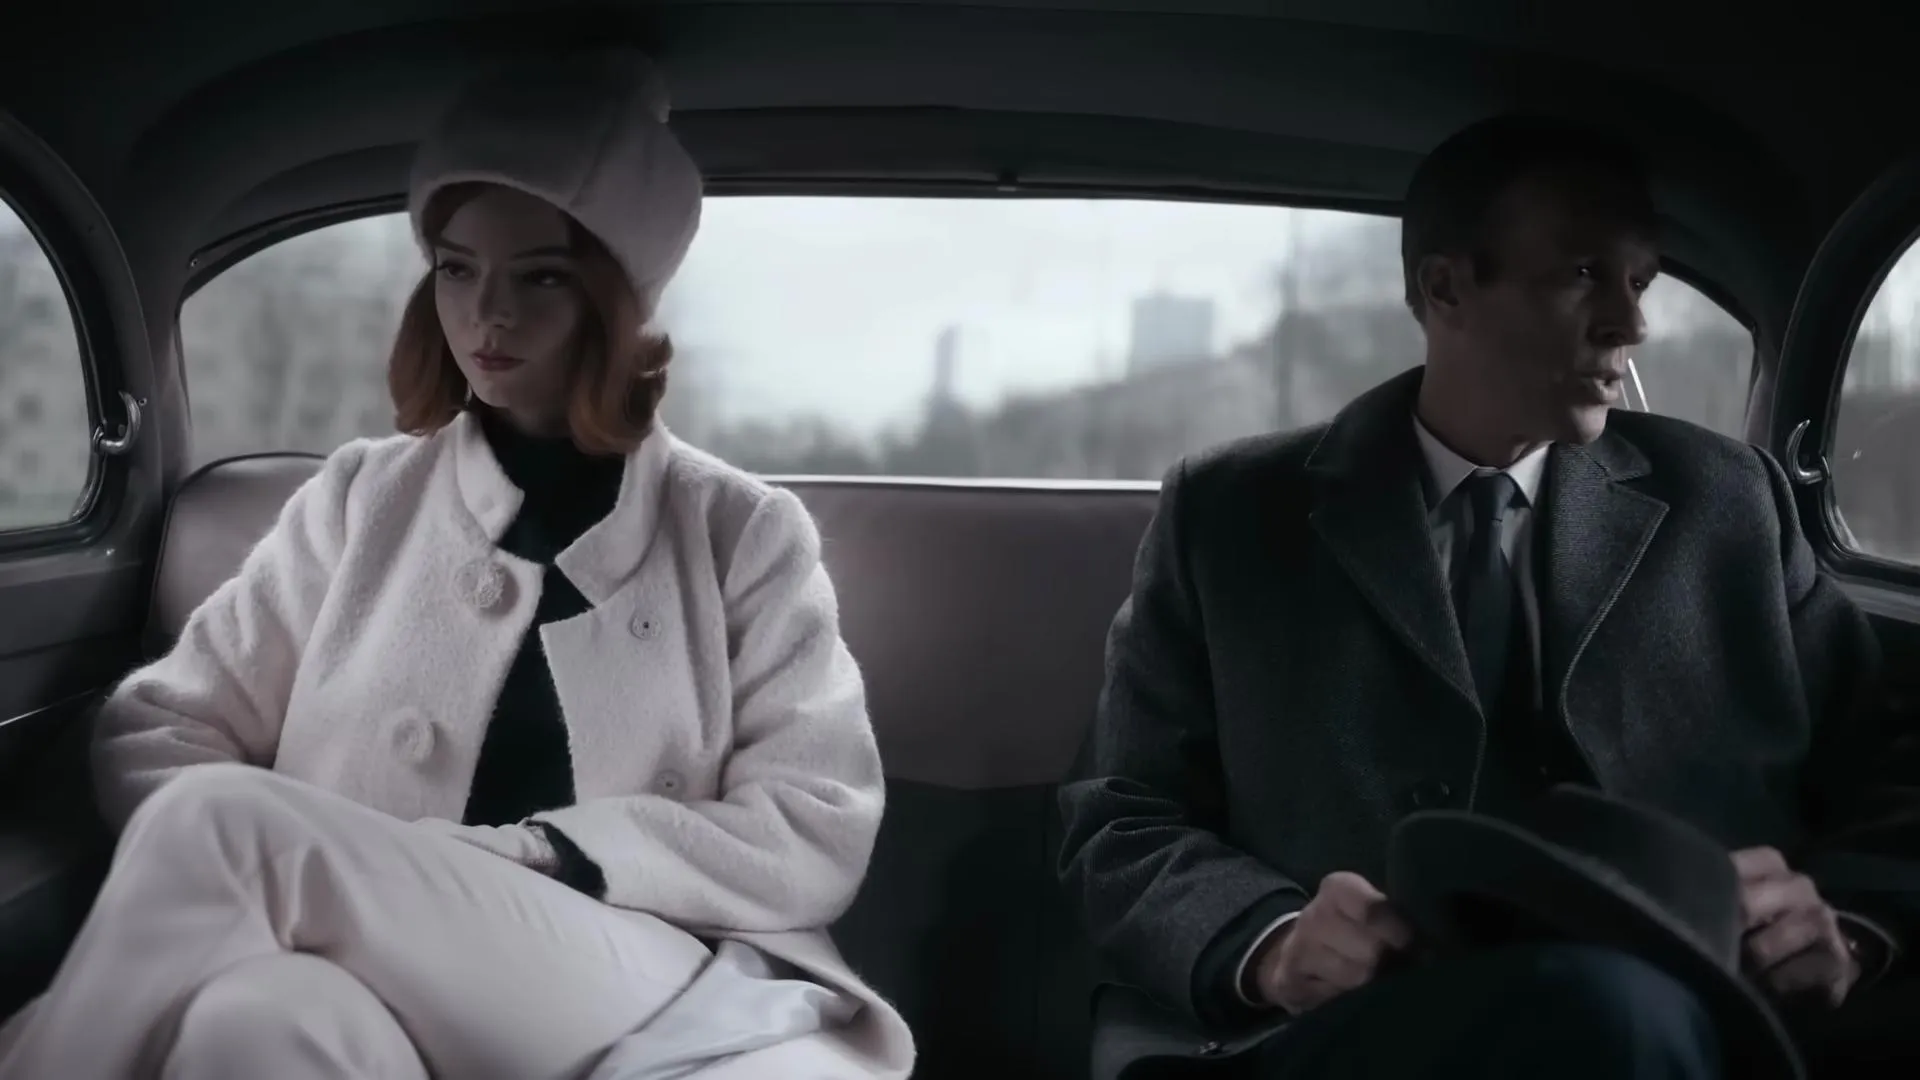
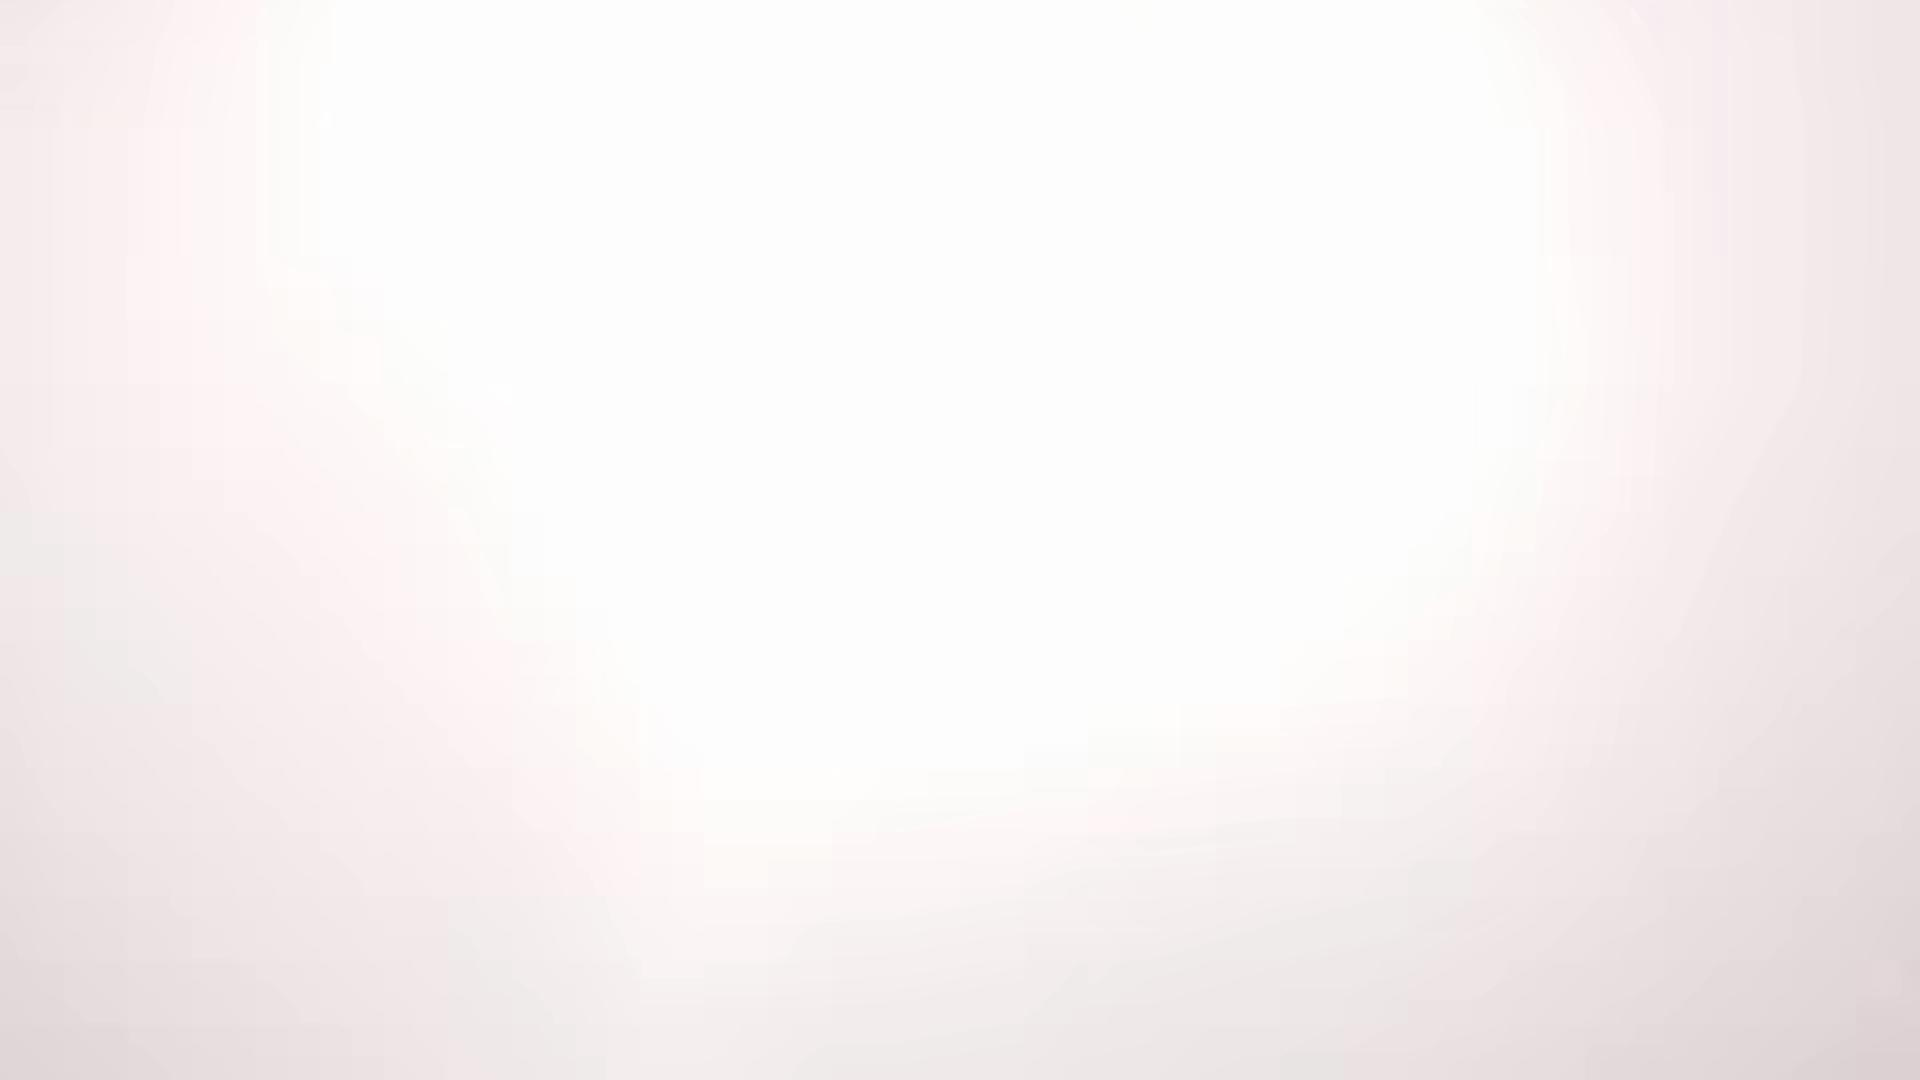
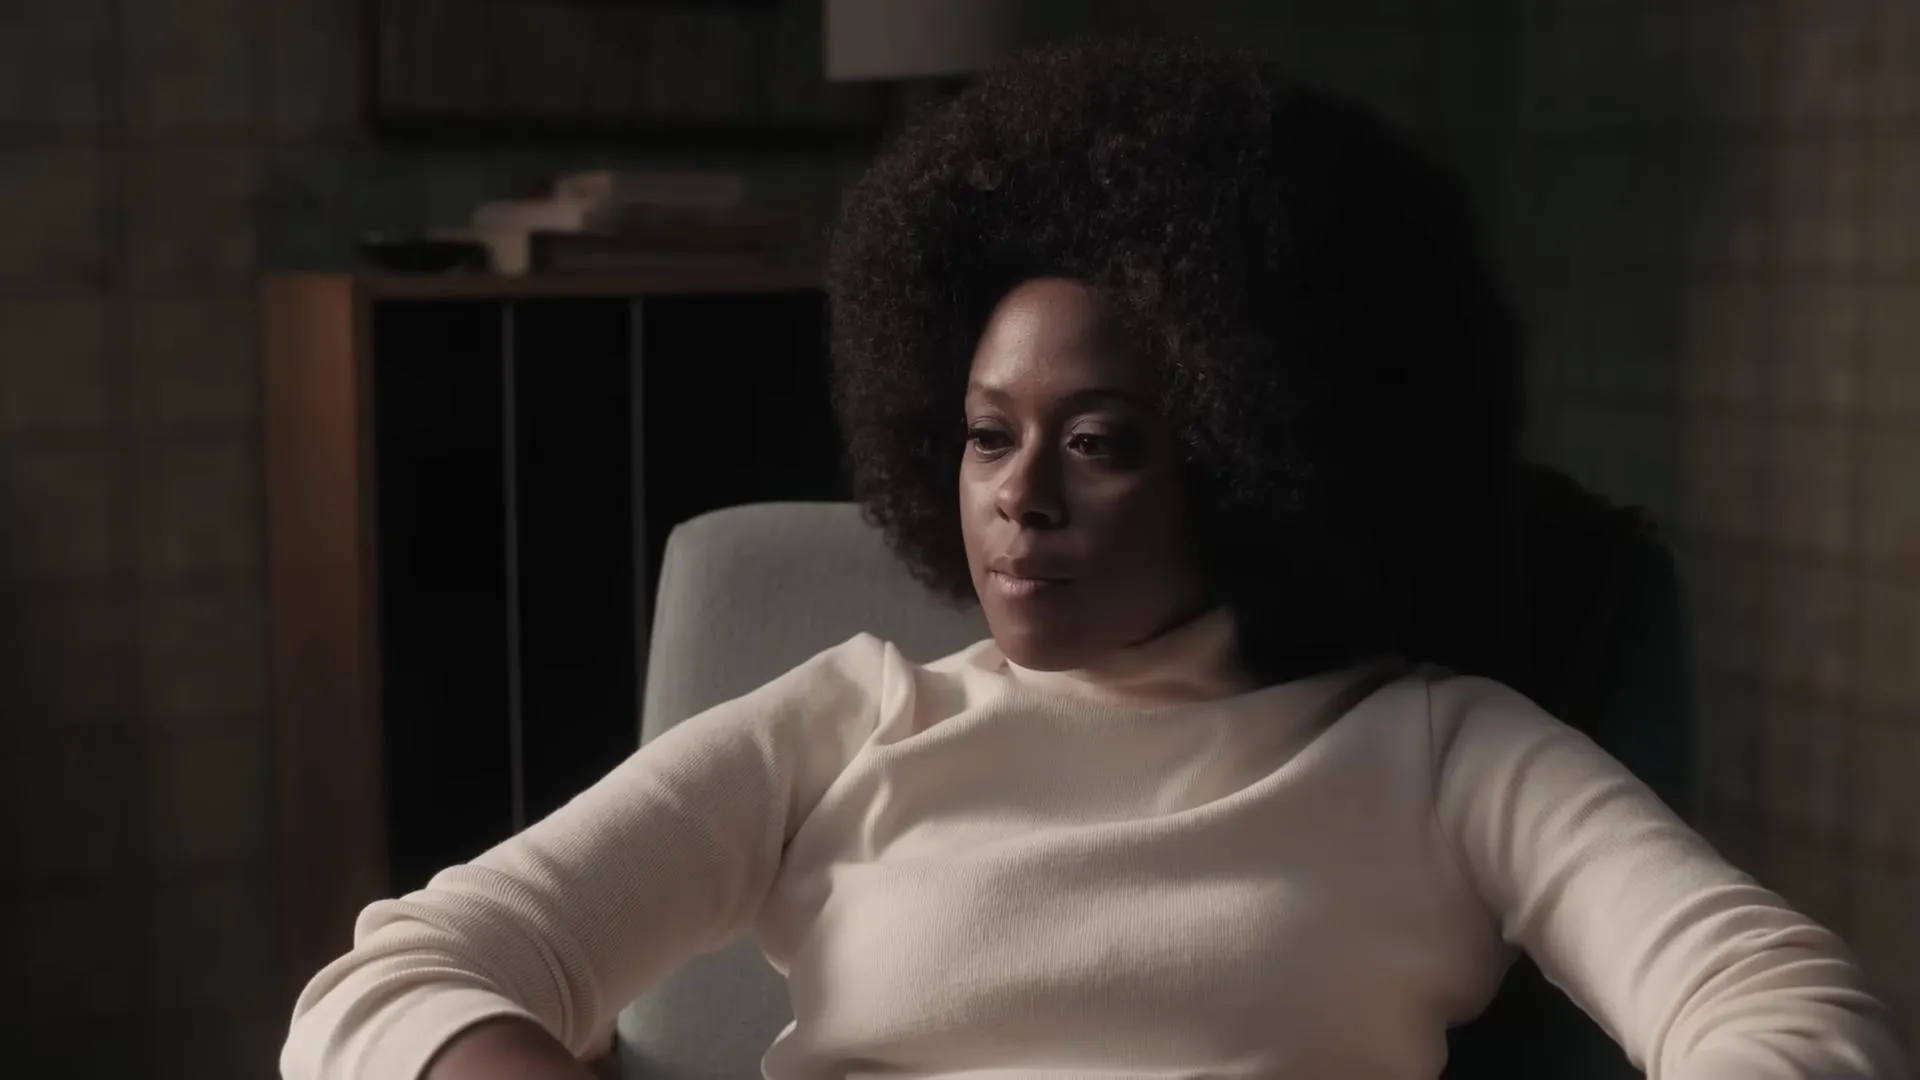
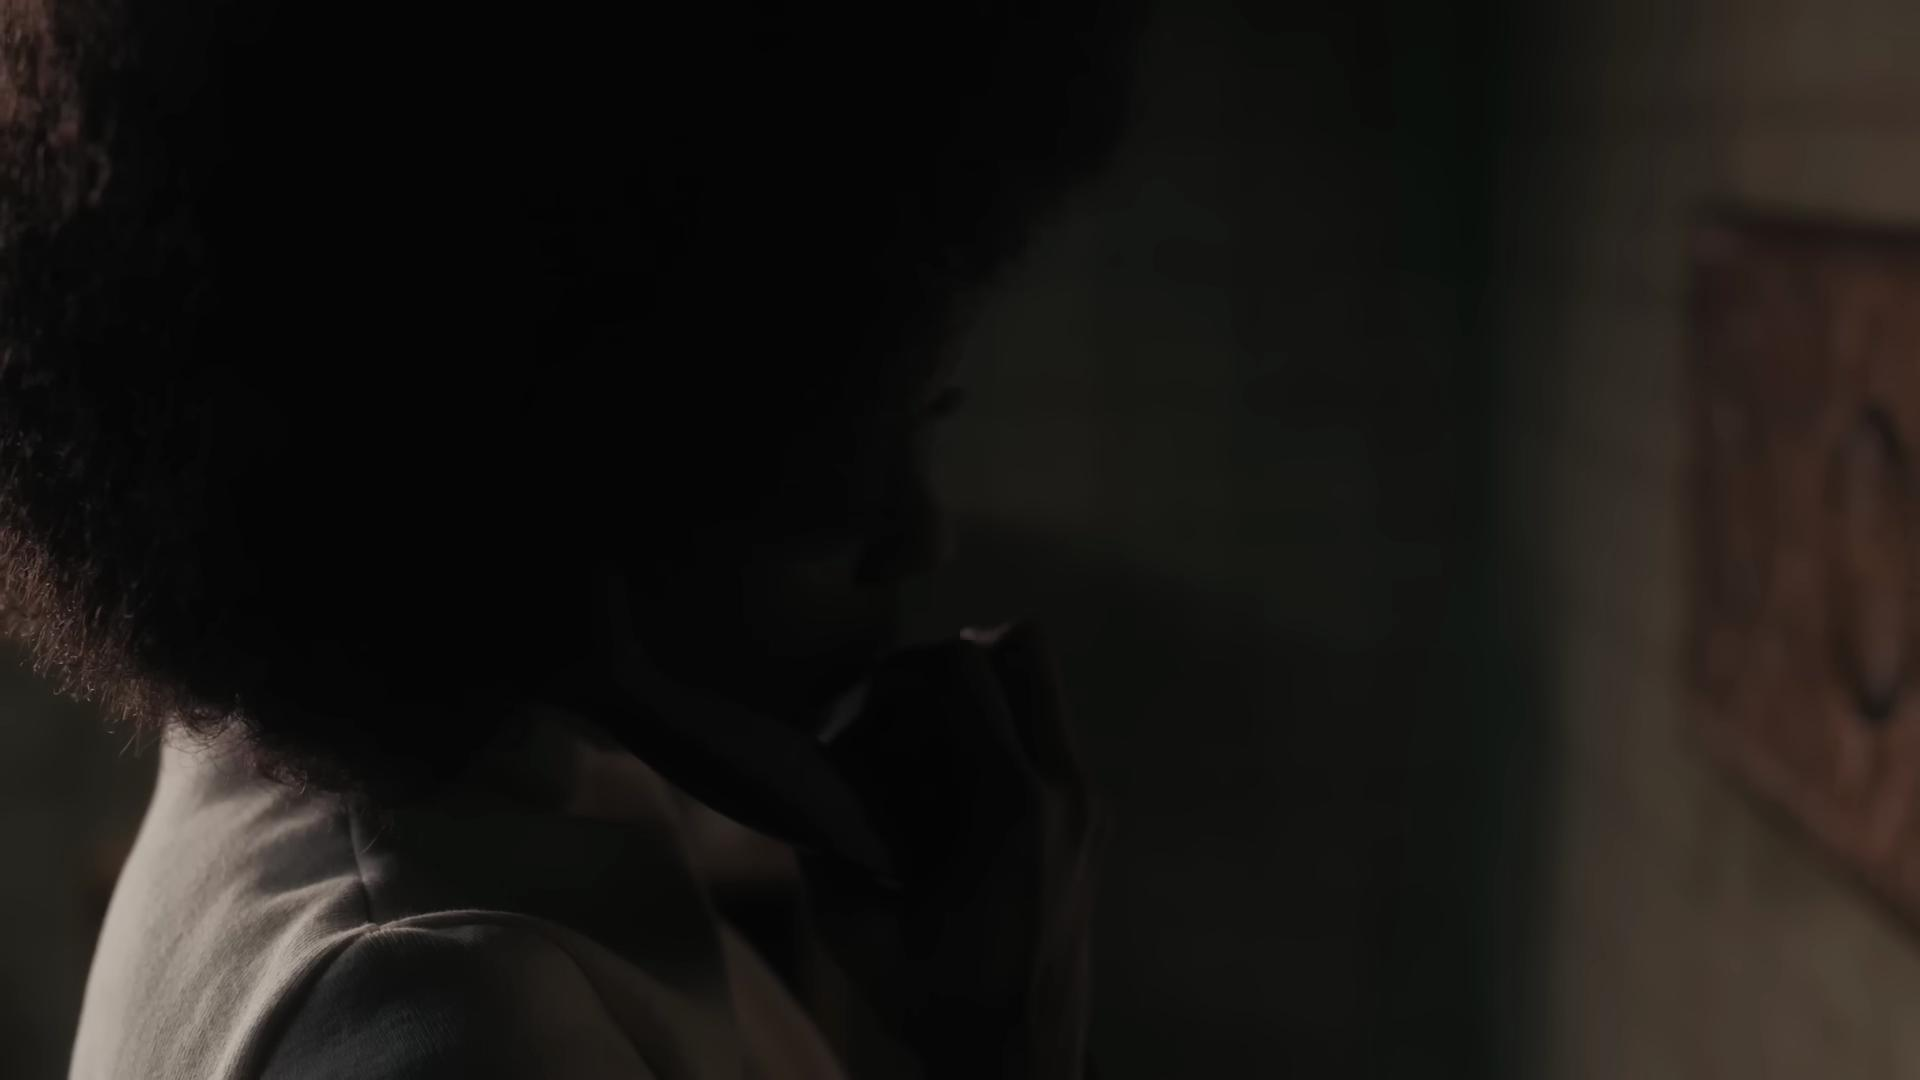
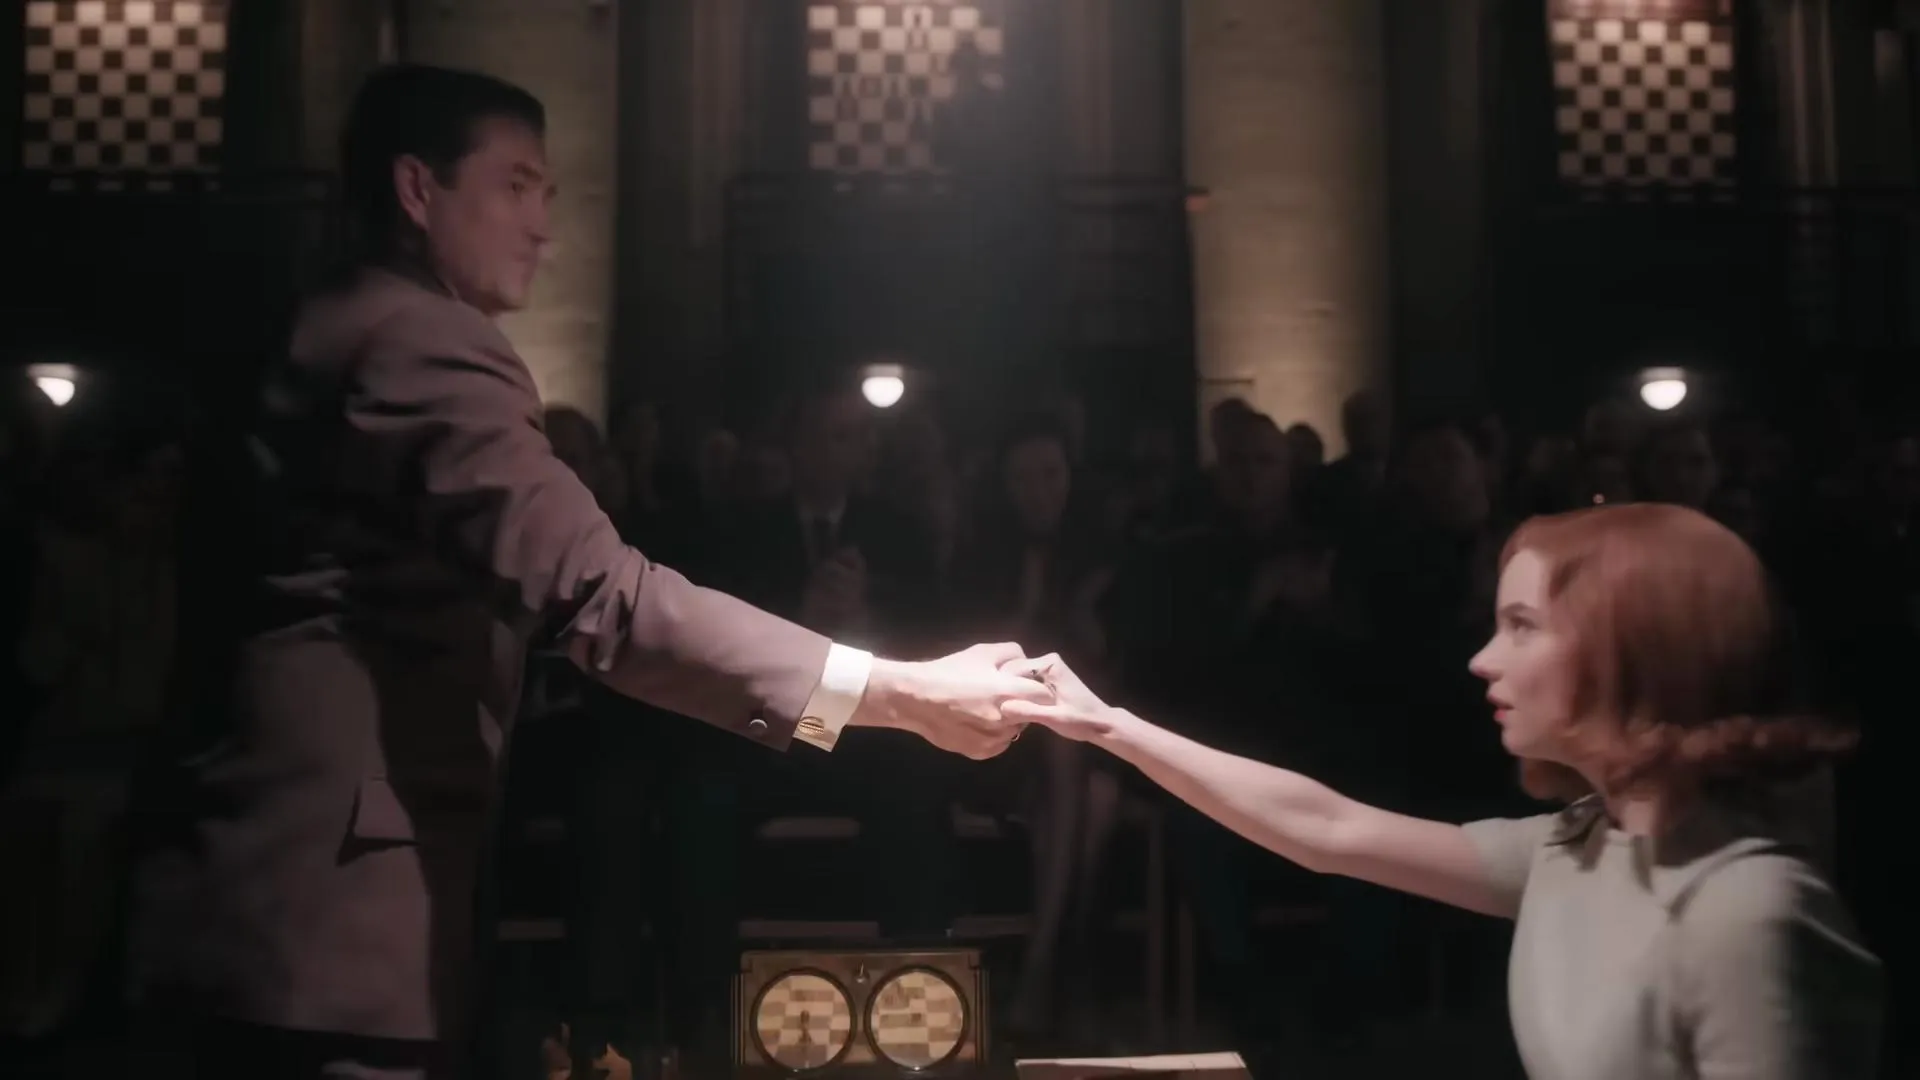
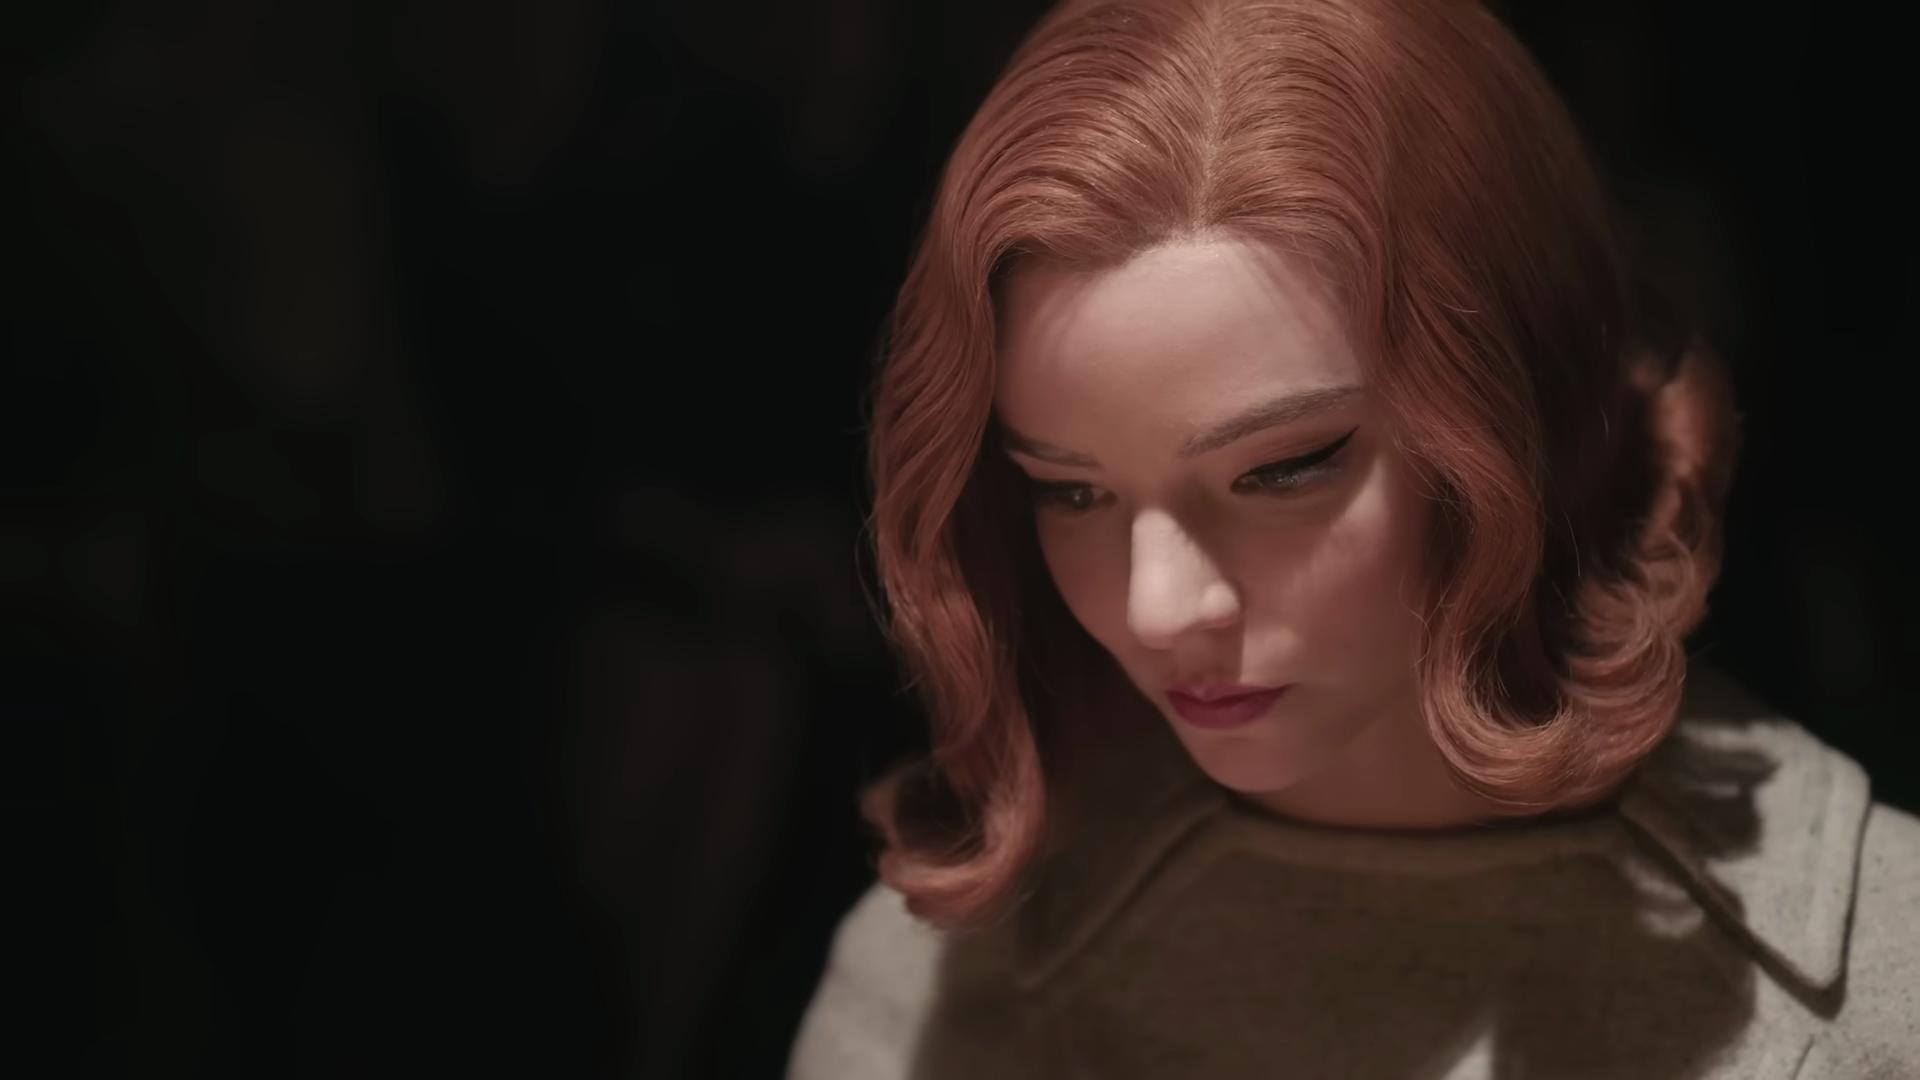
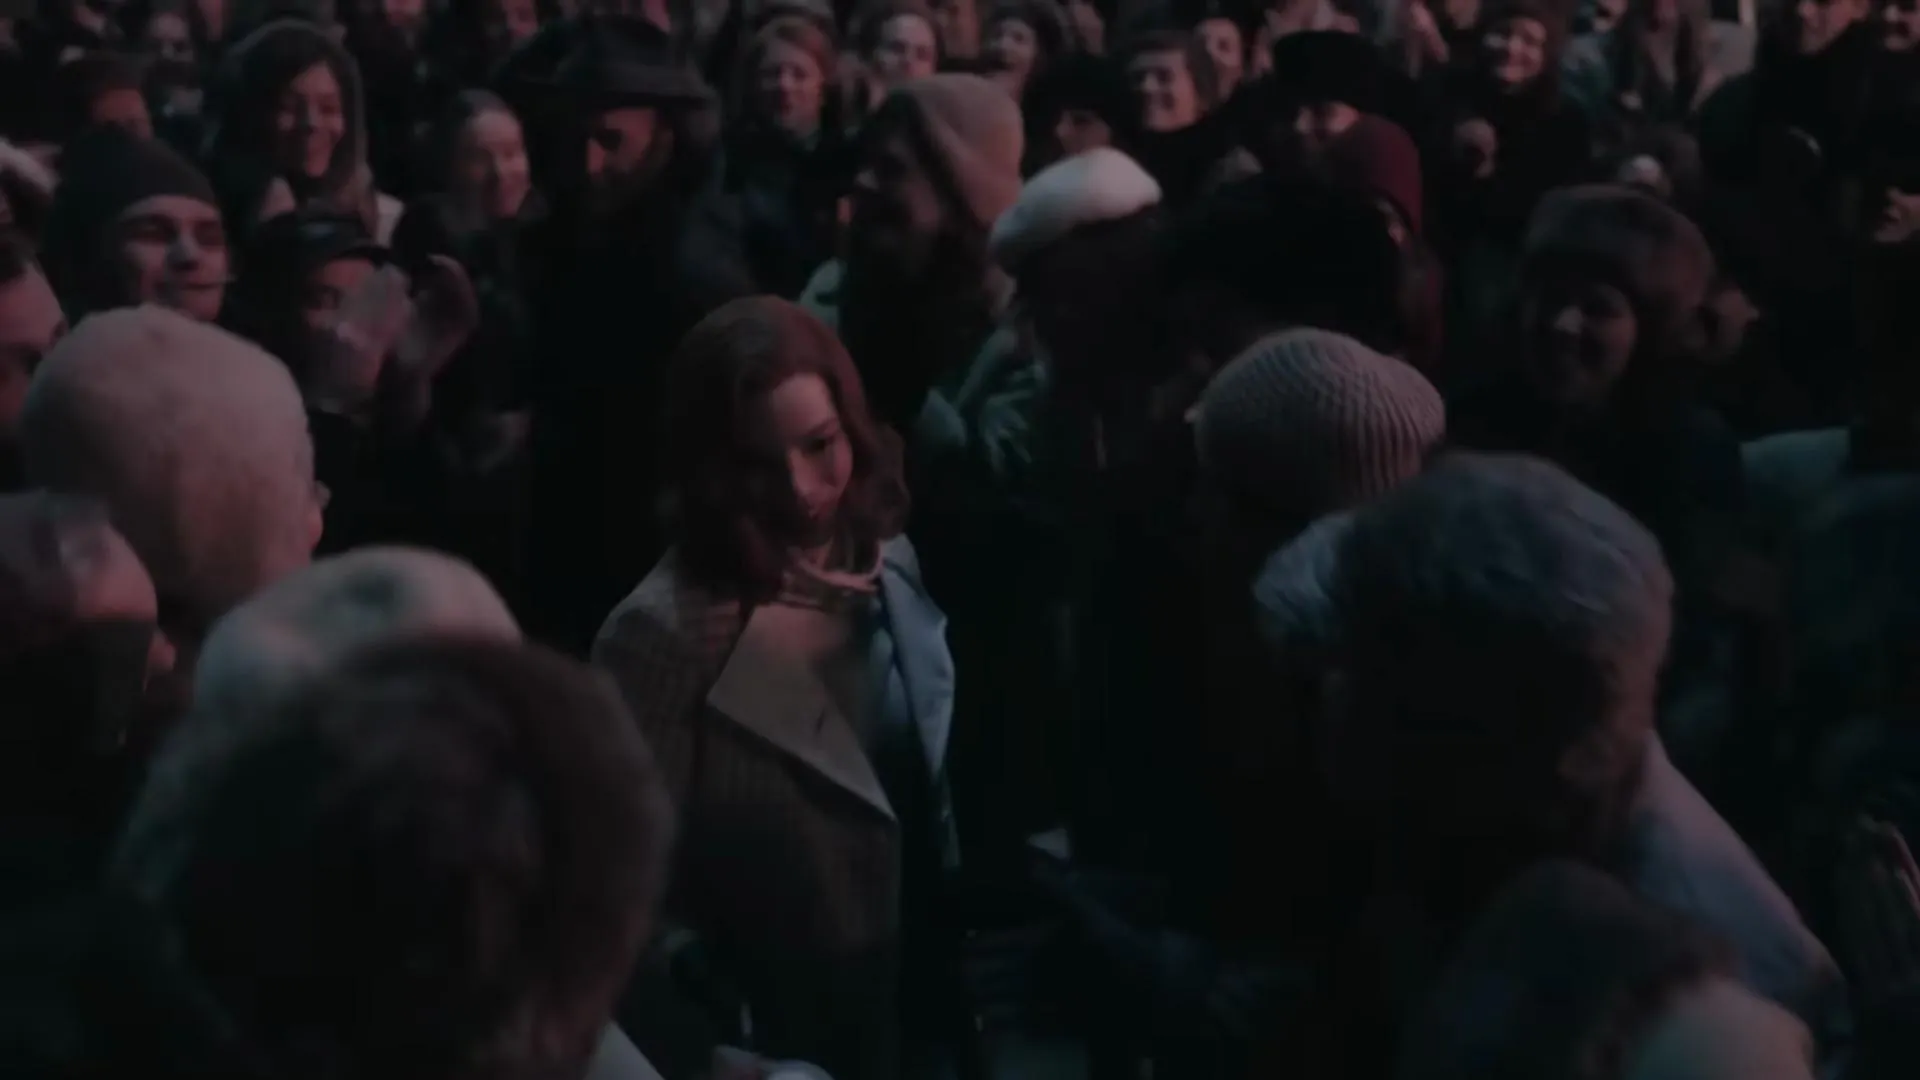
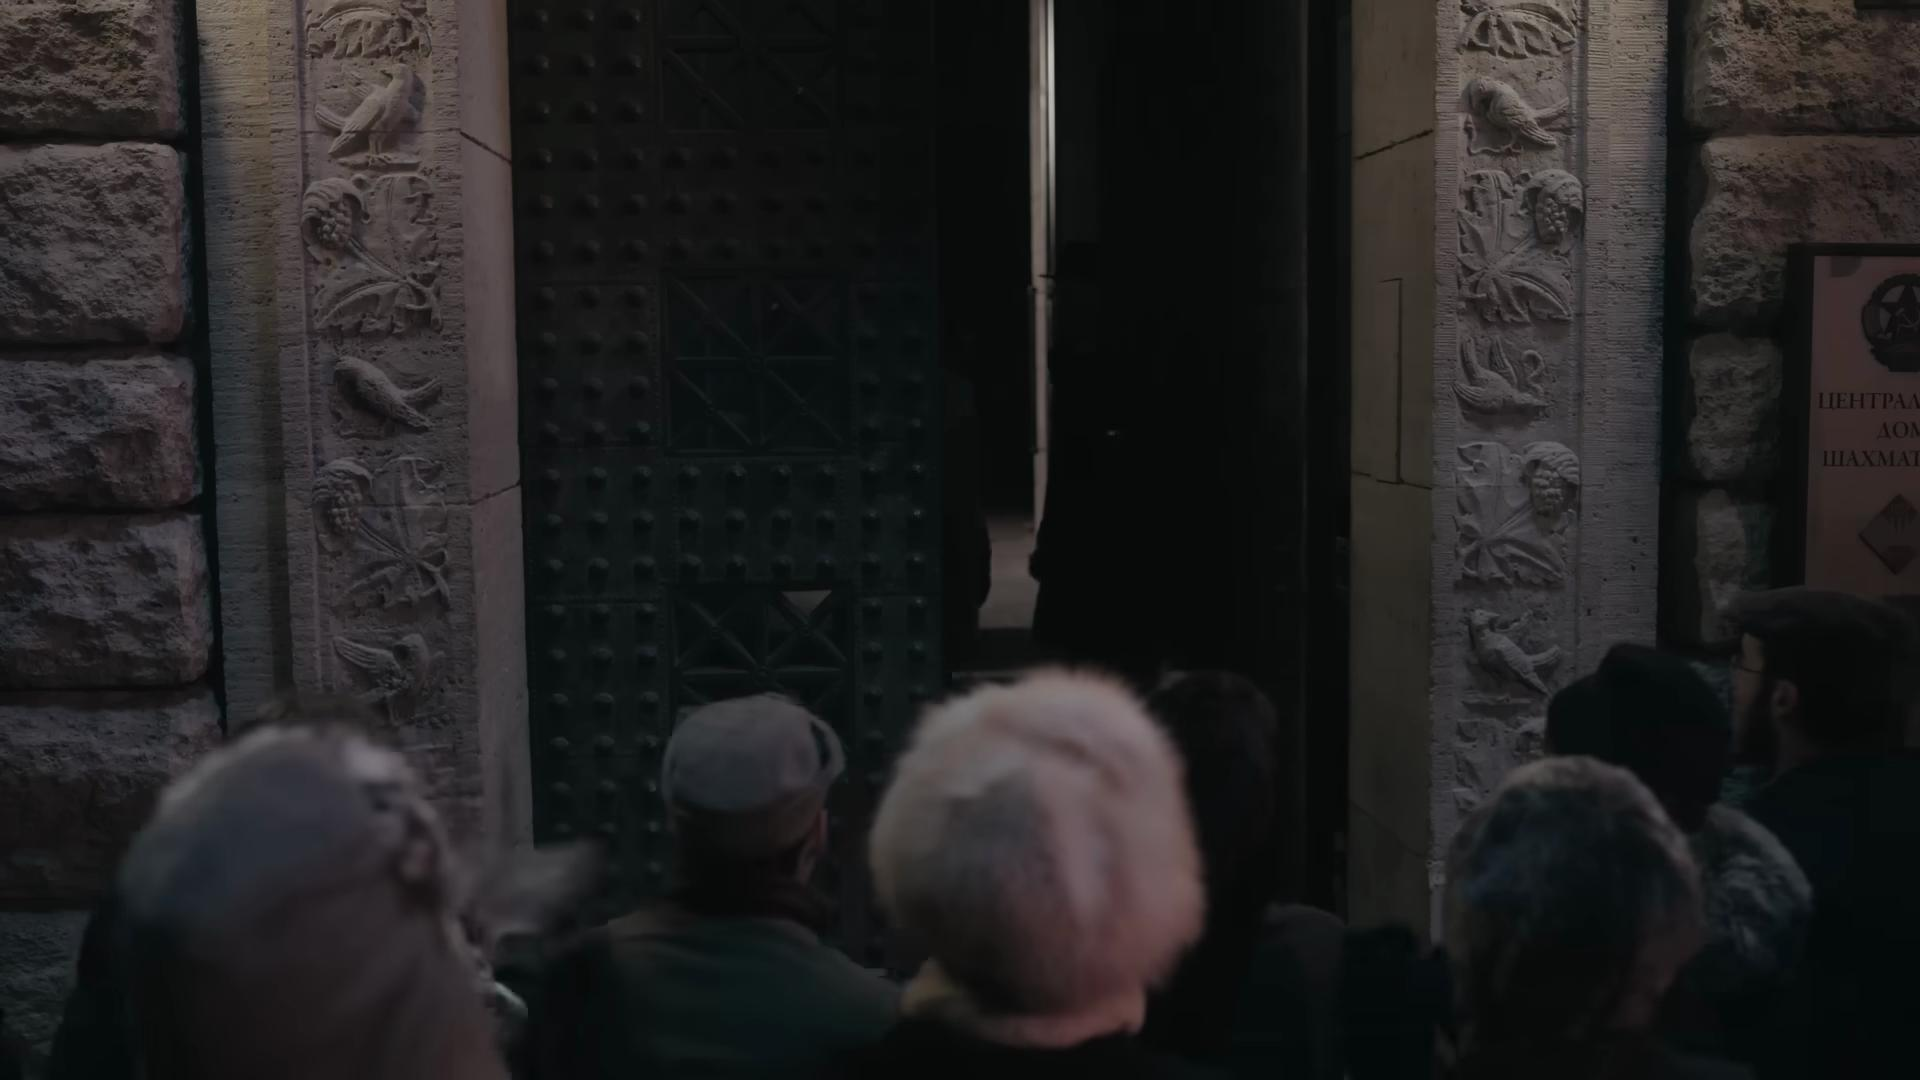
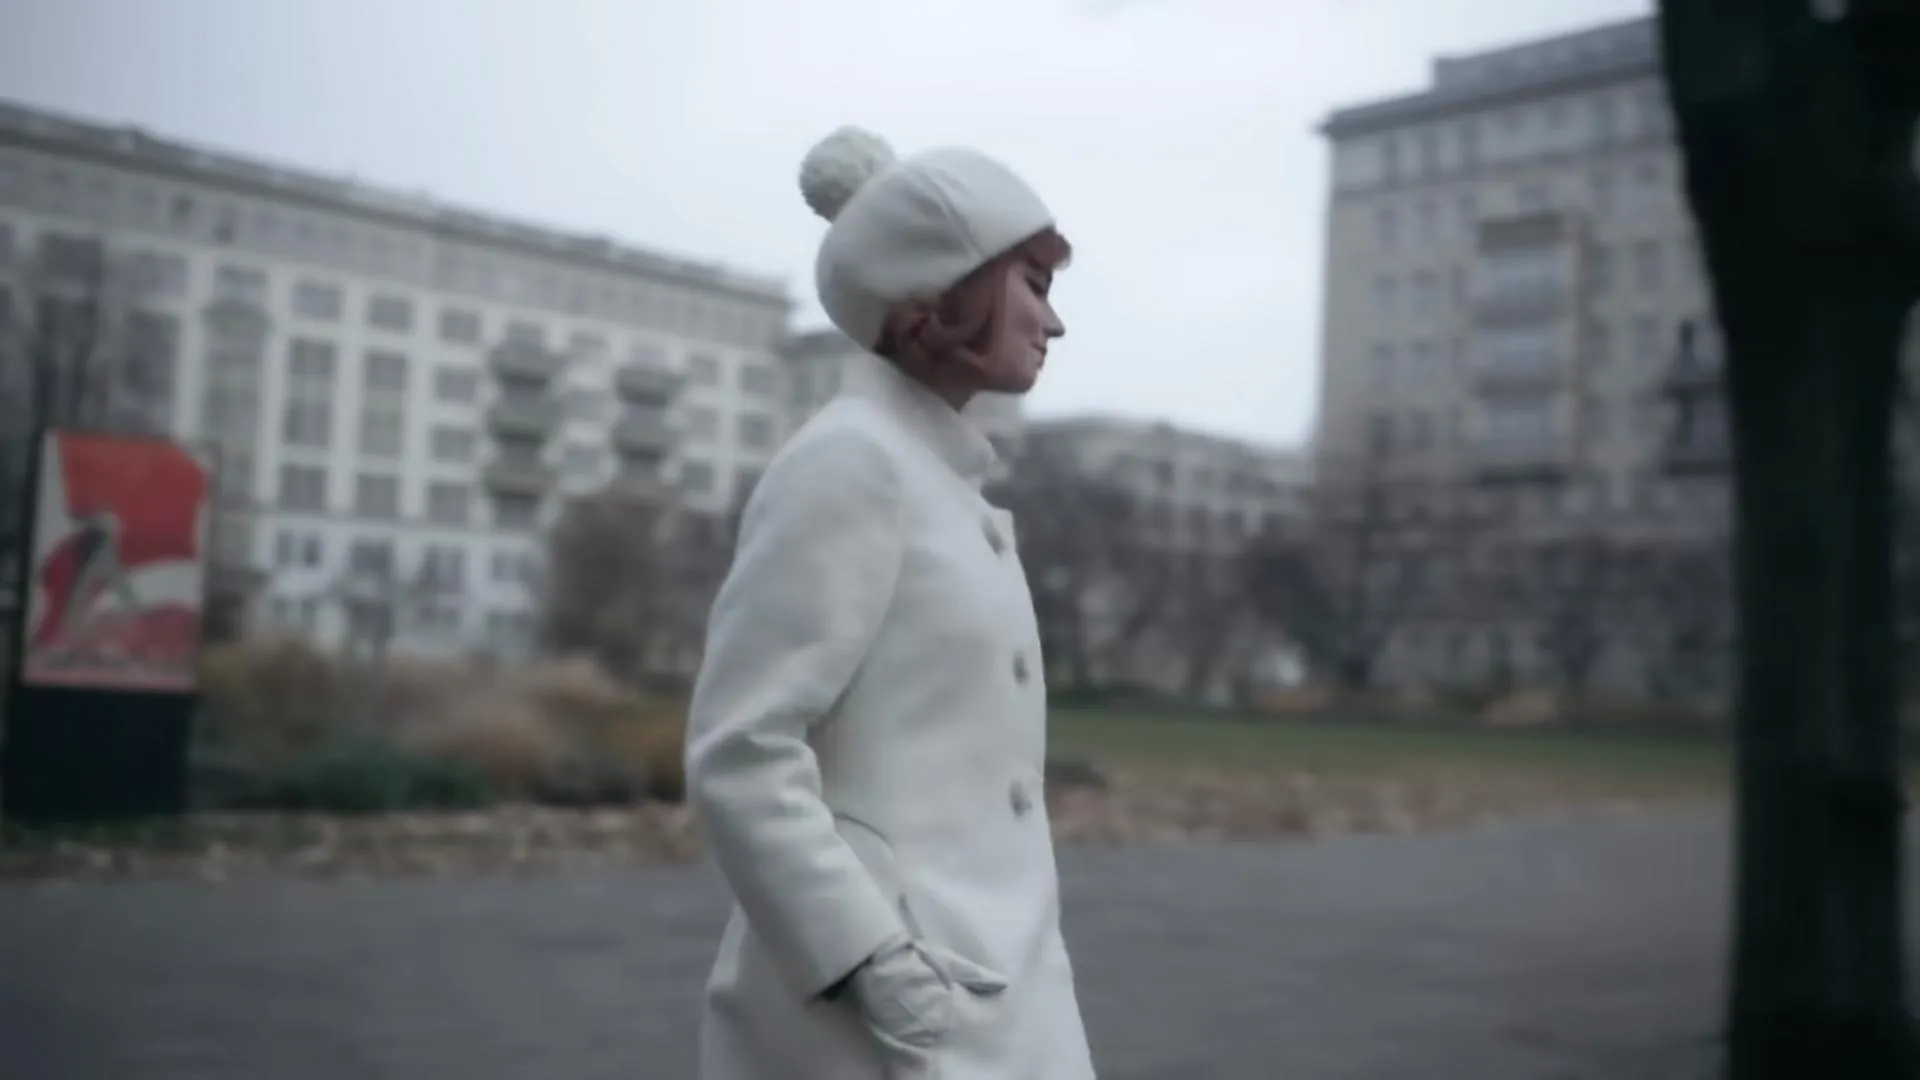
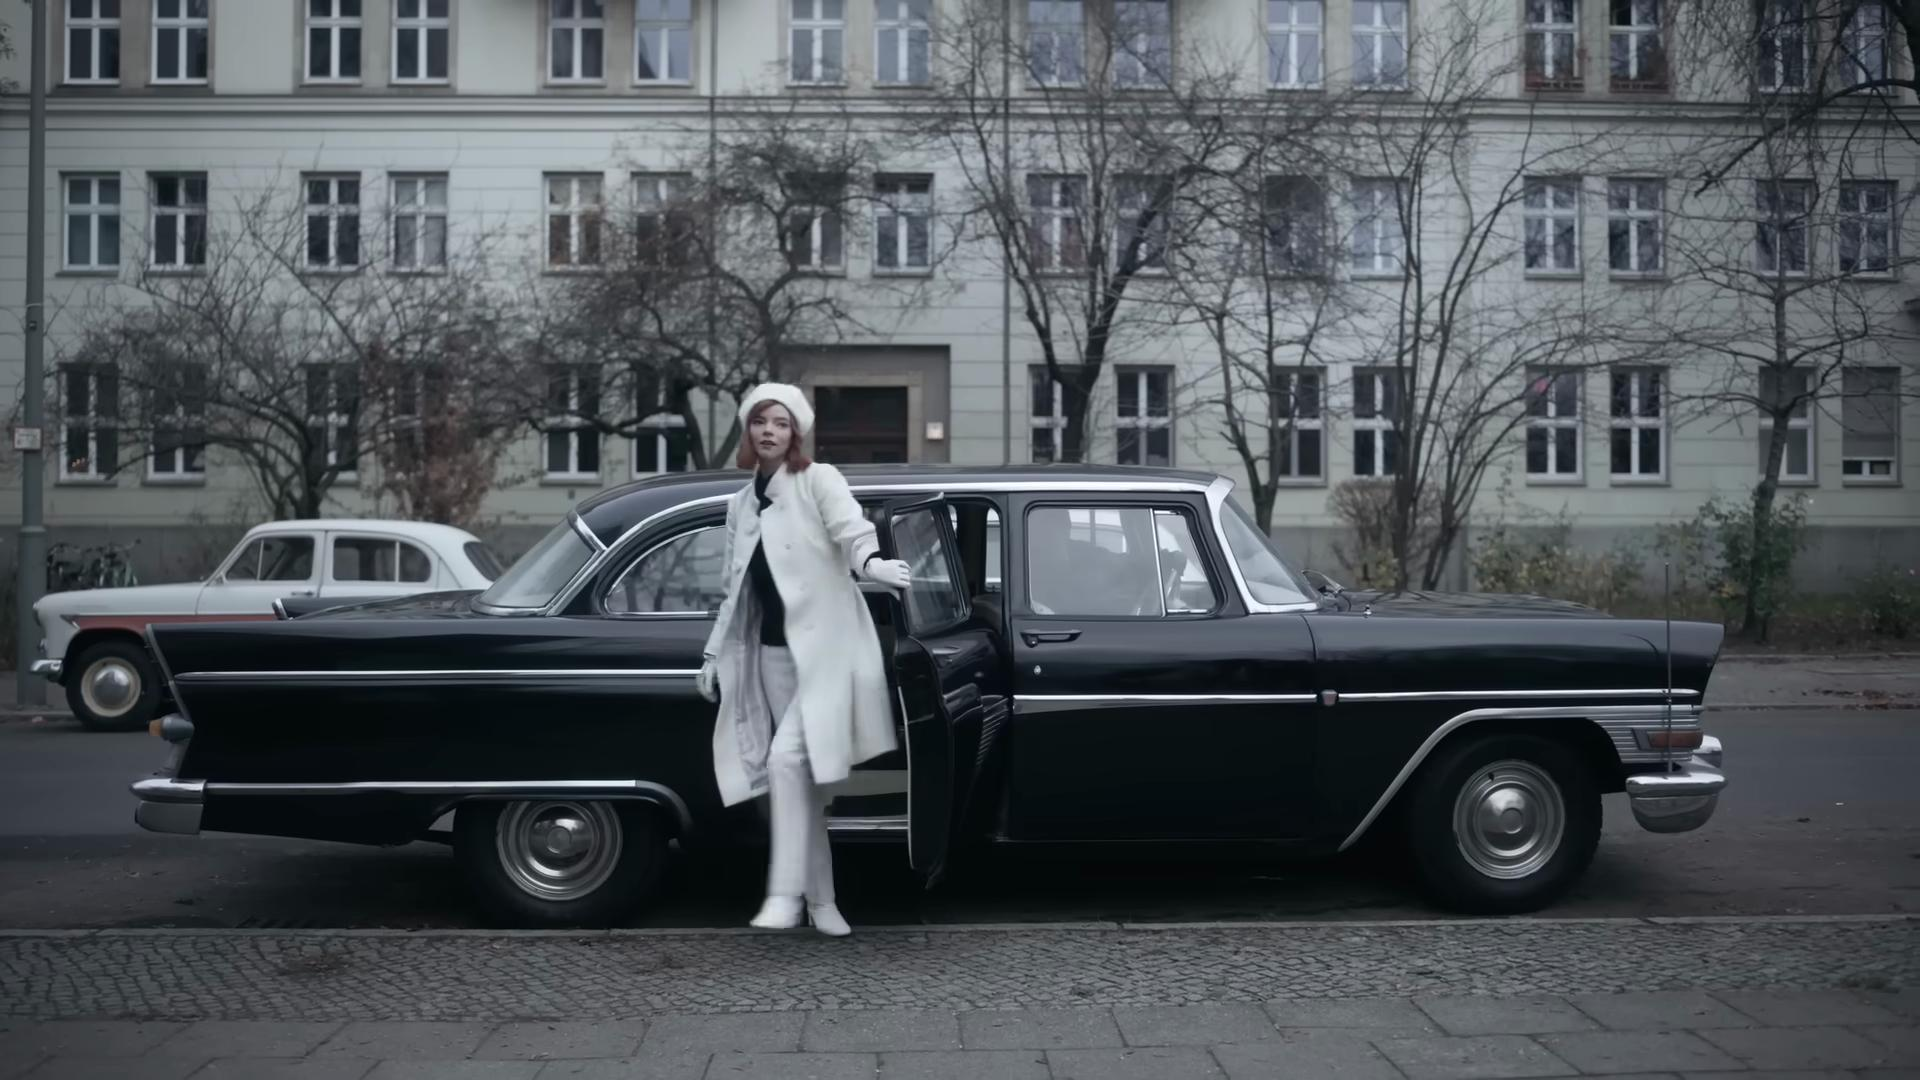

In [16]:
sim_scenes.collect()

**Step 7: Extract 6-second clips from the middle of each scene**

Add a computed column that extracts a 6-second clip centered on the middle of each scene (3 seconds before and after the midpoint):


In [ ]:
# Extract 6-second clips from the middle of each scene
# does this really have to be a separate table
sim_scenes.add_computed_column(
    middle_clip=sim_scenes.video_segment.clip(
        start_time=sim_scenes.video_segment.get_duration() / 2.0 - 3.0,
        end_time=sim_scenes.video_segment.get_duration() / 2.0 + 3.0
    ),
    if_exists='replace'
)

Added 5 column values with 0 errors.


5 rows updated, 5 values computed.

middle_clip
0  /Users/alison-pxt/.pixeltable/media/60a18d686b...
1  /Users/alison-pxt/.pixeltable/media/60a18d686b...
2  /Users/alison-pxt/.pixeltable/media/60a18d686b...
3  /Users/alison-pxt/.pixeltable/media/60a18d686b...
4  /Users/alison-pxt/.pixeltable/media/60a18d686b...
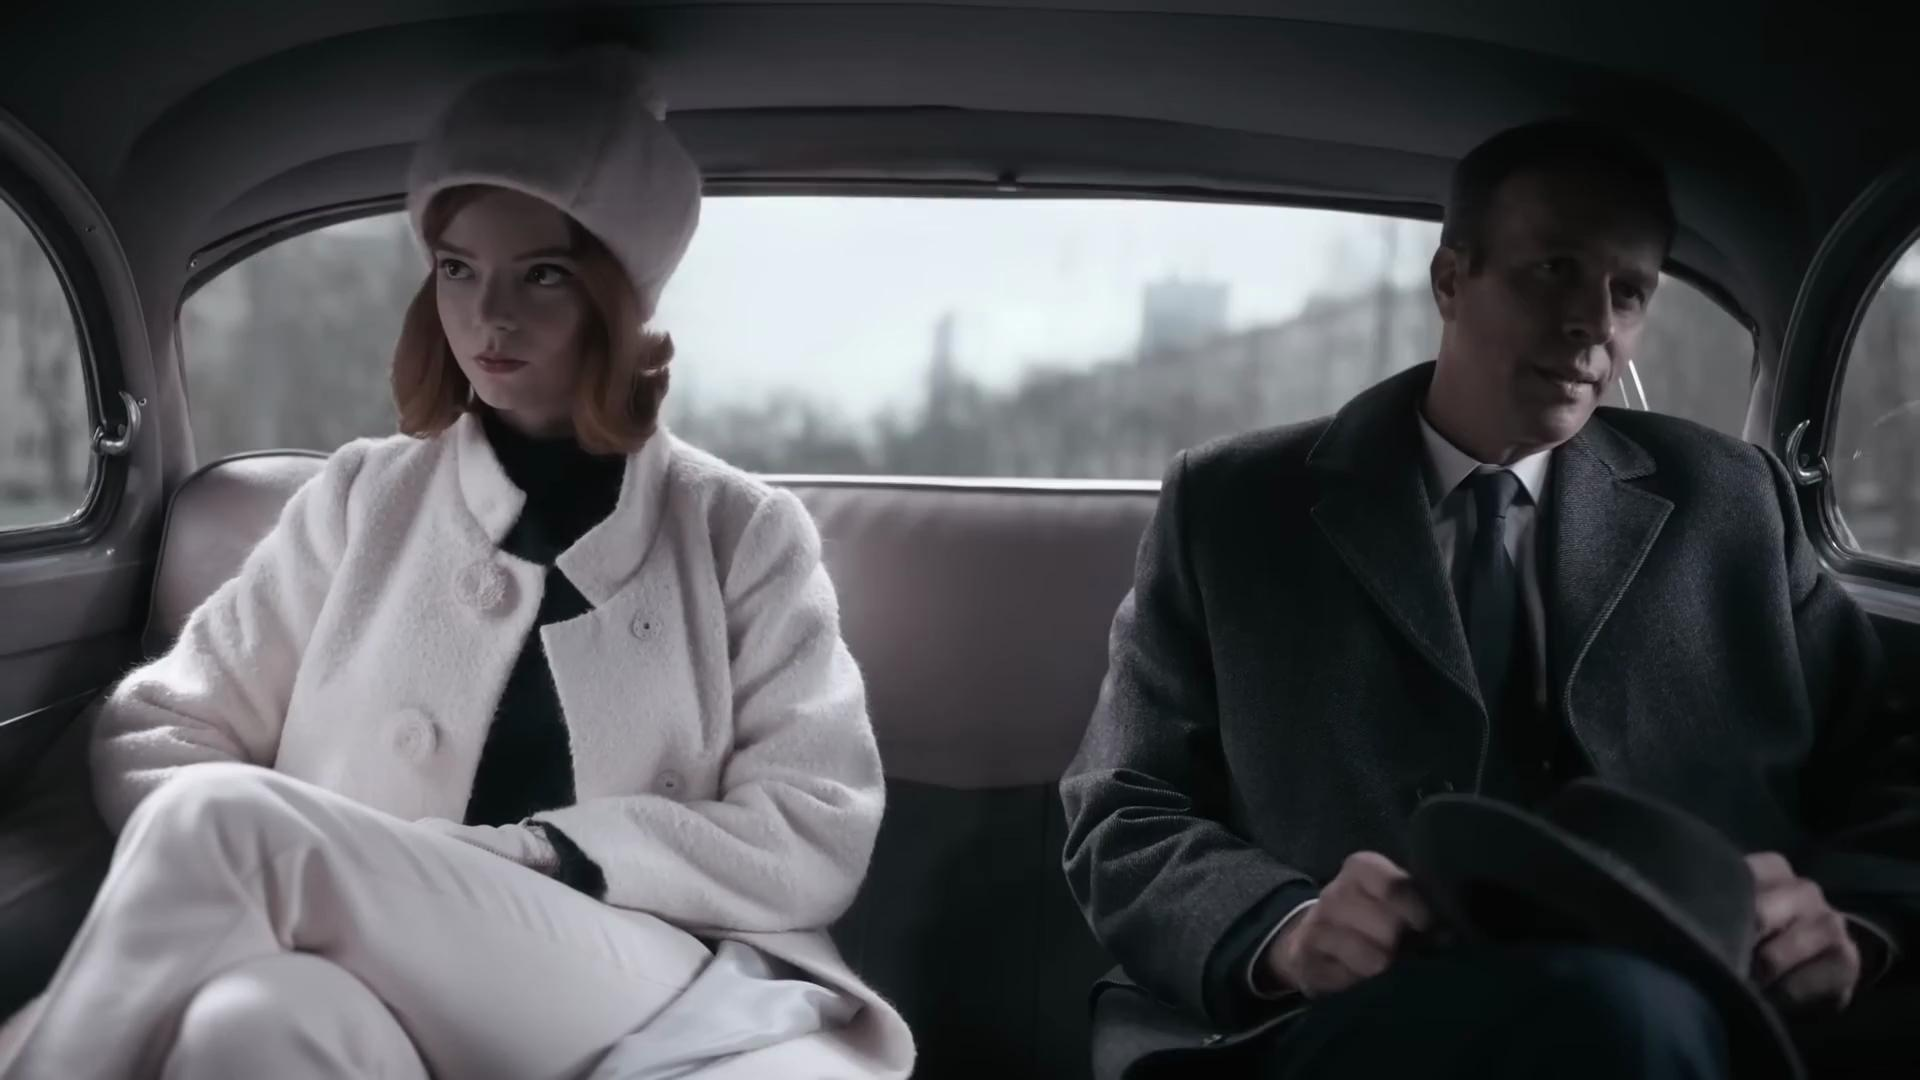
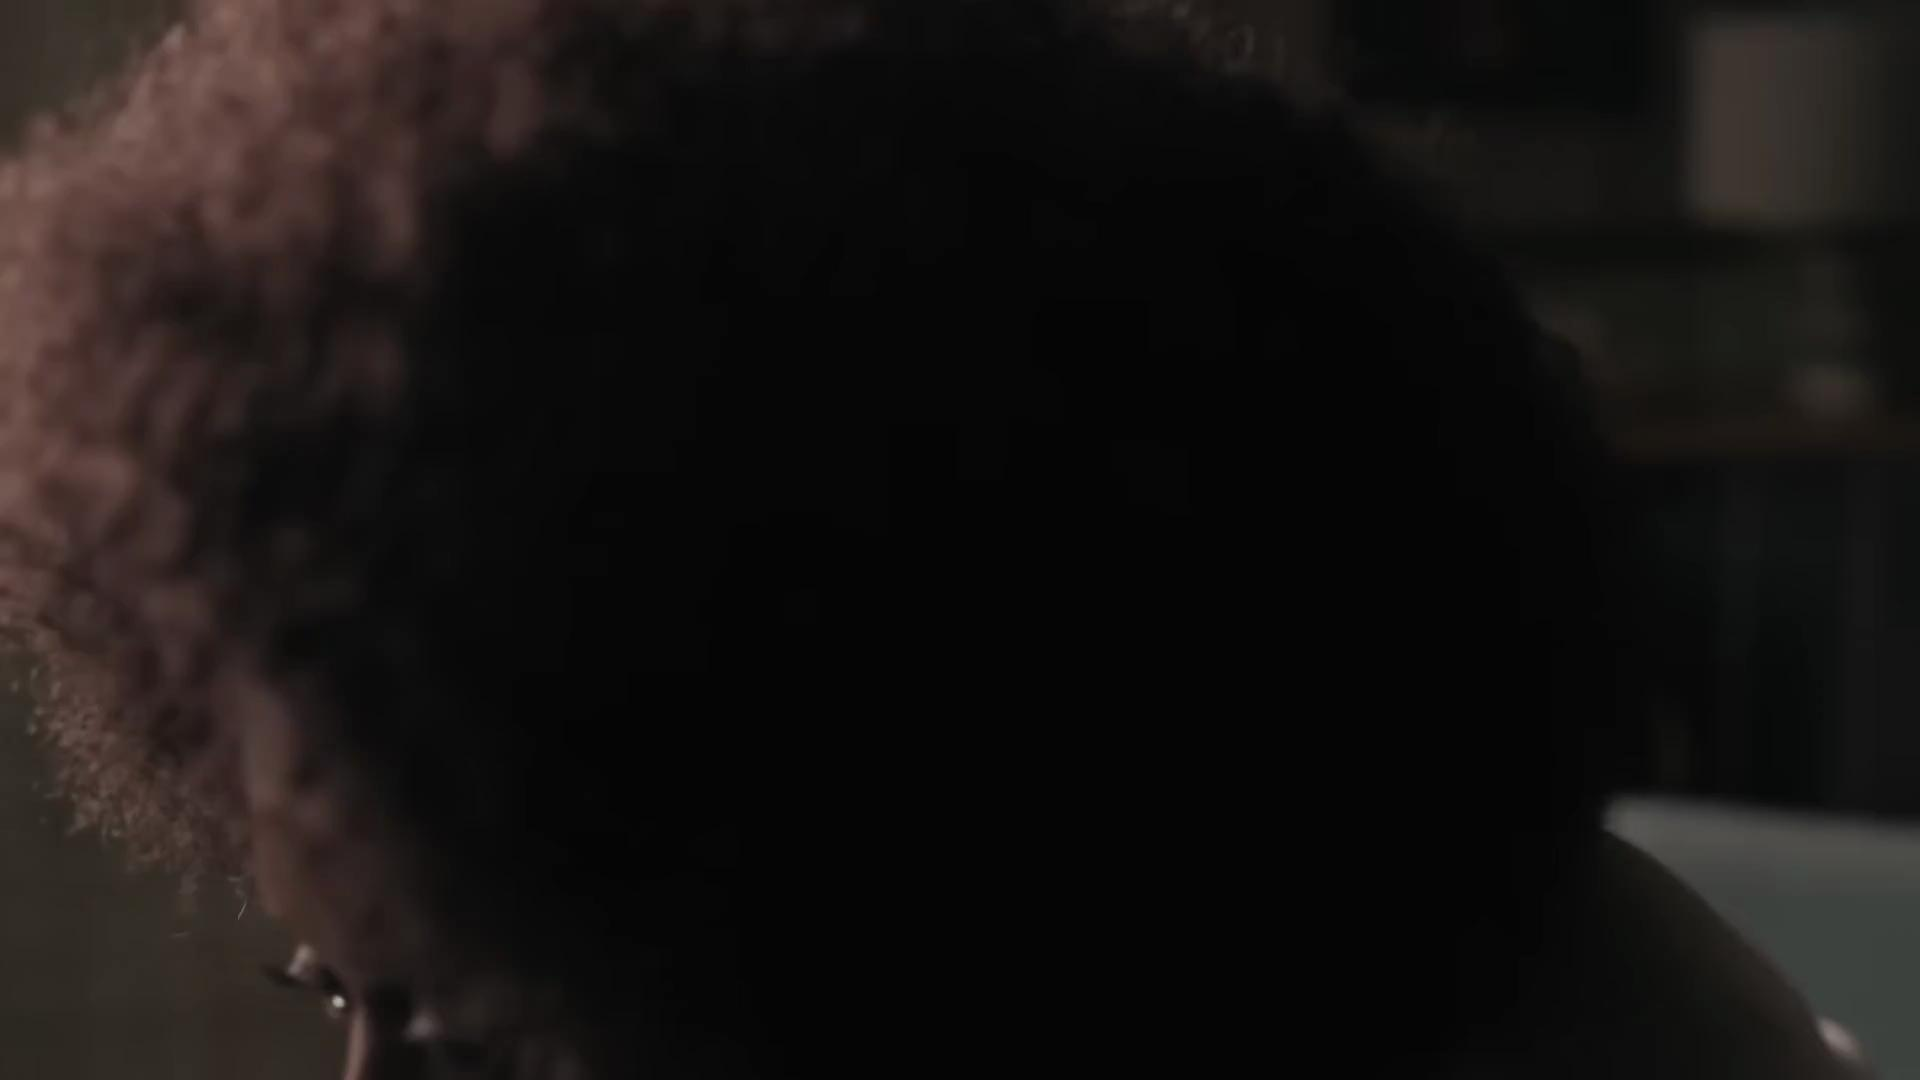
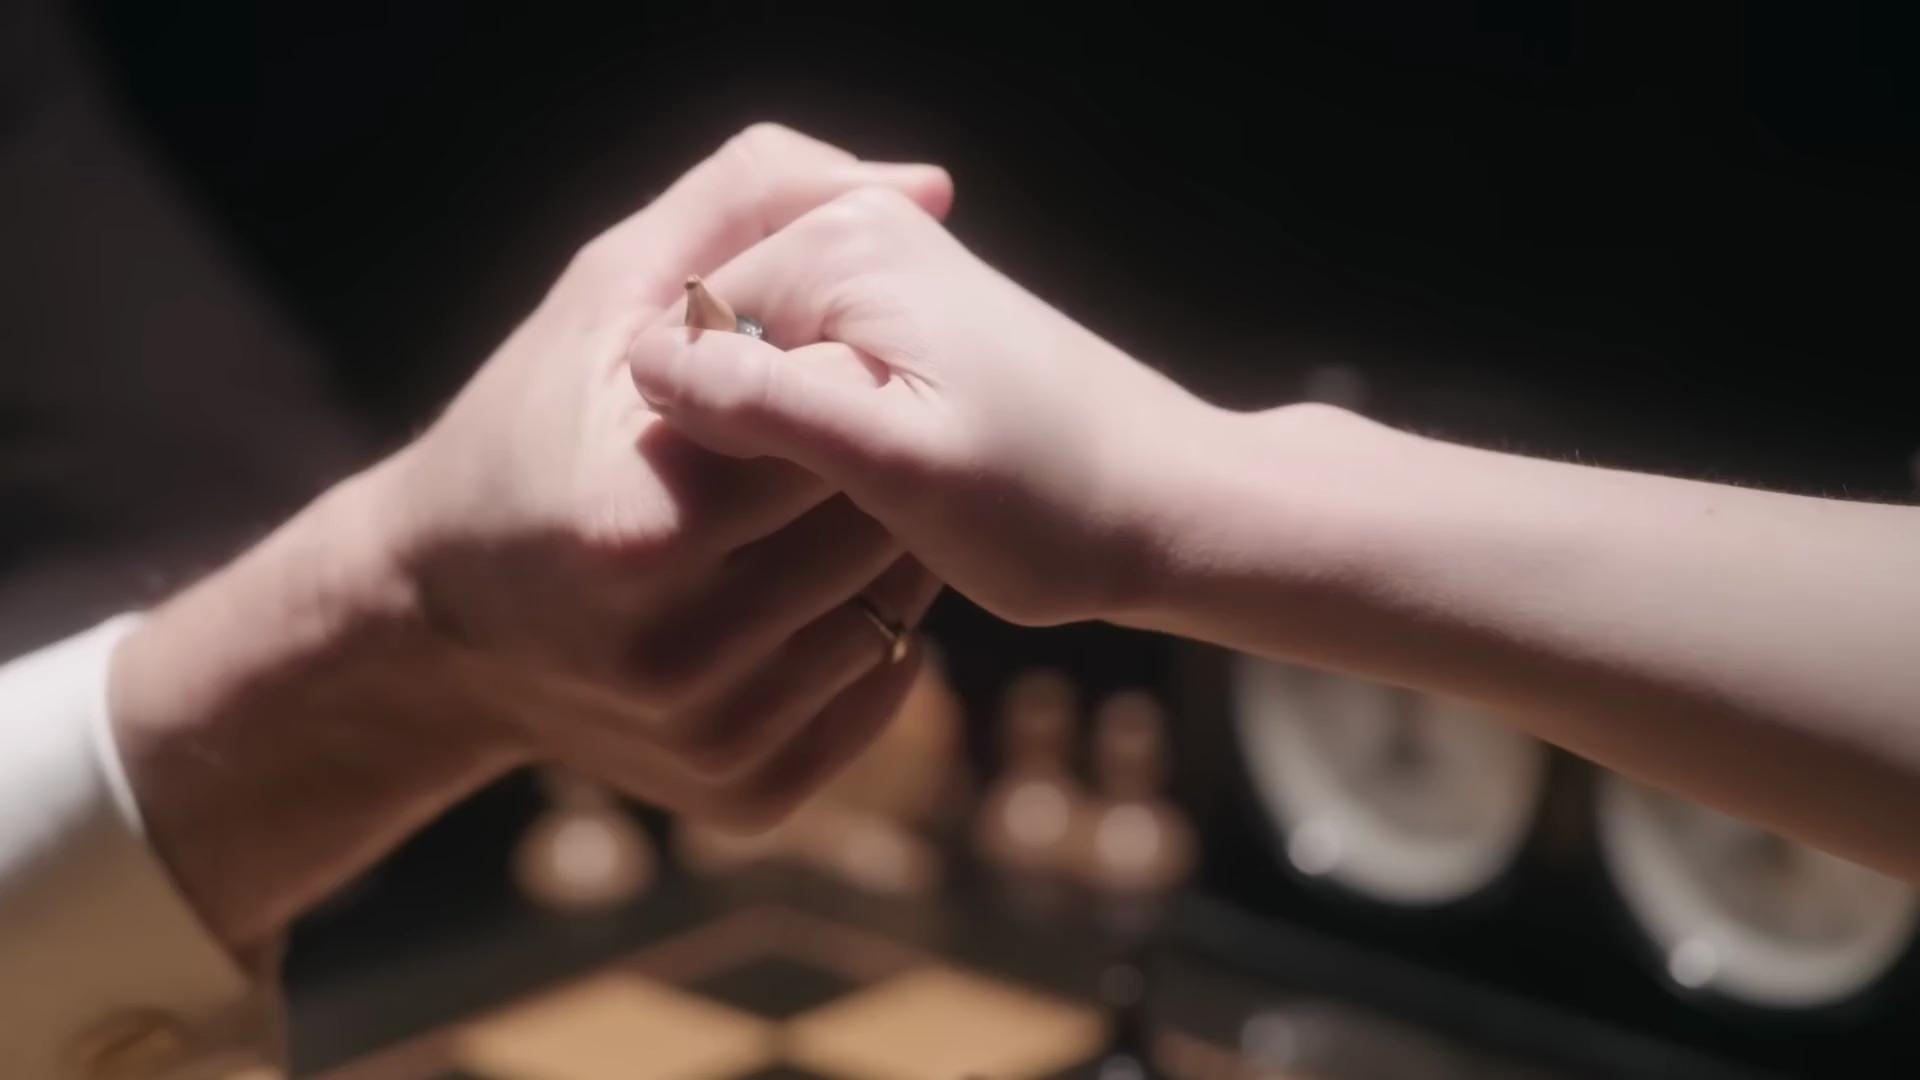
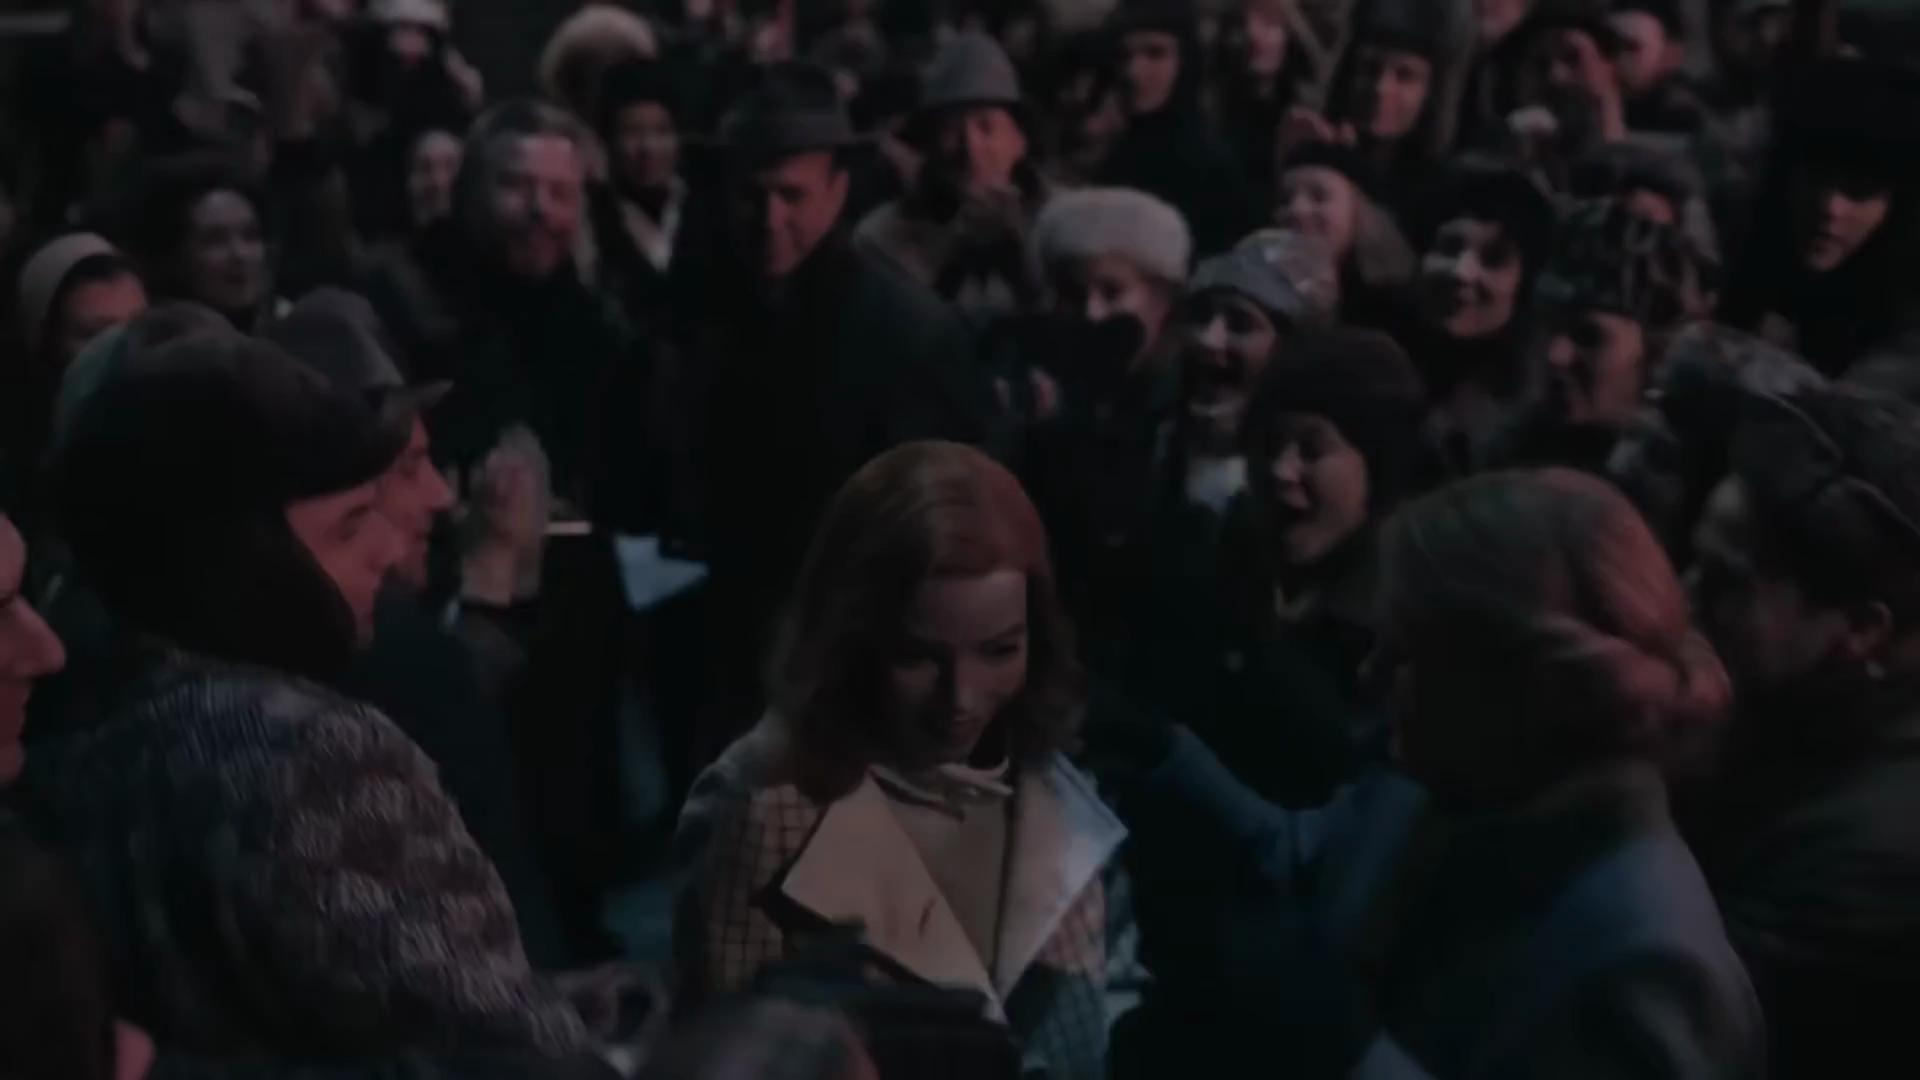
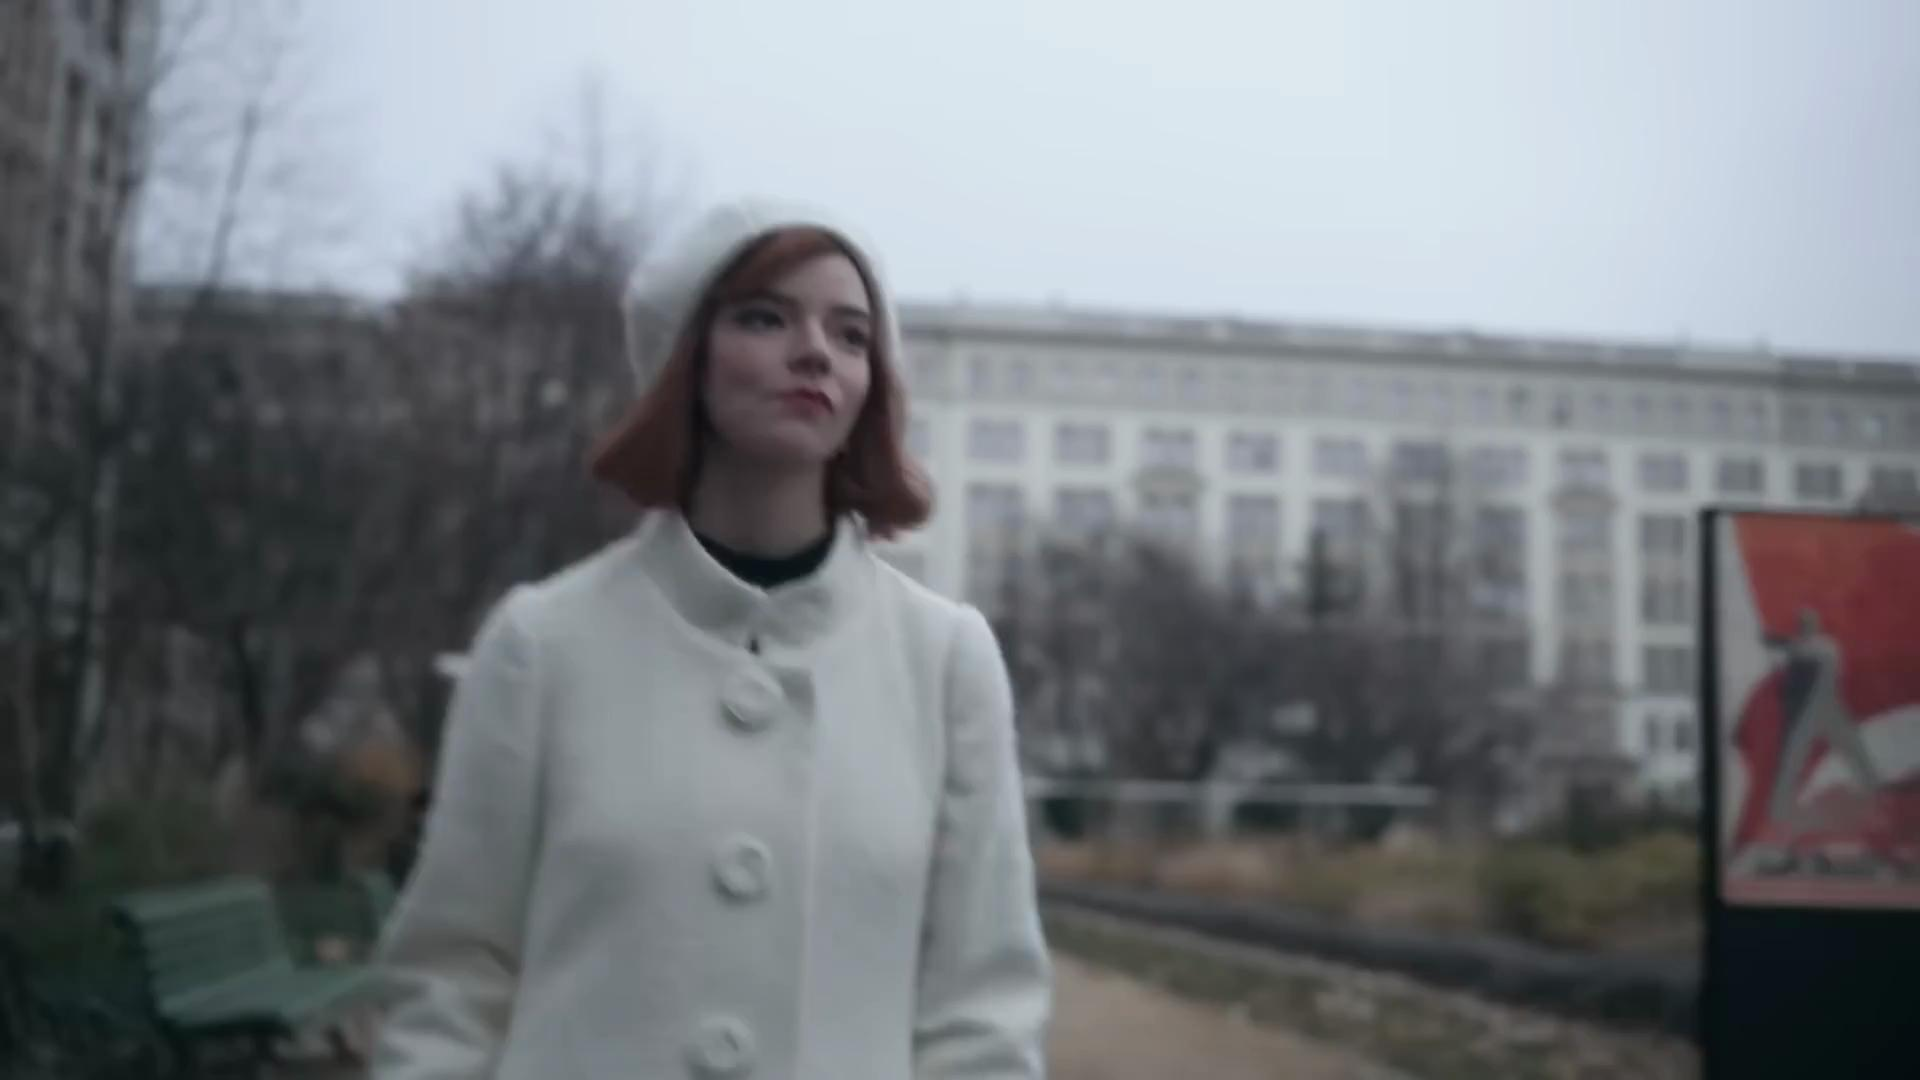

In [18]:
sim_scenes.select(sim_scenes.middle_clip).head()

## 02 - Concatenate scene clips into a single reel

Now we'll combine the video clips from our similar scenes into one continuous scene reel.

**Why resize first?** Gemini's video generation model outputs videos at 1280x720 resolution. Since [`concat_videos()`](https://docs.pixeltable.com/sdk/latest/video#udf-concat_videos) requires all videos to have the same resolution, we'll resize our scene clips to 1280x720 now so everything matches when we assemble the final reel (intro + scene reel) in Section 04.

**Steps:**
1. Add resized clips as computed column to sim_scenes
2. Concatenate the resized clips into a single video

**Step 1: Add resized clips as computed column**

We'll add a computed column to `sim_scenes` that resizes the middle clips to 1280x720 using [`clip()`](https://docs.pixeltable.com/sdk/latest/video#udf-clip) to match Gemini's output resolution. Learn more about [video encoding](https://docs.pixeltable.com/sdk/latest/video).

Added 5 column values with 0 errors.


scene_pos                                       resized_clip
0          2  /Users/alison-pxt/.pixeltable/media/60a18d686b...
1          4  /Users/alison-pxt/.pixeltable/media/60a18d686b...
2          6  /Users/alison-pxt/.pixeltable/media/60a18d686b...
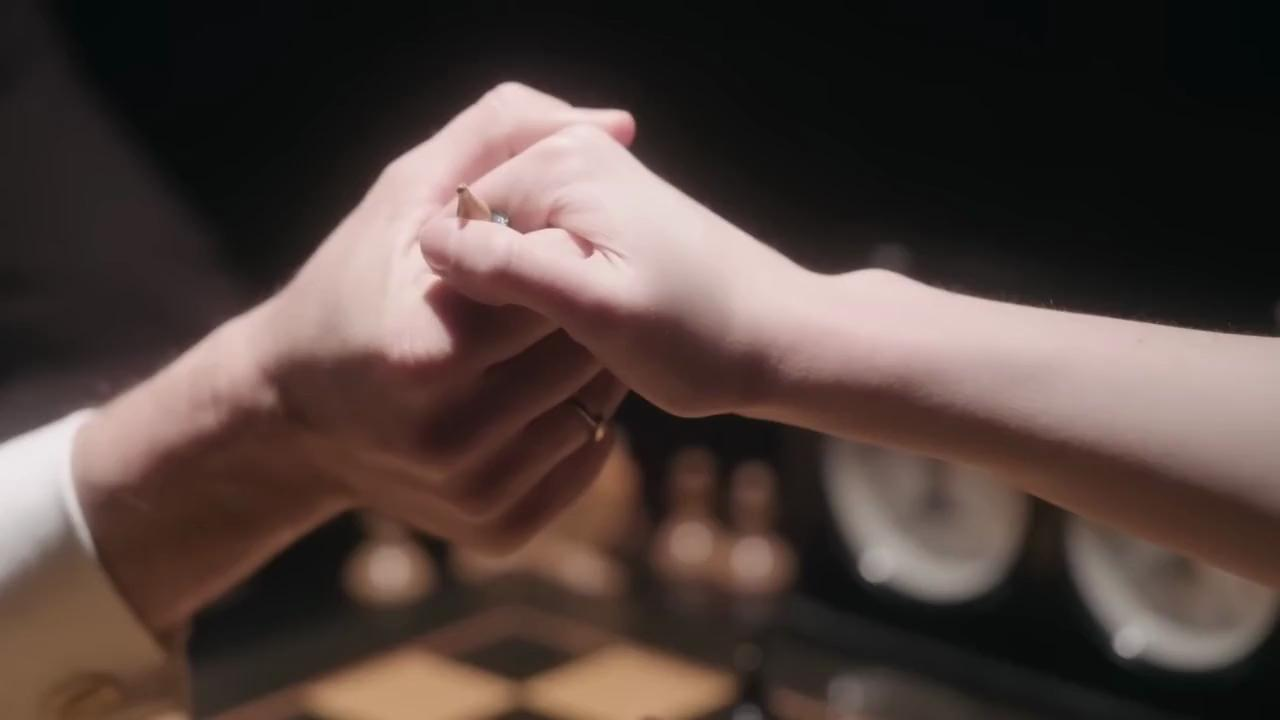
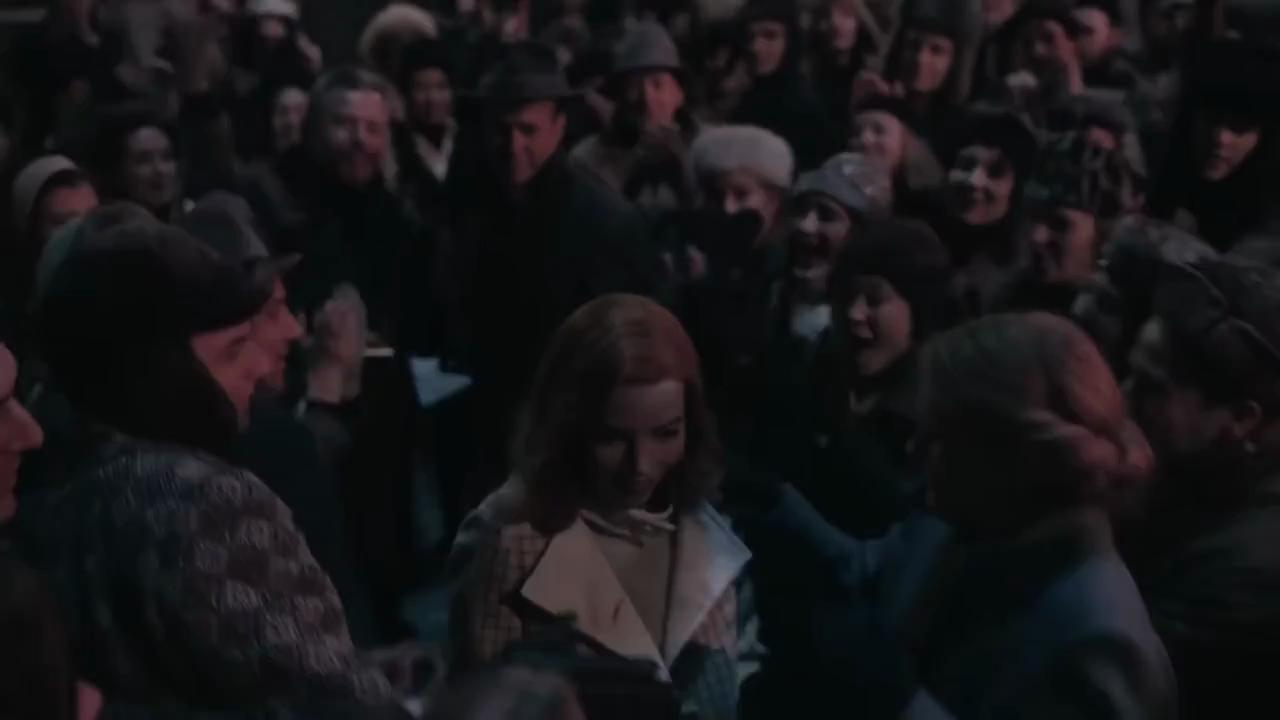
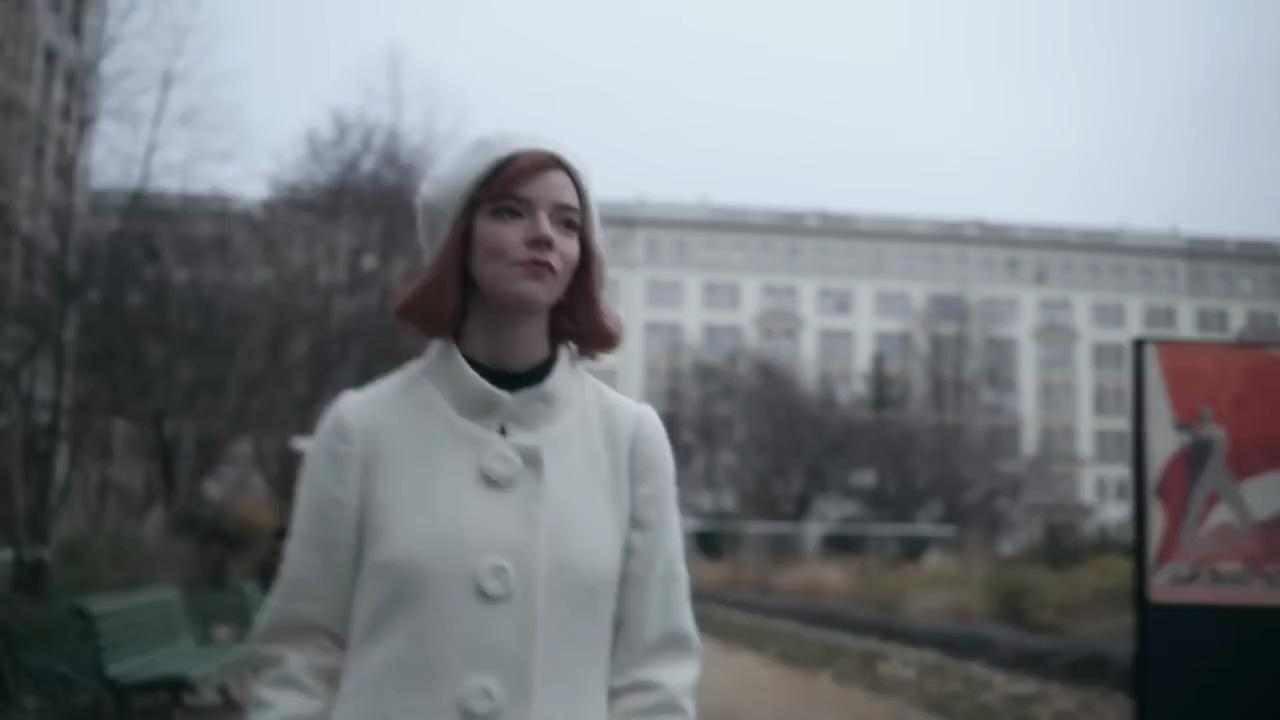

In [ ]:
import pixeltable.functions.video as vid

# Add resized_clip as a computed column to sim_scenes
# re-encode when we make the middle clip
sim_scenes.add_computed_column(
    resized_clip=vid.clip(
        sim_scenes.middle_clip,
        start_time=0,
        video_encoder='libx264',
        video_encoder_args={'vf': 'scale=1280:720'}
    ),
    if_exists='replace'
)

# Preview the resized clips (excluding scene_pos = 3 and 5)
clips = (
    sim_scenes
    .where((sim_scenes.scene_pos != 3) & (sim_scenes.scene_pos != 5))
    .select(sim_scenes.scene_pos, sim_scenes.resized_clip)
    .order_by(sim_scenes.scene_pos)
    .collect()
    )
clips

**Step 2: Concatenate the resized clips**

We'll collect the resized clips (excluding scene_pos = 3 and 5), insert them into a table with a Json column, and use [`concat_videos()`](https://docs.pixeltable.com/sdk/latest/video#udf-concat_videos) to combine them into one continuous video. Learn more about the [type system](https://docs.pixeltable.com/platform/type-system) for Json types.

In [20]:
from pixeltable.functions.video import concat_videos
from pixeltable.functions.uuid import uuid4

# Collect resized clips (excluding scene_pos = 3 and 5) for concatenation
resized_clips_list = (
    sim_scenes
    .where((sim_scenes.scene_pos != 3) & (sim_scenes.scene_pos != 5))
    .select(sim_scenes.resized_clip)
    .order_by(sim_scenes.scene_pos)
    .collect()['resized_clip']
)

In [21]:
resized_clips_list

['/Users/alison-pxt/.pixeltable/media/60a18d686b094d188ece0790170c7a63/48/48c3/60a18d686b094d188ece0790170c7a63_10_3_48c3ab286ccf4130ab0ca113071438ee.mp4',
 '/Users/alison-pxt/.pixeltable/media/60a18d686b094d188ece0790170c7a63/cd/cde2/60a18d686b094d188ece0790170c7a63_10_3_cde237d39c6b45a09de5efce39ecc48c.mp4',
 '/Users/alison-pxt/.pixeltable/media/60a18d686b094d188ece0790170c7a63/c2/c2dd/60a18d686b094d188ece0790170c7a63_10_3_c2ddd9ee8feb476da08e618e006d9d0f.mp4']

Create sim_scenes_concat table with Json column to hold list of videos:

In [22]:
sim_scenes_concat = pxt.create_table(
    'sim_scenes_concat',
    schema={
        'reel_id': uuid4(),
        'clips': pxt.Json
    },
    if_exists='replace'
)

Created table 'sim_scenes_concat'.


In [23]:
sim_scenes_concat

table 'sim_scenes_concat'

 Column Name            Type Computed With
     reel_id  Required[UUID]       uuid4()
       clips            Json

Insert clips as Json list (list of video file paths)

In [24]:
sim_scenes_concat.insert([{'clips': resized_clips_list}])

Inserting rows into `sim_scenes_concat`: 1 rows [00:00, 225.89 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 1 value computed.

In [25]:
sim_scenes_concat.collect()

reel_id  \
0  ecc39129-7a7b-4534-93ea-d1fc56b7024b   

                                               clips  
0  [/Users/alison-pxt/.pixeltable/media/60a18d686...

Use concat_videos in computed column on the Json column

In [26]:
sim_scenes_concat.add_computed_column(scenes_reel=concat_videos(sim_scenes_concat.clips))

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**View the concatenated scene reel**

The sim_scenes_concat table now contains the concatenated video. Let's view it:

scenes_reel
0  /Users/alison-pxt/.pixeltable/media/f7d740b4ed...
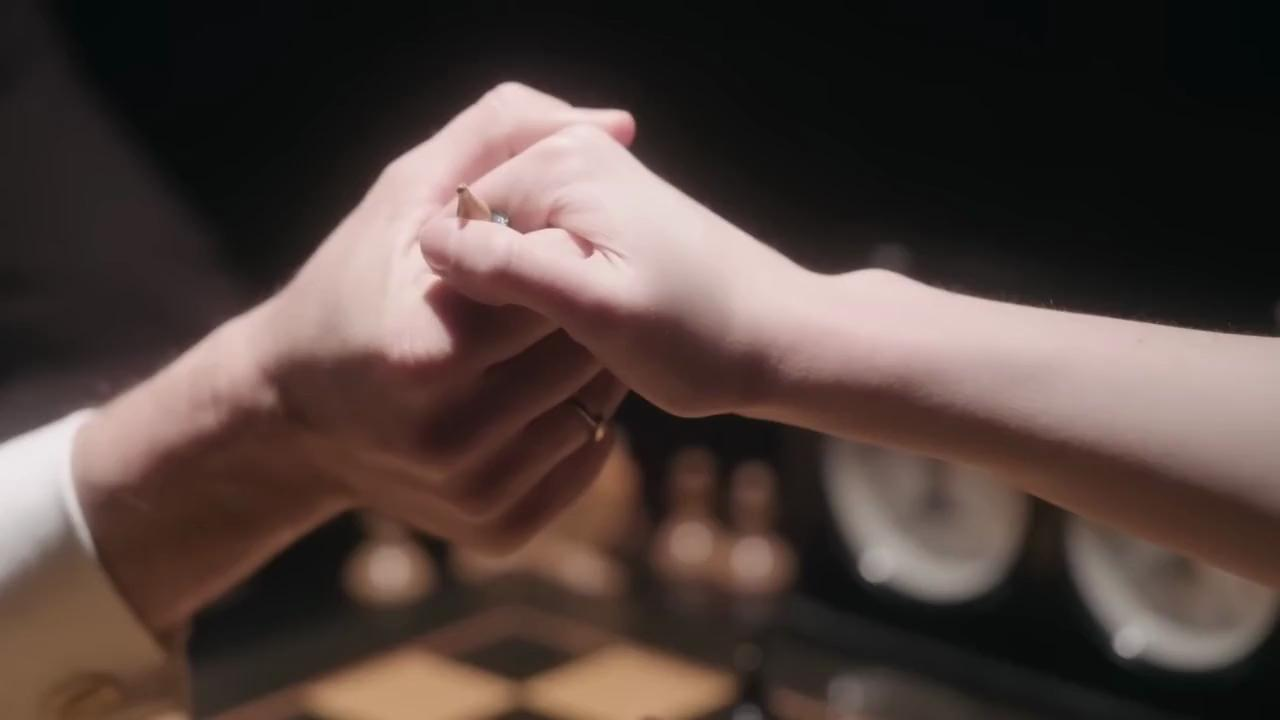

In [27]:
sim_scenes_concat.select(sim_scenes_concat.scenes_reel).collect()

## 03 - Generate intro using video model (Gemini)

We'll use Gemini's Veo video generation model to create a professional intro video.

**Steps:**
1. Insert inspiration image for intro
2. Create a table to store the image and prompt
3. Generate intro video from image

**Step 1: Create intro_scene table**

Create a table to store our intro inspiration image and text prompt for intro video generation.

In [ ]:
# no separate table here, instead add the image to the base video table as an img column (still 1 row)
intro_scene = pxt.create_table(
    'intro_scene',
    schema={
        'inspo_intro': pxt.Image,
        'intro_prompt': pxt.String
    },
    if_exists='replace'
)

Created table 'intro_scene'.


Insert the intro inspiration image and text prompt. The intro prompt will guide the image animation:

In [29]:
intro_scene.insert([{
    'inspo_intro': 'source/queens-gambit-img.jpg',
    'intro_prompt': 'No audio track. Fade in. Camera rises smoothly from ground level to birds eye view, tilting down to look straight at the ground. Scene is frozen in time—nothing moves except the camera.'
}])

Inserting rows into `intro_scene`: 1 rows [00:00, 253.62 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 3 values computed.

inspo_intro  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                        intro_prompt  
0  No audio track. Fade in. Camera rises smoothly...
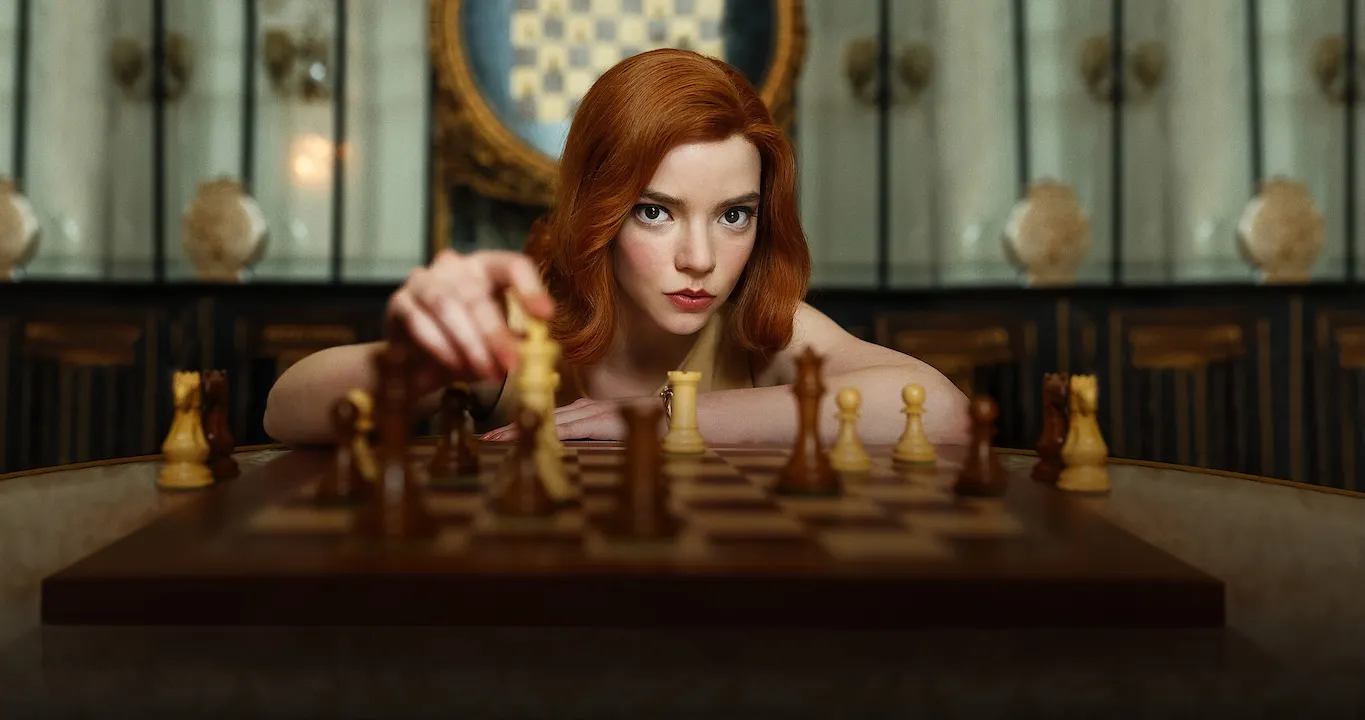

In [30]:
intro_scene.collect()

**Step 2: Generate intro video (image-to-video)**

Add a computed column that uses Gemini's [`generate_videos()`](https://docs.pixeltable.com/sdk/latest/gemini#udf-generate_videos) function to animate the intro frame. The model will create a 4-second video (720p resolution) based on the image and prompt.

In [31]:
from pixeltable.functions import gemini

intro_scene.add_computed_column(
    intro_video=gemini.generate_videos(
        prompt=intro_scene.intro_prompt,
        image=intro_scene.inspo_intro,
        model='veo-3.0-generate-001',
        config={'duration_seconds': 4}
    ),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [32]:
intro_scene

table 'intro_scene'

   Column Name             Type                                      Computed With
   inspo_intro            Image                                                   
  intro_prompt           String                                                   
   intro_video  Required[Video]  generate_videos(prompt=intro_prompt, image=ins...

View the generated intro video:

intro_video
0  /Users/alison-pxt/.pixeltable/media/0b94d695b7...
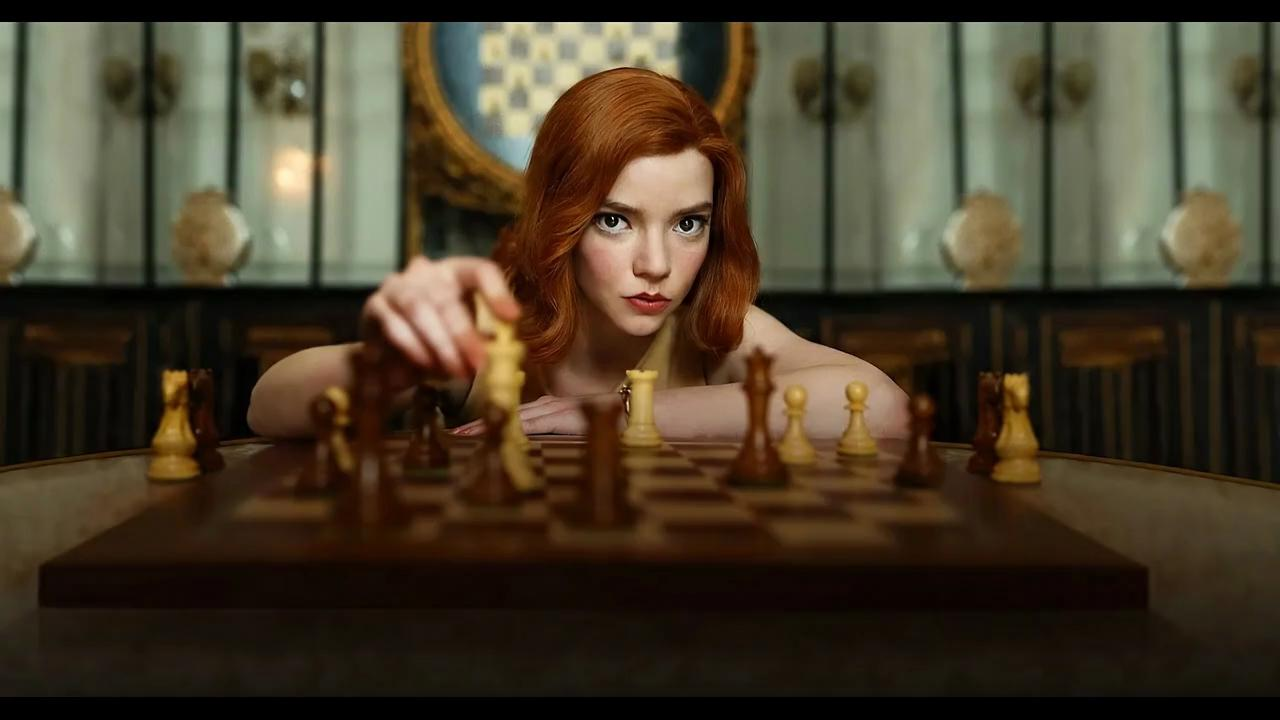

In [33]:
intro_scene.select(intro_scene.intro_video).collect()

## 04 - Assemble the final highlight reel

Now we'll combine all components into one complete video with background music:
1. **Intro video**: 4-second Gemini-generated animation from image (1280x720)
2. **Scene reel**: Concatenated clips from visually similar scenes (resized to 1280x720)
3. **Background audio**: Music track to accompany the final reel

Since [`concat_videos()`](https://docs.pixeltable.com/sdk/latest/video#udf-concat_videos) requires all videos to have the same resolution, we resized the scene clips to 1280x720 in Section 02.

**Steps:**
1. Create a table to hold all components
2. Retrieve the videos from their respective tables
3. Insert them into the final reels table
4. Concatenate videos and add audio in one step

**Step 1: Create reels table**

This table will hold the intro video and scene reel as separate columns. 

We'll again use [`uuid4()`](https://docs.pixeltable.com/howto/cookbooks/core/workflow-uuid-identity) to automatically generate a unique ID for each reel—this makes it easy to track and reference specific completed videos in your production system.

In [34]:
reels = pxt.create_table(
    'reels',
    schema={
        'reel_id': uuid4(),
        'intro_video': pxt.Video,
        'sim_scenes_concat': pxt.Video,
        'bg_audio': pxt.Audio
    },
    if_exists='replace'
)

Created table 'reels'.


**Step 2: Retrieve the video components**

Pull the intro video from the `intro_scene` table and the scene reel from the `sim_scenes_concat` table:


In [35]:
intro_row = intro_scene.select(intro_scene.intro_video).collect()[0]
scene_row = sim_scenes_concat.select(sim_scenes_concat.scenes_reel).collect()[0]

**Step 3: Insert the components into the reels table**

Add a row containing the video components:


In [36]:
reels.insert([{
    'intro_video': intro_row['intro_video'],
    'sim_scenes_concat': scene_row['scenes_reel'],
    'bg_audio': 'source/goldberg.mp3'
}])

Inserting rows into `reels`: 1 rows [00:00, 174.65 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 7 values computed.

reel_id  \
0  f3d2d59e-0963-46dd-a689-f395b9460070   

                                         intro_video  \
0  /Users/alison-pxt/.pixeltable/media/0b94d695b7...   

                                   sim_scenes_concat  \
0  /Users/alison-pxt/.pixeltable/media/f7d740b4ed...   

                                            bg_audio  
0  /Users/alison-pxt/Documents/Github/pxt-primeti...
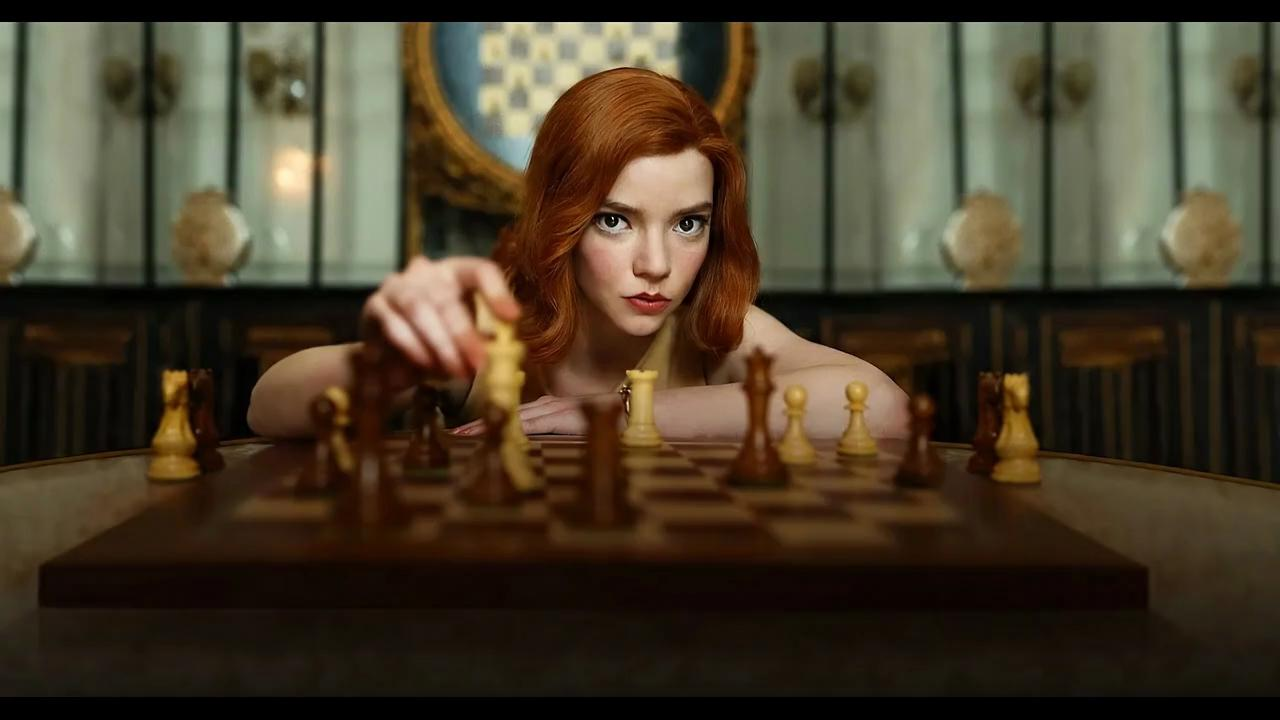
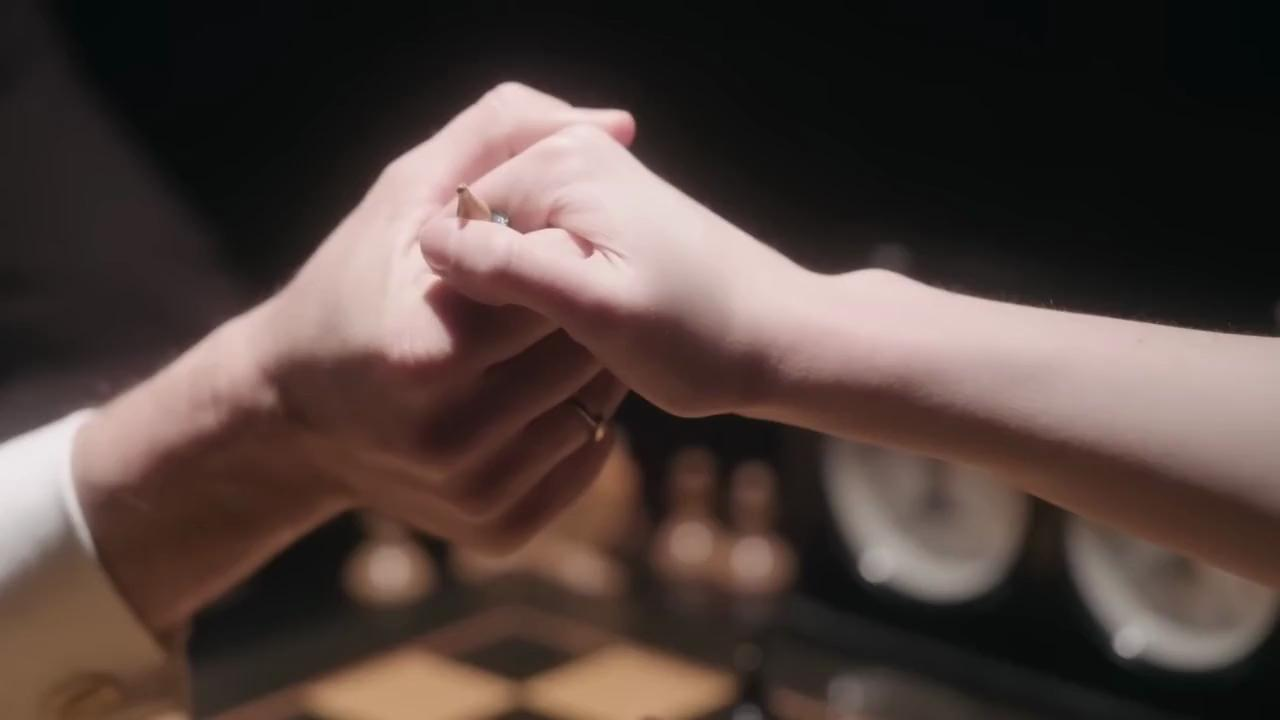

In [37]:
reels.collect()

**Step 4: Concatenate videos and add audio**

Add a computed column that concatenates the intro and scene reel, then adds background music in one step. 
We'll use the `destination` parameter to specify where the computed video file should be stored. 
You can use local paths (as shown here) or configure [cloud storage destinations](https://docs.pixeltable.com/integrations/cloud-storage) 
for production deployments:

In [38]:
from pixeltable.functions.video import concat_videos, with_audio
from pathlib import Path

desktop_path = Path.home() / "Desktop" / "vidz_output"
desktop_path.mkdir(parents=True, exist_ok=True)

reels.add_computed_column(
    final_reel_with_audio=with_audio(
        video=concat_videos(
            [reels.intro_video.astype(pxt.String), reels.sim_scenes_concat.astype(pxt.String)]
        ),
        audio=reels.bg_audio
    ),
    destination=str(desktop_path),
    if_exists='replace'
)

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

**View the complete final reel**

Now we can view the fully assembled video with intro, scene clips, and background music:


final_reel_with_audio
0  /Users/alison-pxt/Desktop/vidz_output/e2a59ccc...
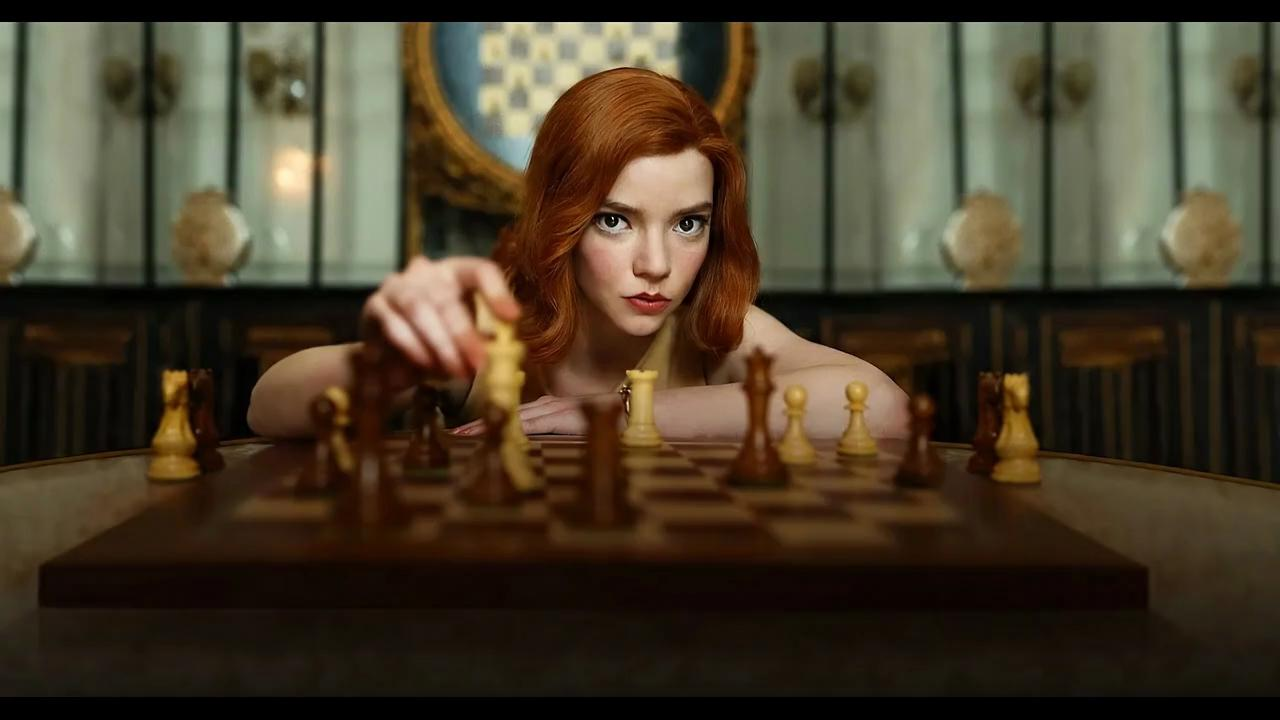

In [39]:
# View the final reel with audio
reels.select(reels.final_reel_with_audio).collect()

In [40]:
reels

table 'reels'

            Column Name            Type                                      Computed With
                reel_id  Required[UUID]                                            uuid4()
            intro_video           Video                                                   
      sim_scenes_concat           Video                                                   
               bg_audio           Audio                                                   
  final_reel_with_audio           Video  with_audio(video=concat_videos([intro_video.as...

🎉 **You just built a complete video generation pipeline!**

With Pixeltable, you've transformed your source video into a fully automated content generation system:

- **Found similar scenes** - Used semantic search to identify visually similar scenes across your video
- **Created scene reels** - Extracted and concatenated clips into cohesive sequences
- **Generated intro video** - Used AI (Gemini's Veo model) to create professional video sequences from images
- **Assembled final reels with audio** - Combined all components (intro, scene clips) and added background music in one step

This demonstrates the power of generating new content from data in Pixeltable - you've built a real-world example of what a marketing firm would use to generate trailers, highlights, and promotional content from hours of source footage. All the capabilities of Pixeltable work together to make this possible: persistent storage, computed columns, views, embedding indexes, and multimodal AI integration.

## Wrap-Up

You built a video generation pipeline using Pixeltable:

```
Scenes → VIEW: scene_view
│
├── Extract middle frames (on VIEW: scene_view)
│   └── add computed column: middle_frame = extract_frame(duration/2)
│
├── Generate embeddings on middle frames (on VIEW: scene_view)
│   └── add_embedding_index(middle_frame, CLIP)
│
├── Find similar scenes
│   ├── Extract query image: extract_frame(timestamp=16)
│   ├── Search: middle_frame.similarity(query_frame)
│   ├── Select: top 5 similar scenes → TABLE: similar-scenes
│   │
│   └── Process selected scenes (on TABLE: similar-scenes)
│       ├── add computed column: middle_clip (6-second clips)
│       ├── add computed column: resized_clip (1280x720)
│       │
│       └── Concatenate scene clips → TABLE: sim_scenes_concat
│           └── add computed column: concat_videos(clips)
│
├── Generate intro → TABLE: intro_scene
│   └── add computed column: gemini.generate_videos(image, prompt)
│
└── Assemble final reel → TABLE: reels
    └── add computed column: concat_videos([intro, scenes]) + with_audio()
        └── destination: ~/Desktop/vidz_output
```

---

## Learn More

### Video Operations
- [Video Functions SDK](https://docs.pixeltable.com/sdk/latest/video) - Complete video function reference
- [`extract_frame()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_frame) - Extract frames from video
- [`get_duration()`](https://docs.pixeltable.com/sdk/latest/video#udf-get_duration) - Get video duration
- [`clip()`](https://docs.pixeltable.com/sdk/latest/video#udf-clip) - Extract video clips
- [`concat_videos()`](https://docs.pixeltable.com/sdk/latest/video#udf-concat_videos) - Concatenate multiple videos
- [`with_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-with_audio) - Add audio to video

### Embeddings & Search
- [Embedding Indexes](https://docs.pixeltable.com/platform/embedding-indexes) - Building searchable indexes
- [CLIP Functions](https://docs.pixeltable.com/sdk/latest/huggingface#clip) - Image embeddings with CLIP
- [Similarity Search Cookbooks](https://docs.pixeltable.com/howto/cookbooks/search/search-similar-images) - Performing similarity search

### AI Generation
- [Working with Gemini](https://docs.pixeltable.com/howto/providers/working-with-gemini) - Gemini integration guide
- [`generate_videos()`](https://docs.pixeltable.com/sdk/latest/gemini#udf-generate_videos) - Generate videos from images and prompts

### Data Management
- [Tables and Data Operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations) - Creating and managing tables
- [Type System](https://docs.pixeltable.com/platform/type-system) - Json, Video, and other types
- [UUID Identity Cookbook](https://docs.pixeltable.com/howto/cookbooks/core/workflow-uuid-identity) - Using `uuid4()` for unique identifiers

### Storage & Deployment
- [Cloud Storage Integration](https://docs.pixeltable.com/integrations/cloud-storage) - Configuring cloud storage destinations
- [Configuration](https://docs.pixeltable.com/platform/configuration) - Pixeltable configuration options

## Functions Used

This notebook uses the following Pixeltable functions:

- [`add_computed_column()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-computed-column) - Add computed columns to tables
- [`add_embedding_index()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-embedding-index) - Create embedding indexes for similarity search
- [`clip()`](https://docs.pixeltable.com/sdk/latest/video#udf-clip) - Extract video clips
- [`concat_videos()`](https://docs.pixeltable.com/sdk/latest/video#udf-concat_videos) - Concatenate multiple videos into one
- [`create_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-table) - Create new tables
- [`extract_frame()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_frame) - Extract frames from video at specific timestamps
- [`generate_videos()`](https://docs.pixeltable.com/sdk/latest/gemini#udf-generate_videos) - Generate videos using Gemini
- [`get_duration()`](https://docs.pixeltable.com/sdk/latest/video#udf-get_duration) - Get video duration
- [`get_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-get-table) - Retrieve existing tables
- [`list_tables()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-list-tables) - List all tables in the database
- [`similarity()`](https://docs.pixeltable.com/sdk/latest/pixeltable#similarity) - Perform similarity search using embedding indexes
- [`uuid4()`](https://docs.pixeltable.com/sdk/latest/uuid#udf-uuid4) - Generate unique identifiers
- [`with_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-with_audio) - Add audio track to video